In [2]:
import numpy as np
from numpy import array, newaxis, expand_dims
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy as copy
import matplotlib.backends.backend_pdf as pdflib
import scipy as sp
import scipy.stats as stats
import math
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict
# plotly.tools.set_credentials_file(username='mhossa10', api_key='CSWpOV3xHUVRzimjfHSB')
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [2]:
color_list1 = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02']
color_list2 = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33']
color_list3 = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c']

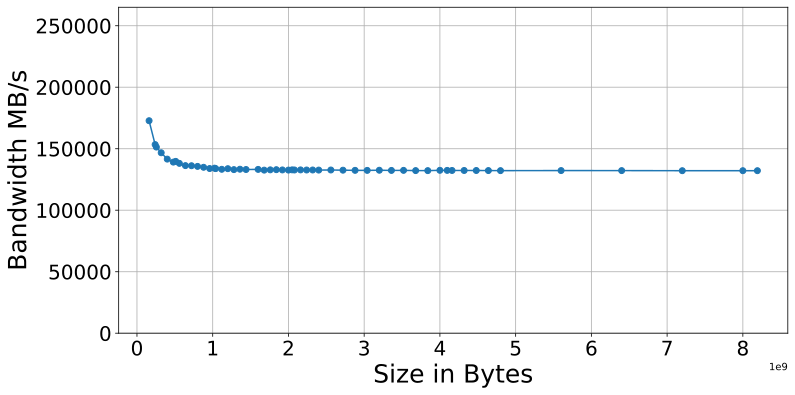

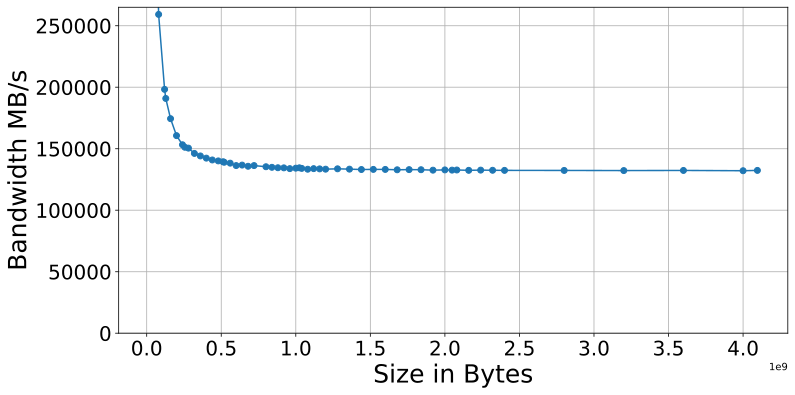

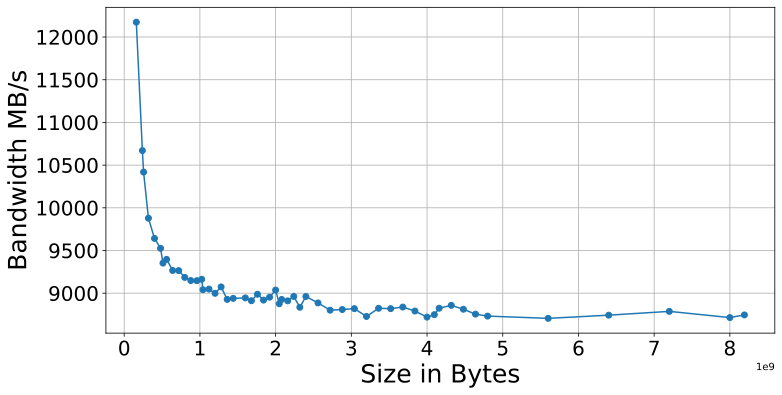

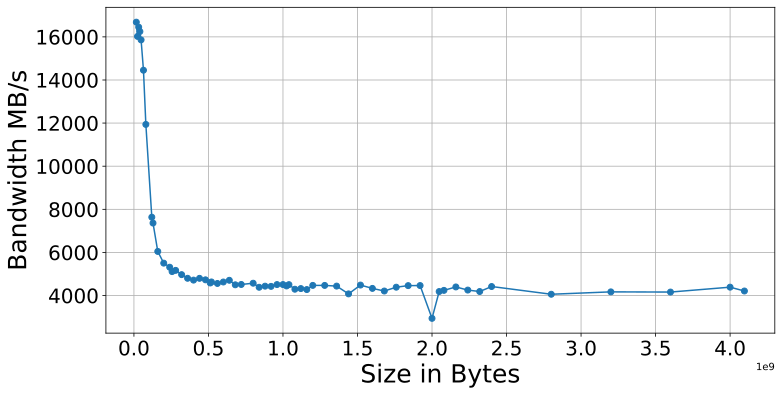

In [3]:
skylake_res = pd.read_csv("../../STREAM/Results/SKYLAKE.csv")
skylake_res = skylake_res[skylake_res["Size"] >= 16000000]
pdf = pdflib.PdfPages("figures/stream/skylake_mpi_copy_double_precision.pdf")
copy_res = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 8)].sort_values(by="Size").reset_index()
copy_res = copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = copy_res.plot(kind="line", ax=ax1, x="Size", y="Bandwidth_MBS", style="-o", legend=False, figsize=(12,6), fontsize=20)
ax.set_ylabel("Bandwidth MB/s", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()

pdf = pdflib.PdfPages("figures/stream/skylake_mpi_copy_single_precision.pdf")
copy_res = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
copy_res = copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = copy_res.plot(kind="line", ax=ax1, x="Size", y="Bandwidth_MBS", style="-o", legend=False, figsize=(12,6), fontsize=20)
ax.set_ylabel("Bandwidth MB/s", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True)
ax.set_ylim(0, 265000)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()



pdf = pdflib.PdfPages("figures/stream/skylake_mpi_random_copy_double_precision.pdf")
random_copy_res = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 8)].sort_values(by="Size").reset_index()
random_copy_res = random_copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = random_copy_res.plot(kind="line", ax=ax1, x="Size", y="Bandwidth_MBS", style="-o", legend=False, figsize=(12,6), fontsize=20)
ax.set_ylabel("Bandwidth MB/s", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True)
# ax.set_ylim(0, 265000)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


pdf = pdflib.PdfPages("figures/stream/skylake_mpi_random_copy_single_precision.pdf")
random_copy_res = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
random_copy_res = random_copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = random_copy_res.plot(kind="line", ax=ax1, x="Size", y="Bandwidth_MBS", style="-o", legend=False, figsize=(12,6), fontsize=20)
ax.set_ylabel("Bandwidth MB/s", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True)
# ax.set_ylim(0, 265000)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()



# scal_res = skylake_res[(skylake_res["Operation"] == "Scale") & (skylake_res["DataType"] == 8].sort_values(by="Size").reset_index()
# add_res = skylake_res[(skylake_res["Operation"] == "Add") & (skylake_res["DataType"] == 8].sort_values(by="Size").reset_index()
# triad_res = skylake_res[(skylake_res["Operation"] == "Triad") & (skylake_res["DataType"] == 8].sort_values(by="Size").reset_index()


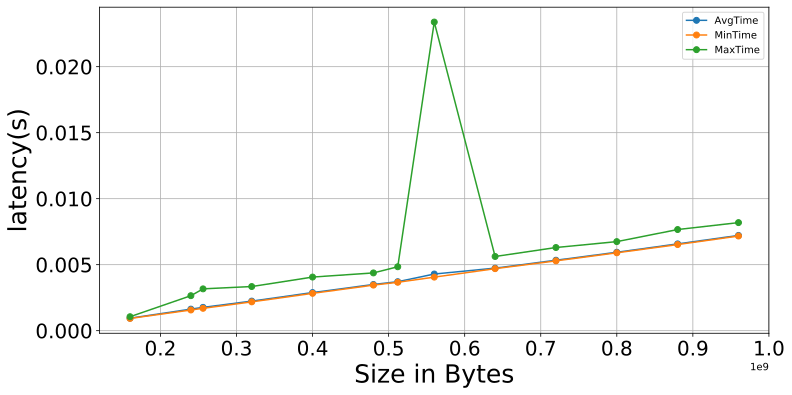

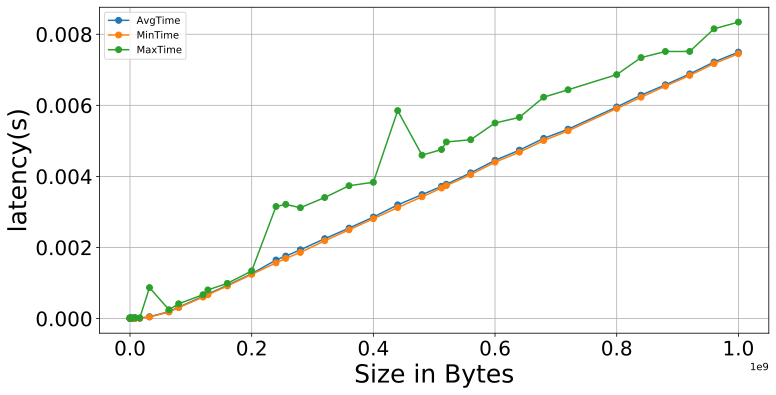

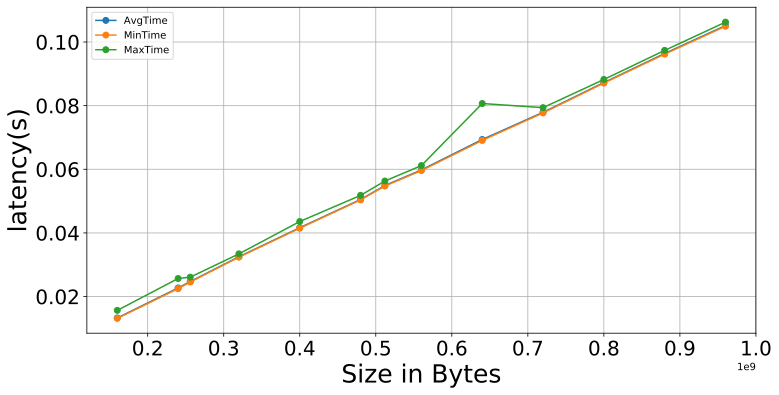

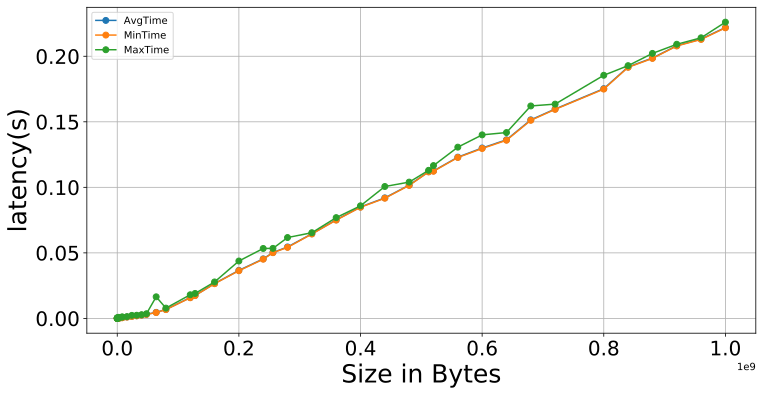

In [4]:
skylake_res = pd.read_csv("../../STREAM/Results/SKYLAKE.csv")
pdf = pdflib.PdfPages("figures/stream/skylake_mpi_copy_double_precision_time.pdf")
copy_res = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 8)].sort_values(by="Size").reset_index()
copy_res = copy_res[copy_res["Size"] <= 1000000000]
copy_res = copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = copy_res.plot(kind="line", ax=ax1, x="Size", y=["AvgTime", "MinTime", "MaxTime"], style="-o", figsize=(12,6), fontsize=20)
ax.set_ylabel("latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


pdf = pdflib.PdfPages("figures/stream/skylake_mpi_copy_single_precision_time.pdf")
copy_res = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
copy_res = copy_res[copy_res["Size"] <= 1000000000]
copy_res = copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = copy_res.plot(kind="line", ax=ax1, x="Size", y=["AvgTime", "MinTime", "MaxTime"], style="-o", figsize=(12,6), fontsize=20)
ax.set_ylabel("latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


pdf = pdflib.PdfPages("figures/stream/skylake_mpi_random_copy_double_precision_time.pdf")
random_copy_res = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 8)].sort_values(by="Size").reset_index()
random_copy_res = random_copy_res[random_copy_res["Size"] <= 1000000000]
random_copy_res = random_copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = random_copy_res.plot(kind="line", ax=ax1, x="Size", y=["AvgTime", "MinTime", "MaxTime"], style="-o", figsize=(12,6), fontsize=20)
ax.set_ylabel("latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()

pdf = pdflib.PdfPages("figures/stream/skylake_mpi_random_copy_single_precision_time.pdf")
random_copy_res = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
random_copy_res = random_copy_res[random_copy_res["Size"] <= 1000000000]
random_copy_res = random_copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = random_copy_res.plot(kind="line", ax=ax1, x="Size", y=["AvgTime", "MinTime", "MaxTime"], style="-o", figsize=(12,6), fontsize=20)
ax.set_ylabel("latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()

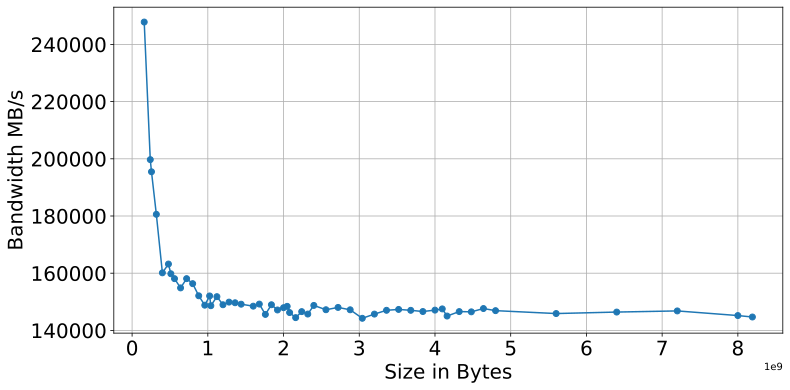

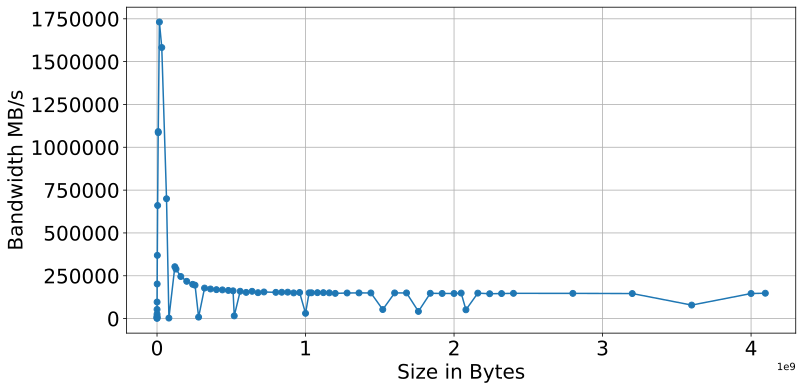

In [5]:
cascade_lake_res = pd.read_csv("../../STREAM/Results/CASCADE_LAKE.csv")
pdf = pdflib.PdfPages("figures/stream/cascade_lake_mpi_copy_double_precision.pdf")
copy_res = cascade_lake_res[(cascade_lake_res["Operation"] == "Copy") & (cascade_lake_res["DataType"] == 8)].sort_values(by="Size").reset_index()
copy_res = copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = copy_res.plot(kind="line", ax=ax1, x="Size", y="Bandwidth_MBS", style="-o", legend=False, figsize=(12,6), fontsize=20)
ax.set_ylabel("Bandwidth MB/s", fontsize=20)
ax.set_xlabel("Size in Bytes", fontsize=20)
ax.grid(True)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


pdf = pdflib.PdfPages("figures/stream/cascade_lake_mpi_copy_single_precision.pdf")
copy_res = cascade_lake_res[(cascade_lake_res["Operation"] == "Copy") & (cascade_lake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
copy_res = copy_res.groupby("Size").mean().reset_index()

fig1,ax1 = plt.subplots()
ax = copy_res.plot(kind="line", ax=ax1, x="Size", y="Bandwidth_MBS", style="-o", legend=False, figsize=(12,6), fontsize=20)
ax.set_ylabel("Bandwidth MB/s", fontsize=20)
ax.set_xlabel("Size in Bytes", fontsize=20)
ax.grid(True)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


# scal_res = cascade_lake_res[(cascade_lake_res["Operation"] == "Scale") & (cascade_lake_res["DataType"] == 8].sort_values(by="Size").reset_index()
# add_res = cascade_lake_res[(cascade_lake_res["Operation"] == "Add") & (cascade_lake_res["DataType"] == 8].sort_values(by="Size").reset_index()
# triad_res = cascade_lake_res[(cascade_lake_res["Operation"] == "Triad") & (cascade_lake_res["DataType"] == 8].sort_values(by="Size").reset_index()


# OSU Benchmark

# Cascade Lake

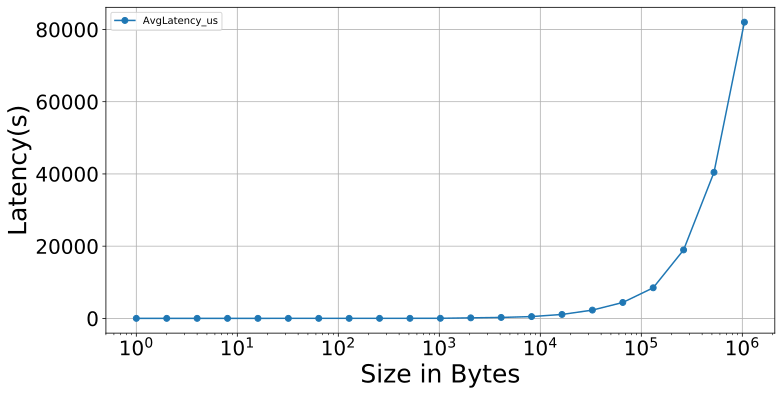

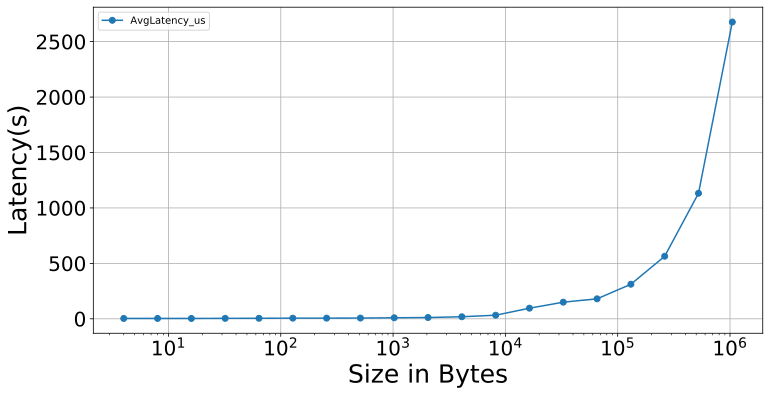

In [6]:
seq_bandwidth = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/cascade_allgatherv.csv")
seq_bandwidth = seq_bandwidth.groupby("Size").mean().reset_index()

pdf = pdflib.PdfPages("figures/osu/cascade_lake_mpi_allgatherv.pdf")
fig1,ax1 = plt.subplots()
ax = seq_bandwidth.plot(kind="line", ax=ax1, x="Size", y="AvgLatency_us", figsize=(12,6), fontsize=20, style="-o", logx=True)
ax.set_ylabel("Latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


pdf = pdflib.PdfPages("figures/osu/cascade_lake_mpi_allreduce.pdf")
fig1,ax1 = plt.subplots()
seq_bandwidth = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/cascade_allreduce.csv")
seq_bandwidth = seq_bandwidth.groupby("Size").mean().reset_index()
ax = seq_bandwidth.plot(kind="line", ax=ax1, x="Size", y="AvgLatency_us", figsize=(12,6), fontsize=20, style="-o", logx=True)
ax.set_ylabel("Latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()

# Skylake

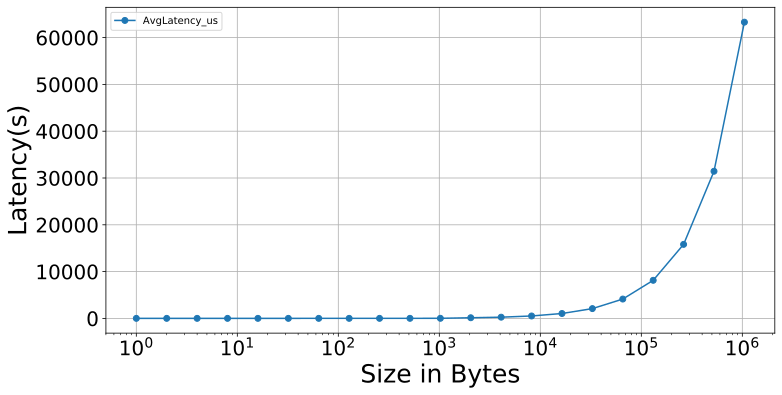

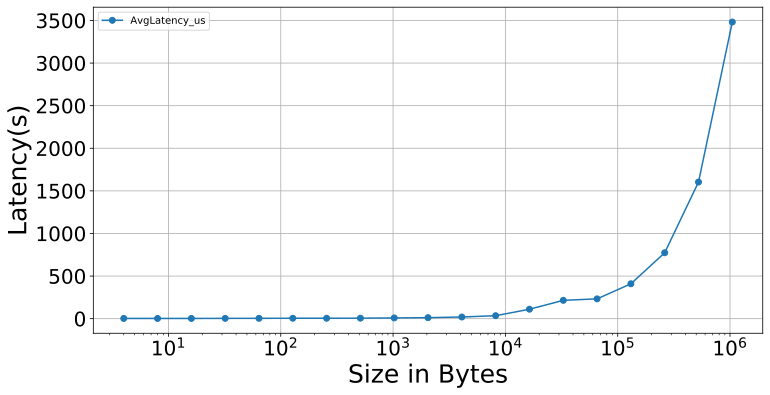

In [7]:
seq_bandwidth = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/skylake_allgatherv.csv")
seq_bandwidth = seq_bandwidth.groupby("Size").mean().reset_index()

pdf = pdflib.PdfPages("figures/osu/skylake_mpi_allgatherv.pdf")
fig1,ax1 = plt.subplots()
ax = seq_bandwidth.plot(kind="line", ax=ax1, x="Size", y="AvgLatency_us", figsize=(12,6), fontsize=20, style="-o", logx=True)
ax.set_ylabel("Latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()


pdf = pdflib.PdfPages("figures/osu/skylake_mpi_allreduce.pdf")
fig1,ax1 = plt.subplots()
seq_bandwidth = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/skylake_allreduce.csv")
seq_bandwidth = seq_bandwidth.groupby("Size").mean().reset_index()
ax = seq_bandwidth.plot(kind="line", ax=ax1, x="Size", y="AvgLatency_us", figsize=(12,6), fontsize=20, style="-o", logx=True)
ax.set_ylabel("Latency(s)", fontsize=25)
ax.set_xlabel("Size in Bytes", fontsize=25)
ax.grid(True)
# ax.set_ylim(0, 265000)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
pdf.savefig(fig1, bbox_inches = 'tight')
pdf.close()

In [8]:
seq_bandwidth

,Size,AvgLatency_us
0,4,2.87
1,8,2.69
2,16,2.72
3,32,3.68
4,64,4.29
5,128,5.09
6,256,5.02
7,512,5.92
8,1024,8.73
9,2048,11.91


# FMA FLOPS

# MPI

42.83539999999999
85.66865000000001


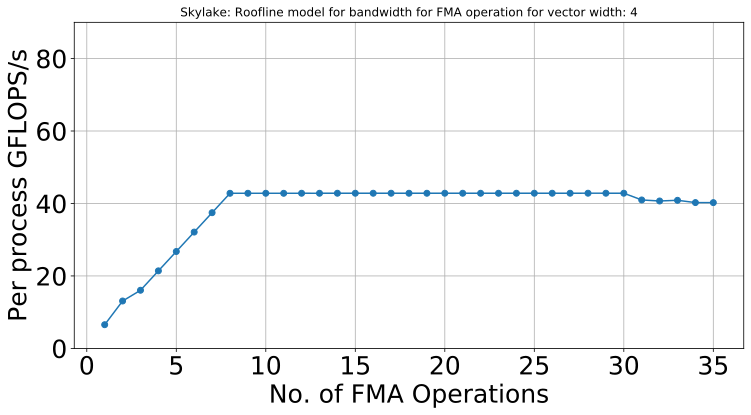

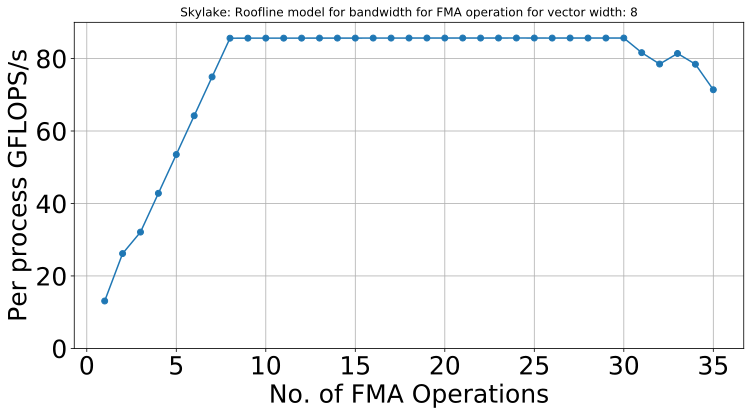

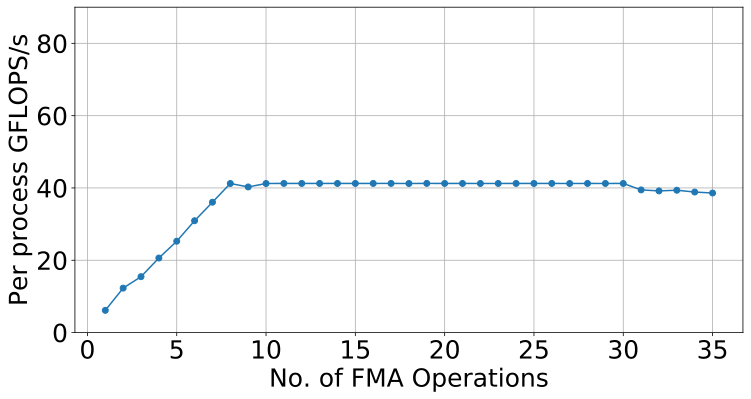

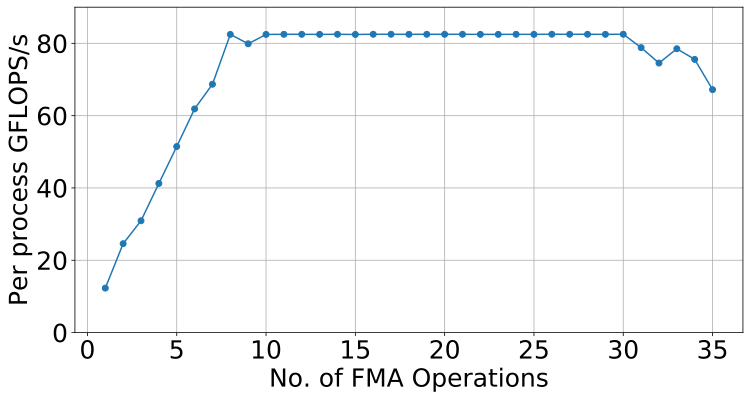

In [9]:
fmaRes = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/FMA_ON_SKYLAKE.csv")
fmaRes = fmaRes.groupby(["ChainedFMAs", "VectorWidth"]).mean().reset_index()
for vec,vec_data in fmaRes.groupby("VectorWidth"):
    pdf = pdflib.PdfPages("figures/fma/skylake_mpi_fma_roofline_model_for_vec_" + str(vec) + ".pdf")
    fig1,ax1 = plt.subplots()
    vec_data = vec_data.sort_values(by="ChainedFMAs").reset_index(drop=True)
    ax = vec_data.plot(kind="line", style="-o", ax=ax1, x="ChainedFMAs", legend=False, y="AvgGFLOPSPerSec", figsize=(12,6))
    ax.grid(True)
    ax.set_ylim(0,90)
    ax.set_ylabel("Per process GFLOPS/s", fontsize=25)
    ax.set_xlabel("No. of FMA Operations", fontsize=25)
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    ax.set_title("Skylake: Roofline model for bandwidth for FMA operation for vector width: " + str(vec))
    pdf.savefig(fig1, bbox_inches = 'tight')
    pdf.close()
    print(max(vec_data["AvgGFLOPSPerSec"]))
    
fmaRes = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/FMA_ON_CASCADE_LAKE.csv")
fmaRes = fmaRes.groupby(["ChainedFMAs", "VectorWidth"]).mean().reset_index()
for vec,vec_data in fmaRes.groupby("VectorWidth"):
    pdf = pdflib.PdfPages("figures/fma/cascade_lake_mpi_fma_roofline_model_for_vec_" + str(vec) + ".pdf")
    fig2,ax2 = plt.subplots()
    vec_data = vec_data.sort_values(by="ChainedFMAs").reset_index(drop=True)
    ax = vec_data.plot(kind="line", style="-o", ax=ax2, x="ChainedFMAs", legend=False, y="AvgGFLOPSPerSec", figsize=(12,6))
    ax.grid(True)
    ax.set_ylim(0,90)
    ax.set_ylabel("Per process GFLOPS/s", fontsize=25)
    ax.set_xlabel("No. of FMA Operations", fontsize=25)
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
#     ax.set_title("Cascade Lake: Roofline model for bandwidth for FMA operation for vector width: " + str(vec))
    pdf.savefig(fig2, bbox_inches = 'tight')
    pdf.close()
    
    

# OpenMP

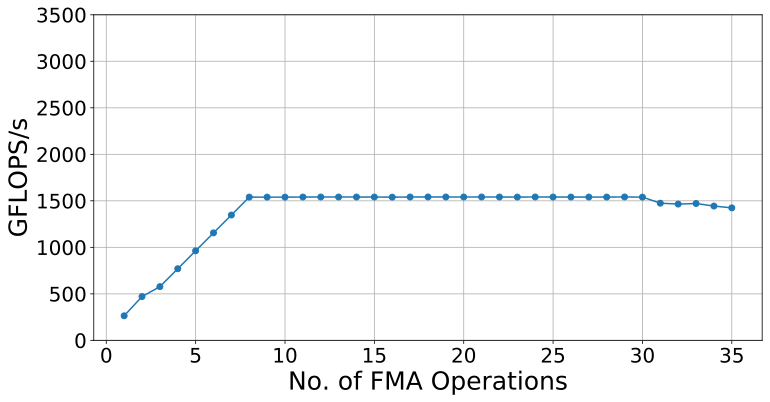

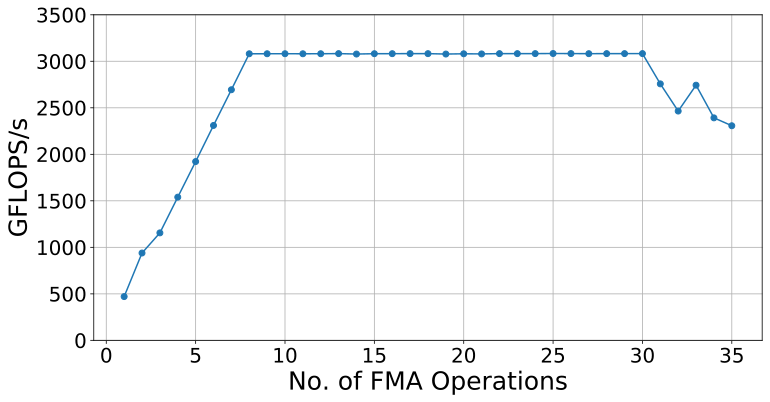

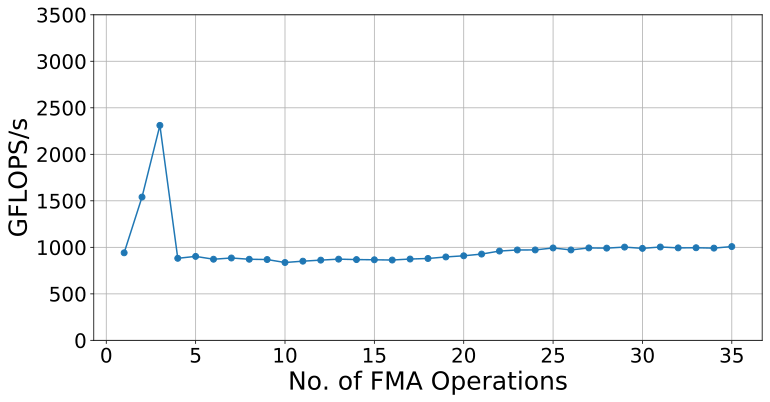

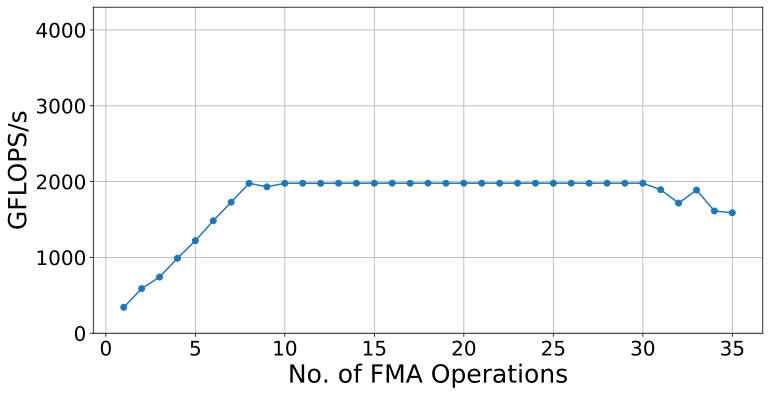

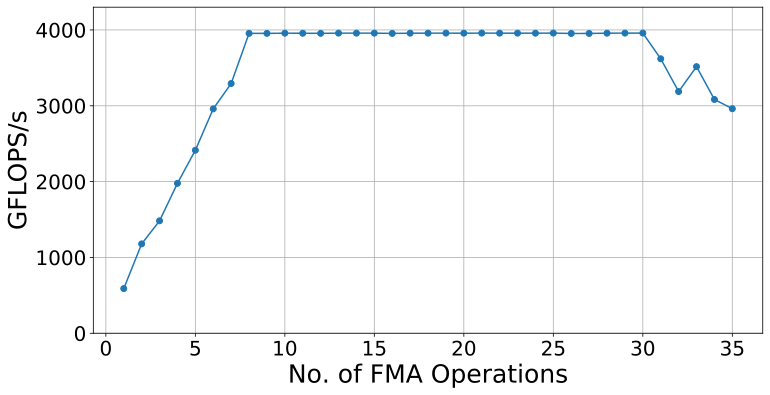

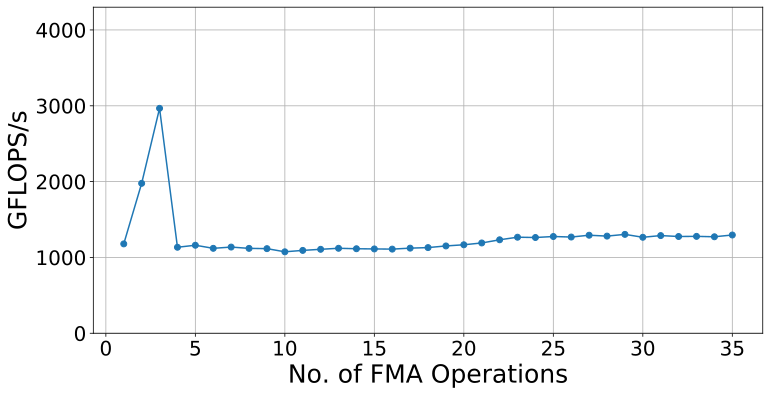

In [10]:
fmaRes = pd.read_csv("../../SpMVMicroBenchmark/omp/Results/FMA_ON_SKYLAKE.csv")
fmaRes = fmaRes.groupby(["ChainedFMAs", "VectorWidth"]).mean().reset_index()

for vec,vec_data in fmaRes.groupby("VectorWidth"):
    pdf = pdflib.PdfPages("figures/fma/skylake_omp_fma_roofline_model_for_vec_" + str(vec) + ".pdf")
    fig1,ax1 = plt.subplots()
    vec_data = vec_data.sort_values(by="ChainedFMAs").reset_index(drop=True)
    ax = vec_data.plot(kind="line", ax=ax1, style="-o", x="ChainedFMAs", legend=False, y="GFLOPSPerSec", figsize=(12,6))
    ax.grid(True)
    ax.set_ylim(0,3500)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_ylabel("GFLOPS/s", fontsize=25)
    ax.set_xlabel("No. of FMA Operations", fontsize=25)
#     ax.set_title("Skylake: Roofline model for bandwidth for FMA operation for vector width: " + str(vec))
    pdf.savefig(fig1, bbox_inches = 'tight')
    pdf.close()

fmaRes = pd.read_csv("../../SpMVMicroBenchmark/omp/Results/FMA_ON_CASCADE_LAKE.csv")
fmaRes = fmaRes.groupby(["ChainedFMAs", "VectorWidth"]).mean().reset_index()
for vec,vec_data in fmaRes.groupby("VectorWidth"):
    pdf = pdflib.PdfPages("figures/fma/cascade_lake_omp_fma_roofline_model_for_vec_" + str(vec) + ".pdf")
    fig2,ax2 = plt.subplots()
    vec_data = vec_data.sort_values(by="ChainedFMAs").reset_index(drop=True)
    ax = vec_data.plot(kind="line", style="-o", ax=ax2, x="ChainedFMAs", legend=False, y="GFLOPSPerSec", figsize=(12,6))
    ax.grid(True)
    ax.set_ylim(0,4300)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_ylabel("GFLOPS/s", fontsize=25)
    ax.set_xlabel("No. of FMA Operations", fontsize=25)
#     ax.set_title("Cascade Lake: Roofline model for bandwidth for FMA operation for vector width: " + str(vec))
    
    pdf.savefig(fig2, bbox_inches = 'tight')
    pdf.close()
    

# Build-Up SpMV Model

# Metrices

In [5]:
test_matrices = [
#     "delaunay_n20"
#     , "NACA0015"
#     , "belgium"
     "AS365"
#     , "roadNet-TX"
    , "road_central"
    , "NLR"
    , "hugetrace-00010"
#     , "nlpkkt200"
#     , "nlpkkt240"
#     , "nlpkkt160"
    , "uk2002"
    , "uk-2002"
    , "333SP"
    , "M6"
#     , "af_shell10" 
#     , "cage15" 
#     , "in-2004" 
#     , "kkt_power" 
    , "road_usa"
    
#     , "asia" 
#     , "aumikw1" 
#     , "com-lj" 
#     , "delaunay_n21" 
#     , "delaunay_n22" 
#     , "delaunay_n23" 
#     , "delaunay_n24" 
#     , "europe" 
#     , "germany" 
#     , "great-britain" 
#     , "hugebubbles-00000" 
#     , "hugebubbles-00010" 
#     , "hugebubbles-00020" 
#     , "hugetrace-00000" 
#     , "hugetrace-00020" 
#     , "hugetric-00000" 
#     , "hugetric-00020" 
#     , "italy" 
#     , "ldoor"
]

random_test_matrices = [
#     "delaunay_n20_random"
#     , "NACA0015_random"
#     , "belgium_random"
     "AS365_random"
    , "roadNet-TX_random"
    , "road_central_random"
    , "NLR_random"
    , "hugetrace-00010_random"
#     , "nlpkkt200_random"
#     , "nlpkkt240_random"
#     , "nlpkkt160_random"
    , "uk2002_random"
    , "uk-2002_random"
    , "333SP_random"
    , "M6_random"
#     , "af_shell10_random" 
#     , "cage15_random" 
#     , "in-2004_random" 
#     , "kkt_power_random" 
    , "road_usa_random"
    
#     , "asia_random" 
#     , "aumikw1_random" 
#     , "com-lj_random" 
#     , "delaunay_n21_random" 
#     , "delaunay_n22_random" 
#     , "delaunay_n23_random" 
#     , "delaunay_n24_random" 
#     , "europe_random" 
#     , "germany_random" 
#     , "great-britain_random" 
#     , "hugebubbles-00000_random" 
#     , "hugebubbles-00010_random" 
#     , "hugebubbles-00020_random" 
#     , "hugetrace-00000_random" 
#     , "hugetrace-00020_random" 
#     , "hugetric-00000_random" 
#     , "hugetric-00020_random" 
#     , "italy_random" 
#     , "ldoor_random"
]

random_to_org_map = {
    "delaunay_n20_random"        : "delaunay_n20"
    , "NACA0015_random"          : "NACA0015"
    , "belgium_random"           : "belgium"
    , "AS365_random"             : "AS365"
    , "roadNet-TX_random"        : "roadNet-TX"
    , "road_central_random"      : "road_central"
    , "NLR_random"               : "NLR"
    , "hugetrace-00010_random"   : "hugetrace-00010"
#     , "nlpkkt200_random"         : "nlpkkt200"
#     , "nlpkkt240_random"         : "nlpkkt240"
#     , "nlpkkt160_random"         : "nlpkkt160"
    , "uk2002_random"            : "uk2002"
    , "uk-2002_random"           : "uk-2002"
    , "333SP_random"             : "333SP"
    , "M6_random"                : "M6"
#     , "af_shell10_random"        : "af_shell10"
#     , "cage15_random"            : "cage15"
#     , "in-2004_random"           : "in-2004"
    , "kkt_power_random"         : "kkt_power"
    , "road_usa_random"          : "road_usa"
    
#     , "asia_random"              : "asia"
#     , "aumikw1_random"           : "aumikw1"
#     , "com-lj_random"            : "com-lj"
#     , "delaunay_n21_random"      : "delaunay_n21"
#     , "delaunay_n22_random"      : "delaunay_n22" 
#     , "delaunay_n23_random"      : "delaunay_n23"
#     , "delaunay_n24_random"      : "delaunay_n24"
#     , "europe_random"            : "europe"
#     , "germany_random"           : "germany"
#     , "great-britain_random"     : "great-britain"
#     , "hugebubbles-00000_random" : "hugebubbles-00000" 
#     , "hugebubbles-00010_random" : "hugebubbles-00010"
#     , "hugebubbles-00020_random" : "hugebubbles-00020"
#     , "hugetrace-00000_random"   : "hugetrace-00000"
#     , "hugetrace-00020_random"   : "hugetrace-00020"
#     , "hugetric-00000_random"    : "hugetric-00000"
#     , "hugetric-00020_random"    : "hugetric-00020"
#     , "italy_random"             : "italy"
#     , "ldoor_random"             : "ldoor"
}

# MPI Communication

,Size,Nodes,Process,PPN,Latency_us
0,1,4,12,3,1.69
1,1,5,13,3,2.27
2,1,6,14,3,1.64
3,1,7,15,3,0.59
4,1,8,16,2,2.80
...,...,...,...,...,...
100,1048576,4,12,3,265.44
101,1048576,5,13,3,255.75
102,1048576,6,14,3,265.20
103,1048576,7,15,3,265.04


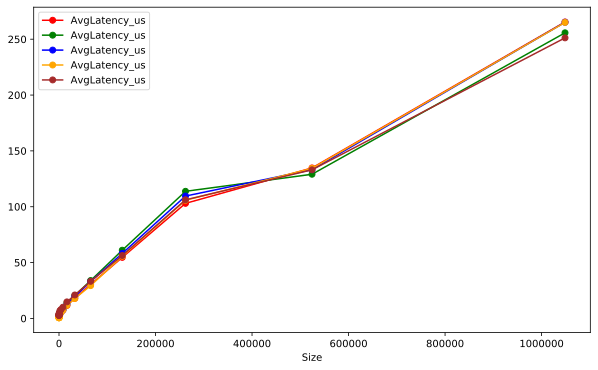

In [92]:
skl_bcast_n4_p12 = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/bcast_skylake_n4_ppn3_t12.csv")
skl_bcast_n4_p12 = skl_bcast_n4_p12.groupby("Size").mean().reset_index()

skl_bcast_n5_p13 = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/bcast_skylake_n5_ppn3_t13.csv")
skl_bcast_n5_p13 = skl_bcast_n5_p13.groupby("Size").mean().reset_index()

skl_bcast_n6_p14 = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/bcast_skylake_n6_ppn3_t14.csv")
skl_bcast_n6_p14 = skl_bcast_n6_p14.groupby("Size").mean().reset_index()

skl_bcast_n7_p15 = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/bcast_skylake_n7_ppn3_t15.csv")
skl_bcast_n7_p15 = skl_bcast_n7_p15.groupby("Size").mean().reset_index()

skl_bcast_n8_p16 = pd.read_csv("../../SpMVMicroBenchmark/mpi/Results/bcast_skylake_n8_ppn2_t16.csv")
skl_bcast_n8_p16 = skl_bcast_n8_p16.groupby("Size").mean().reset_index()
size_list = skl_bcast_n8_p16["Size"]

_node= []
_p = []
_lat = []
_s = []
_ppn = []
for msg_s in size_list:
    #     Node:4 and process:12
    _s.append(msg_s)
    _node.append(4)
    _p.append(12)
    _ppn.append(3)
    _lat.append(skl_bcast_n4_p12[skl_bcast_n4_p12["Size"] == msg_s].reset_index()["AvgLatency_us"].iloc[0])

    #     Node:5 and process:13
    _s.append(msg_s)
    _node.append(5)
    _p.append(13)
    _ppn.append(3)
    _lat.append(skl_bcast_n5_p13[skl_bcast_n5_p13["Size"] == msg_s].reset_index()["AvgLatency_us"].iloc[0])
    
    #     Node:4 and process:12
    _s.append(msg_s)
    _node.append(6)
    _p.append(14)
    _ppn.append(3)
    _lat.append(skl_bcast_n6_p14[skl_bcast_n6_p14["Size"] == msg_s].reset_index()["AvgLatency_us"].iloc[0])
    
    #     Node:4 and process:12
    _s.append(msg_s)
    _node.append(7)
    _p.append(15)
    _ppn.append(3)
    _lat.append(skl_bcast_n7_p15[skl_bcast_n7_p15["Size"] == msg_s].reset_index()["AvgLatency_us"].iloc[0])
    
    #     Node:4 and process:12
    _s.append(msg_s)
    _node.append(8)
    _p.append(16)
    _ppn.append(2)
    _lat.append(skl_bcast_n8_p16[skl_bcast_n8_p16["Size"] == msg_s].reset_index()["AvgLatency_us"].iloc[0])
skl_bcast_data = pd.DataFrame()
skl_bcast_data["Size"] = _s
skl_bcast_data["Nodes"] = _node
skl_bcast_data["Process"] = _p
skl_bcast_data["PPN"] = _ppn
skl_bcast_data["Latency_us"] = _lat
ax1 = skl_bcast_n4_p12.plot(kind="line", x="Size", color="r", y="AvgLatency_us", style="-o", figsize=(10,6))
skl_bcast_n5_p13.plot(kind="line", ax=ax1, x="Size", color="g", y="AvgLatency_us", style="-o", figsize=(10,6))
skl_bcast_n6_p14.plot(kind="line", ax=ax1, x="Size", color="b", y="AvgLatency_us", style="-o", figsize=(10,6))
skl_bcast_n7_p15.plot(kind="line", ax=ax1, x="Size", color="orange", y="AvgLatency_us", style="-o", figsize=(10,6))
skl_bcast_n8_p16.plot(kind="line", ax=ax1, x="Size", color="brown", y="AvgLatency_us", style="-o", figsize=(10,6))
skl_bcast_data

# CSR (2D and GK) Cache Friendliness

In [93]:
cache_data = pd.read_csv("../../ShMemGraph/src/util/Results/CACHE_FRIENDLINESS.csv")
cache_data = cache_data.groupby(["FileName", "Process", "Rank", "DataType", "CacheType", "Architecture"]).mean().reset_index()
kway_cache_data = cache_data[cache_data["FileName"].isin(test_matrices)].reset_index(drop=True)
random_cache_data = cache_data[cache_data["FileName"].isin(random_test_matrices)].reset_index(drop=True)
kway_L3_data = kway_cache_data[(kway_cache_data["CacheType"] == "L3") & (kway_cache_data["Architecture"] == "Skylake")]
rand_L3_data = random_cache_data[(random_cache_data["CacheType"] == "L3") & (random_cache_data["Architecture"] == "Skylake")]

TestMatL3Cache = pd.DataFrame()
_mat = []
_p = []
_miss = []
_hit = []
_rpn = []
_nnnzpn = []
_avg_row = []
_avg_nnz = []
_access = []
for p,p_data in rand_L3_data.groupby(["Process"]):
    for f,data in p_data.groupby(["FileName"]):
        ppn = 36
        data = data.reset_index()
        prcs = p
        node = int(prcs/ppn)
        if len(data) < ppn:
            print("******* ", f, " does not has sufficient data for process: ", p, " *******")
            continue
        _mat.append(random_to_org_map[f])
        _avg_nnz.append(data["NNZ"].mean())
        _avg_row.append(data["Vtx"].mean())
        _p.append(p)
        prcs = ppn*node
        if prcs > len(data):
            print(f, " not fully done! [found", len(data), "of", prcs, "] for process: ", p)
            node = int(len(data)/ppn)
            prcs = node*ppn
            print("Node count: ", node, " process count: ", prcs)
        data = data.iloc[0:prcs]
        nnz = int(data["NNZ"].sum()/node)

        avg_cache_miss = data["CacheMiss"].sum()
        avg_cache_hit = data["CacheHit"].sum()

        avg_cache_miss = avg_cache_miss/node
        avg_cache_hit = avg_cache_hit/node

        _nnnzpn.append(data["NNZ"].sum()/node)
        _rpn.append(data["Vtx"].sum()/node)
        _miss.append(avg_cache_miss)
        _hit.append(avg_cache_hit)
        _access.append(avg_cache_miss + avg_cache_hit)
    
#     print("Node: ", node, " Process: ", prcs)
#     print(f, ": NNZ: ", nnz, " Avg Cache Miss: ", '{:,.3f}'.format(avg_cache_miss), " Avg Cache Hit: ", '{:,.3f}'.format(avg_cache_hit), " Access: ", int(avg_cache_miss+avg_cache_hit))
TestMatL3Cache["Matrices"] = _mat
TestMatL3Cache["Process"] = _p
TestMatL3Cache["AvgRows"] = _avg_row
TestMatL3Cache["AvgNNZ"] = _avg_nnz
TestMatL3Cache["RowsPerNode"] = _rpn
TestMatL3Cache["NNZPerNode"] = _nnnzpn
TestMatL3Cache["CacheMissPerNode"] = _miss
TestMatL3Cache["CacheHitPerNode"] = _hit
TestMatL3Cache["CacheAccessPerNode"] = _access
TestMatL3Cache


TestKwayMatL3Cache = pd.DataFrame()
_mat = []
_p = []
_miss = []
_hit = []
_rpn = []
_nnnzpn = []
_avg_row = []
_avg_nnz = []
_access = []
for p,p_data in kway_L3_data.groupby(["Process"]):
    for f,data in p_data.groupby(["FileName"]):
        ppn = 36
        data = data.reset_index()
        prcs = p
        node = int(prcs/ppn)
        if len(data) < ppn:
            print("******* ", f, " does not has sufficient kway data for process: ", p, " *******")
            continue
        _mat.append(f)
        _avg_nnz.append(data["NNZ"].mean())
        _avg_row.append(data["Vtx"].mean())
        _p.append(p)
        prcs = ppn*node
        if prcs > len(data):
            print(f, " not fully done! [found", len(data), "of", prcs, "] for process: ", p)
            node = int(len(data)/ppn)
            prcs = node*ppn
            print("Node count: ", node, " process count: ", prcs)
        data = data.iloc[0:prcs]
        nnz = int(data["NNZ"].sum()/node)

        avg_cache_miss = data["CacheMiss"].sum()
        avg_cache_hit = data["CacheHit"].sum()

        avg_cache_miss = avg_cache_miss/node
        avg_cache_hit = avg_cache_hit/node

        _nnnzpn.append(data["NNZ"].sum()/node)
        _rpn.append(data["Vtx"].sum()/node)
        _miss.append(avg_cache_miss)
        _hit.append(avg_cache_hit)
        _access.append(avg_cache_miss + avg_cache_hit)
    
#     print("Node: ", node, " Process: ", prcs)
#     print(f, ": NNZ: ", nnz, " Avg Cache Miss: ", '{:,.3f}'.format(avg_cache_miss), " Avg Cache Hit: ", '{:,.3f}'.format(avg_cache_hit), " Access: ", int(avg_cache_miss+avg_cache_hit))
TestKwayMatL3Cache["Matrices"] = _mat
TestKwayMatL3Cache["Process"] = _p
TestKwayMatL3Cache["AvgRows"] = _avg_row
TestKwayMatL3Cache["AvgNNZ"] = _avg_nnz
TestKwayMatL3Cache["RowsPerNode"] = _rpn
TestKwayMatL3Cache["NNZPerNode"] = _nnnzpn
TestKwayMatL3Cache["CacheMissPerNode"] = _miss
TestKwayMatL3Cache["CacheHitPerNode"] = _hit
TestKwayMatL3Cache["CacheAccessPerNode"] = _access
TestKwayMatL3Cache


,Matrices,Process,AvgRows,AvgNNZ,RowsPerNode,NNZPerNode,CacheMissPerNode,CacheHitPerNode,CacheAccessPerNode
0,333SP,144,25783.437500,1.542866e+05,9.282038e+05,5.554316e+06,6.905425e+04,5.485262e+06,5.554316e+06
1,AS365,144,26383.854167,1.578899e+05,9.498188e+05,5.684038e+06,7.517325e+04,5.608865e+06,5.684038e+06
2,M6,144,24317.888889,1.458602e+05,8.754440e+05,5.250968e+06,7.053250e+04,5.180436e+06,5.250968e+06
3,NLR,144,28915.020833,1.734441e+05,1.040941e+06,6.243988e+06,8.256700e+04,6.161421e+06,6.243988e+06
4,hugetrace-00010,144,83732.229167,2.511414e+05,3.014360e+06,9.041090e+06,2.070382e+05,8.834051e+06,9.041090e+06
5,road_central,144,97790.388889,2.351863e+05,3.520454e+06,8.466706e+06,2.244688e+05,8.242238e+06,8.466706e+06
6,road_usa,144,166301.020833,4.007543e+05,5.986837e+06,1.442716e+07,3.784668e+05,1.404869e+07,1.442716e+07
7,333SP,169,21969.319527,1.314631e+05,7.926078e+05,4.740976e+06,5.932675e+04,4.681649e+06,4.740976e+06
8,AS365,169,22480.917160,1.345334e+05,8.099950e+05,4.850331e+06,6.552025e+04,4.784810e+06,4.850331e+06
9,M6,169,20720.568047,1.242833e+05,7.458615e+05,4.473610e+06,6.138500e+04,4.412225e+06,4.473610e+06


# COO (2D and GK) Cache Friendliness

In [191]:
coo_cache_data = pd.read_csv("../../ShMemGraph/src/util/Results/CACHE_FRIENDLINESS_COO.csv")
coo_cache_data = coo_cache_data.groupby(["FileName", "Array", "Process", "Rank", "DataType", "CacheType", "Architecture"]).mean().reset_index()
coo_kway_cache_data = coo_cache_data[coo_cache_data["FileName"].isin(test_matrices)].reset_index(drop=True)
coo_random_cache_data = coo_cache_data[coo_cache_data["FileName"].isin(random_test_matrices)].reset_index(drop=True)
coo_kway_L3_data = coo_kway_cache_data[(coo_kway_cache_data["CacheType"] == "L3") & (coo_kway_cache_data["Architecture"] == "Skylake")].reset_index(drop=True)
coo_rand_L3_data = coo_random_cache_data[(coo_random_cache_data["CacheType"] == "L3") & (coo_random_cache_data["Architecture"] == "Skylake")].reset_index(drop=True)

COOTestMatL3Cache = pd.DataFrame()
_mat = []
_p = []
_a = []
_miss = []
_hit = []
_rpn = []
_nnnzpn = []
_avg_row = []
_avg_nnz = []
_access = []
for p,p_data in coo_rand_L3_data.groupby(["Process"]):
    for a,a_data in p_data.groupby(["Array"]):
        for f,data in a_data.groupby(["FileName"]):
            ppn = 36
            data = data.reset_index()
            prcs = p
            node = int(prcs/ppn)
            if len(data) < ppn:
                print("******* ", f, " does not has sufficient data for process: ", p, " array: ", a, " *******")
                continue
            _mat.append(random_to_org_map[f])
            _avg_nnz.append(data["NNZ"].mean())
            _avg_row.append(data["Vtx"].mean())
            _p.append(p)
            _a.append(a)
            prcs = ppn*node
            if prcs > len(data):
                print(f, " not fully done! [found", len(data), "of", prcs, "] for process: ", p, " array: ", a)
                node = int(len(data)/ppn)
                prcs = node*ppn
                print("Node count: ", node, " process count: ", prcs)
            data = data.iloc[0:prcs]
            nnz = int(data["NNZ"].sum()/node)

            avg_cache_miss = data["CacheMiss"].sum()
            avg_cache_hit = data["CacheHit"].sum()

            avg_cache_miss = avg_cache_miss/node
            avg_cache_hit = avg_cache_hit/node

            _nnnzpn.append(data["NNZ"].sum()/node)
            _rpn.append(data["Vtx"].sum()/node)
            _miss.append(avg_cache_miss)
            _hit.append(avg_cache_hit)
            _access.append(avg_cache_miss + avg_cache_hit)
    
#     print("Node: ", node, " Process: ", prcs)
#     print(f, ": NNZ: ", nnz, " Avg Cache Miss: ", '{:,.3f}'.format(avg_cache_miss), " Avg Cache Hit: ", '{:,.3f}'.format(avg_cache_hit), " Access: ", int(avg_cache_miss+avg_cache_hit))
COOTestMatL3Cache["Matrices"] = _mat
COOTestMatL3Cache["Array"] = _a
COOTestMatL3Cache["Process"] = _p
COOTestMatL3Cache["AvgRows"] = _avg_row
COOTestMatL3Cache["AvgNNZ"] = _avg_nnz
COOTestMatL3Cache["RowsPerNode"] = _rpn
COOTestMatL3Cache["NNZPerNode"] = _nnnzpn
COOTestMatL3Cache["CacheMissPerNode"] = _miss
COOTestMatL3Cache["CacheHitPerNode"] = _hit
COOTestMatL3Cache["CacheAccessPerNode"] = _access
COOTestMatL3Cache


COOTestKwayMatL3Cache = pd.DataFrame()
_mat = []
_p = []
_a = []
_miss = []
_hit = []
_rpn = []
_nnnzpn = []
_avg_row = []
_avg_nnz = []
_access = []
for p,p_data in coo_kway_L3_data.groupby(["Process"]):
    for a,a_data in p_data.groupby(["Array"]):
        for f,data in a_data.groupby(["FileName"]):
            ppn = 36
            data = data.reset_index()
            prcs = p
            node = int(prcs/ppn)
            if len(data) < ppn:
                print("******* ", f, " does not has sufficient data for process: ", p, " array: ", a, " *******")
                continue
            _mat.append(f)
            _avg_nnz.append(data["NNZ"].mean())
            _avg_row.append(data["Vtx"].mean())
            _p.append(p)
            _a.append(a)
            prcs = ppn*node
            if prcs > len(data):
                print(f, " not fully done! [found", len(data), "of", prcs, "] for process: ", p, " array: ", a)
                node = int(len(data)/ppn)
                prcs = node*ppn
                print("Node count: ", node, " process count: ", prcs)
            data = data.iloc[0:prcs]
            nnz = int(data["NNZ"].sum()/node)

            avg_cache_miss = data["CacheMiss"].sum()
            avg_cache_hit = data["CacheHit"].sum()

            avg_cache_miss = avg_cache_miss/node
            avg_cache_hit = avg_cache_hit/node

            _nnnzpn.append(data["NNZ"].sum()/node)
            _rpn.append(data["Vtx"].sum()/node)
            _miss.append(avg_cache_miss)
            _hit.append(avg_cache_hit)
            _access.append(avg_cache_miss + avg_cache_hit)
    
#     print("Node: ", node, " Process: ", prcs)
#     print(f, ": NNZ: ", nnz, " Avg Cache Miss: ", '{:,.3f}'.format(avg_cache_miss), " Avg Cache Hit: ", '{:,.3f}'.format(avg_cache_hit), " Access: ", int(avg_cache_miss+avg_cache_hit))
COOTestKwayMatL3Cache["Matrices"] = _mat
COOTestKwayMatL3Cache["Array"] = _a
COOTestKwayMatL3Cache["Process"] = _p
COOTestKwayMatL3Cache["AvgRows"] = _avg_row
COOTestKwayMatL3Cache["AvgNNZ"] = _avg_nnz
COOTestKwayMatL3Cache["RowsPerNode"] = _rpn
COOTestKwayMatL3Cache["NNZPerNode"] = _nnnzpn
COOTestKwayMatL3Cache["CacheMissPerNode"] = _miss
COOTestKwayMatL3Cache["CacheHitPerNode"] = _hit
COOTestKwayMatL3Cache["CacheAccessPerNode"] = _access
COOTestKwayMatL3Cache

road_usa_random  not fully done! [found 221 of 252 ] for process:  256  array:  ColA
Node count:  6  process count:  216
road_usa_random  not fully done! [found 221 of 252 ] for process:  256  array:  RowA
Node count:  6  process count:  216


,Matrices,Array,Process,AvgRows,AvgNNZ,RowsPerNode,NNZPerNode,CacheMissPerNode,CacheHitPerNode,CacheAccessPerNode
0,333SP,ColA,144,25783.437500,154286.569444,9.282038e+05,5.554316e+06,69054.250000,5.485262e+06,5.554316e+06
1,AS365,ColA,144,26383.854167,157889.944444,9.498188e+05,5.684038e+06,75173.250000,5.608865e+06,5.684038e+06
2,M6,ColA,144,24317.888889,145860.222222,8.754440e+05,5.250968e+06,70532.500000,5.180436e+06,5.250968e+06
3,NLR,ColA,144,28915.020833,173444.111111,1.040941e+06,6.243988e+06,82567.000000,6.161421e+06,6.243988e+06
4,hugetrace-00010,ColA,144,83732.229167,251141.375000,3.014360e+06,9.041090e+06,207038.250000,8.834051e+06,9.041090e+06
5,road_central,ColA,144,97790.388889,235186.291667,3.520454e+06,8.466706e+06,224468.750000,8.242238e+06,8.466706e+06
6,road_usa,ColA,144,166301.020833,400754.333333,5.986837e+06,1.442716e+07,378466.750000,1.404869e+07,1.442716e+07
7,333SP,RowA,144,25783.437500,154286.569444,9.282038e+05,5.554316e+06,58028.000000,5.496288e+06,5.554316e+06
8,AS365,RowA,144,26383.854167,157889.944444,9.498188e+05,5.684038e+06,59379.750000,5.624658e+06,5.684038e+06
9,M6,RowA,144,24317.888889,145860.222222,8.754440e+05,5.250968e+06,54730.750000,5.196237e+06,5.250968e+06


# Memory Access Model on Skylake(Single Precision)

# Prepare CSR 2D SpMV Data

In [195]:
csr_2d_spmv = pd.read_csv("../../SpMV_Model/src/SkylakeResults/MPI_CSR_2D_SpMV.csv")
csr_2d_spmv = csr_2d_spmv[~csr_2d_spmv['Name'].str.contains("rmat")].reset_index(drop=True)
csr_2d_ref = csr_2d_spmv[["Name", "Nodes", "nProcess", "DataType", "AvgRow", "NNZ", "NonZeroPerRow", "AvgNPRSD", "AvgTime", "AvgBcastTime", "AvgMatmulTime", "AvgReduceTime"]]
csr_2d_ref = csr_2d_ref.groupby(["Name", "Nodes", "nProcess", "DataType"]).mean().reset_index().sort_values(by=["Name", "Nodes", "nProcess", "DataType"]).reset_index(drop=True)
csr_2d_test = pd.DataFrame()
csr_2d_test["Name"] = csr_2d_ref["Name"]
csr_2d_test["Nodes"] = csr_2d_ref["Nodes"]
csr_2d_test["nProcess"] = csr_2d_ref["nProcess"]
csr_2d_test["AvgRow"] = csr_2d_ref["AvgRow"]
csr_2d_test["NonZeroPerRow"] = csr_2d_ref["NonZeroPerRow"]
csr_2d_test["NNZ"] = csr_2d_ref["NNZ"]
csr_2d_test["AvgTime"] = csr_2d_ref["AvgTime"]/1000
csr_2d_test["AvgBcastTime"] = csr_2d_ref["AvgBcastTime"]/1000
csr_2d_test["AvgMatmulTime"] = csr_2d_ref["AvgMatmulTime"]/1000
csr_2d_test["AvgReduceTime"] = csr_2d_ref["AvgReduceTime"]/1000
csr_2d_test["Size"] = 36*((12*csr_2d_ref["AvgRow"]) + (8*csr_2d_ref["NNZ"])) 
csr_2d_test["BcastSize"] = 4*csr_2d_ref["AvgRow"]
csr_2d_test["ReduceSize"] = 4*csr_2d_ref["AvgRow"]
csr_2d_test = csr_2d_test[csr_2d_test["Size"] >= 100000000].reset_index(drop=True).sort_values(by="AvgRow").reset_index(drop=True)
VEC_WIDTH = 4
FLOPS_PER_CAL = 2
FLOP_PER_SEC = 42.84
csr_2d_test["TimeForFLOPS"] = (1.0e-9 * csr_2d_test["NNZ"] * VEC_WIDTH * FLOPS_PER_CAL)/FLOP_PER_SEC
csr_2d_test = csr_2d_test[csr_2d_test["Name"].isin(test_matrices)].reset_index(drop=True)

_miss = []
_hit = []
_access = []

for i,r in csr_2d_test.iterrows():
    cache_data = TestMatL3Cache[(TestMatL3Cache["Matrices"] == r["Name"]) & (TestMatL3Cache["Process"] == r["nProcess"])].reset_index(drop=True)
    if cache_data.shape[0] <= 0:
        print("Cache data not available for ", r["Name"], r["nProcess"])
        _miss.append(0)
        _hit.append(0)
        _access.append(0)
        continue
    _miss.append(cache_data["CacheMissPerNode"].iloc[0]*4)
    _hit.append(cache_data["CacheHitPerNode"].iloc[0]*4)
    _access.append(cache_data["CacheAccessPerNode"].iloc[0]*4)
csr_2d_test["CacheMissPerNode"] = _miss
csr_2d_test["CacheHitPerNode"] = _hit
csr_2d_test["CacheAccessPerNode"] = _access

csr_2d_test["SeqSize"] = csr_2d_test["Size"] + csr_2d_test["CacheHitPerNode"]
csr_2d_test["RandomSize"] = csr_2d_test["CacheMissPerNode"]
csr_2d_test

,Name,Nodes,nProcess,AvgRow,NonZeroPerRow,NNZ,AvgTime,AvgBcastTime,AvgMatmulTime,AvgReduceTime,Size,BcastSize,ReduceSize,TimeForFLOPS,CacheMissPerNode,CacheHitPerNode,CacheAccessPerNode,SeqSize,RandomSize
0,M6,8,256,218861,0.374879,82046,0.003967,0.000958,0.001573,0.001435,118177200,875444,875444,0.000015,3.134678e+06,8.680141e+06,1.181482e+07,1.268573e+08,3.134678e+06
1,333SP,8,256,232051,0.373996,86786,0.004235,0.001019,0.001692,0.001525,125240400,928204,928204,0.000016,3.749885e+06,8.747425e+06,1.249731e+07,1.339878e+08,3.749885e+06
2,M6,7,225,233452,0.399870,93350,0.004356,0.001021,0.001761,0.001573,127736064,933808,933808,0.000017,4.015929e+06,9.426485e+06,1.344241e+07,1.371625e+08,4.015929e+06
3,AS365,8,256,237455,0.374021,88813,0.004371,0.001043,0.001738,0.001590,128158704,949820,949820,0.000017,4.006044e+06,8.783337e+06,1.278938e+07,1.369420e+08,4.006044e+06
4,333SP,7,225,247521,0.398929,98743,0.004739,0.001087,0.001894,0.001759,135367056,990084,990084,0.000018,4.743762e+06,9.475434e+06,1.421920e+07,1.448425e+08,4.743762e+06
5,AS365,7,225,253285,0.398956,101049,0.004683,0.001113,0.001949,0.001620,138521232,1013140,1013140,0.000019,5.046069e+06,9.504933e+06,1.455100e+07,1.480262e+08,5.046069e+06
6,NLR,8,256,260236,0.374899,97562,0.004813,0.001150,0.001960,0.001703,140519808,1040944,1040944,0.000018,5.134838e+06,8.913890e+06,1.404873e+07,1.494337e+08,5.134838e+06
7,M6,5,169,269368,0.461388,124283,0.005272,0.001066,0.002478,0.001727,152160480,1077472,1077472,0.000023,6.712645e+06,1.118448e+07,1.789713e+07,1.633450e+08,6.712645e+06
8,NLR,7,225,277585,0.399893,111004,0.005410,0.001224,0.002416,0.001770,151885872,1110340,1110340,0.000021,6.361668e+06,9.623634e+06,1.598530e+07,1.615095e+08,6.361668e+06
9,333SP,5,169,285602,0.460302,131463,0.005701,0.001134,0.002751,0.001816,161241408,1142408,1142408,0.000025,7.721183e+06,1.120866e+07,1.892984e+07,1.724501e+08,7.721183e+06


# Predict CSR 2D SpMV model Based on STREAM 

In [196]:
skylake_res = pd.read_csv("../../STREAM/Results/SKYLAKE.csv")

dp_copy = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
dp_copy = dp_copy[dp_copy["Size"] >= 1000000000]
dp_copy = dp_copy.groupby("Size").mean().reset_index().sort_values(by="Size").reset_index()


dp_random_copy = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
dp_random_copy = dp_random_copy[dp_random_copy["Size"] >= 1000000000]
dp_random_copy = dp_random_copy.groupby("Size").mean().reset_index().sort_values(by="Size").reset_index()


_bandwidth = dp_copy["Bandwidth_MBS"].mean() * 1.0E06
_random_bandwidth = dp_random_copy["Bandwidth_MBS"].mean() * 1.0E06

csr_2d_matmul_pred = csr_2d_test
csr_2d_matmul_pred["SeqLatency"] = csr_2d_test["SeqSize"] /(_bandwidth)
csr_2d_matmul_pred["RandomLatency"] = csr_2d_test["RandomSize"] /(_random_bandwidth)
csr_2d_matmul_pred["PredictedTime"] = csr_2d_matmul_pred["SeqLatency"] + csr_2d_matmul_pred["RandomLatency"]
csr_2d_matmul_pred["Error"] = ((csr_2d_test["AvgMatmulTime"] - csr_2d_matmul_pred["PredictedTime"])/csr_2d_test["AvgMatmulTime"])*100
csr_2d_matmul_pred = csr_2d_matmul_pred.sort_values(by=["Name", "nProcess"]).reset_index(drop=True)
for i,r in csr_2d_matmul_pred.iterrows():
    print(r["Name"], " & ", r["Nodes"], " & ", r["nProcess"], " & ", '{0:,.2E}'.format(r["AvgMatmulTime"]), " & ", '{0:,.2E}'.format(r["PredictedTime"]), " & ", '{0:,.1f}'.format(abs(r["Error"])), " \\\\ \hline")
    
print("Max error: ", abs(csr_2d_matmul_pred["Error"]).max(), " Avg Error: ", abs(csr_2d_matmul_pred["Error"]).mean())

333SP  &  4  &  144  &  3.20E-03  &  3.76E-03  &  17.5  \\ \hline
333SP  &  5  &  169  &  2.75E-03  &  3.10E-03  &  12.7  \\ \hline
333SP  &  7  &  225  &  1.89E-03  &  2.20E-03  &  16.1  \\ \hline
333SP  &  8  &  256  &  1.69E-03  &  1.88E-03  &  11.4  \\ \hline
AS365  &  4  &  144  &  3.29E-03  &  3.91E-03  &  18.9  \\ \hline
AS365  &  5  &  169  &  2.83E-03  &  3.23E-03  &  14.0  \\ \hline
AS365  &  7  &  225  &  1.95E-03  &  2.29E-03  &  17.6  \\ \hline
AS365  &  8  &  256  &  1.74E-03  &  1.97E-03  &  13.1  \\ \hline
M6  &  4  &  144  &  2.98E-03  &  3.40E-03  &  14.2  \\ \hline
M6  &  5  &  169  &  2.48E-03  &  2.80E-03  &  12.9  \\ \hline
M6  &  7  &  225  &  1.76E-03  &  1.97E-03  &  11.9  \\ \hline
M6  &  8  &  256  &  1.57E-03  &  1.69E-03  &  7.2  \\ \hline
NLR  &  4  &  144  &  3.67E-03  &  4.54E-03  &  23.6  \\ \hline
NLR  &  5  &  169  &  3.18E-03  &  3.77E-03  &  18.5  \\ \hline
NLR  &  7  &  225  &  2.42E-03  &  2.70E-03  &  11.8  \\ \hline
NLR  &  8  &  256  &  1.96E-0

# CSR MPI Communication

# MPI Broadcast

In [110]:
csr_2d_spmv = pd.read_csv("../../SpMV_Model/src/SkylakeResults/MPI_CSR_2D_SpMV.csv")
csr_2d_spmv = csr_2d_spmv[~csr_2d_spmv['Name'].str.contains("rmat")].reset_index(drop=True)
csr_2d_spmv = csr_2d_spmv.groupby(["Name", "Nodes", "nProcess", "DataType"]).mean().reset_index().sort_values(by="Name").reset_index()

csr_2d_bcast_data = csr_2d_spmv[csr_2d_spmv["DataType"] == 4][["Name", "MatrixSize", "AvgRow", "NNZ", "NonZeroPerRow", "AvgNPRSD", "Nodes", "nProcess", "DataType", "AvgBcastTime"]].sort_values(by="AvgRow").reset_index(drop=True)
csr_2d_bcast_data = csr_2d_bcast_data.sort_values(by=["AvgRow", "NonZeroPerRow"]).reset_index(drop=True)

density = []
min_time_factor = 1.0
if min(csr_2d_bcast_data["AvgBcastTime"]) < 1.0:
    min_time_factor = 1/min(csr_2d_bcast_data["AvgBcastTime"])
for i,r in csr_2d_bcast_data.iterrows():
    csr_2d_bcast_data.at[i, "AvgBcastTime"] = min_time_factor*r["AvgBcastTime"]
    density.append(float(r["NNZ"])/float(r["AvgRow"] * r["AvgRow"]))
csr_2d_bcast_data["Density"] = density

csr_2d_train_data = csr_2d_bcast_data[~csr_2d_bcast_data["Name"].isin(test_matrices)].reset_index(drop=True)
csr_2d_test_data = csr_2d_bcast_data[csr_2d_bcast_data["Name"].isin(test_matrices)].reset_index(drop=True)

# attributes = ["AvgRow", "NNZ", "NonZeroPerRow", "AvgNPRSD", "Density", "Nodes", "nProcess"]
attributes = ["AvgRow", "NNZ", "Nodes", "nProcess"]
csr_2d_train = csr_2d_train_data[attributes].to_numpy()
csr_2d_test = csr_2d_test_data[attributes].to_numpy()
column = "AvgBcastTime"

csr_2d_X = np.concatenate((csr_2d_train, csr_2d_test), axis=0)
scaler = MinMaxScaler()  # Default behavior is to scale to [0,1]
csr_2d_X = scaler.fit_transform(csr_2d_X)
X = csr_2d_X[0:len(csr_2d_train)]
csr_2d_test_X = csr_2d_X[len(csr_2d_train):]
train_y = np.array(csr_2d_train_data[column])
test_y = np.array(csr_2d_test_data[column])

# best_param = _train_model(X, train_y)
csr_2d_bcast_best_param = {"C" : 58000, "epsilon": 0.1}
svr_model = SVR(kernel='poly', C=csr_2d_bcast_best_param['C'], gamma='auto', degree=3, epsilon=csr_2d_bcast_best_param['epsilon'], coef0=1)
svr_model.fit(X, train_y)
y_pred = svr_model.predict(csr_2d_test_X)


csr_dyn_2d_bcast_pred = pd.DataFrame()
mat = [] 
node = []
prcs = []
rows = []
nnz_r = []
a_time = []
p_time = []
err = []
spmv_model = []
m_size = []

max_err = 0
avg_err = 0
for i,row in csr_2d_test_data.iterrows():
#     print(y[index])
#     g = row["Name"].split("_")
    print(row["Name"], "&", '{0:.3E}'.format(test_y[i]/min_time_factor),"&",'{0:.3E}'.format(y_pred[i]/min_time_factor), "&", 
          '{0:,.2}'.format(abs(test_y[i]-y_pred[i])*100/test_y[i])+"\\%", "\\\ \hline")           
    
    mat.append(row["Name"])
    node.append(row["Nodes"])
    prcs.append(row["nProcess"])
    rows.append(row["AvgRow"])
    nnz_r.append(row["NonZeroPerRow"])
    a_time.append(float('{0:.3E}'.format(test_y[i]/min_time_factor)))
    p_time.append(float('{0:.3E}'.format(y_pred[i]/min_time_factor)))
    err.append(float('{0:,.2}'.format(abs(test_y[i]-y_pred[i])*100/test_y[i])))
    spmv_model.append("CSR 2D Partition")
    m_size.append(row["MatrixSize"])
csr_dyn_2d_bcast_pred["Name"] = mat
csr_dyn_2d_bcast_pred["Model"] = spmv_model
csr_dyn_2d_bcast_pred["Nodes"] = node
csr_dyn_2d_bcast_pred["Process"] = prcs
csr_dyn_2d_bcast_pred["Matrix Size"] = m_size
csr_dyn_2d_bcast_pred["Avg Row"] = rows
csr_dyn_2d_bcast_pred["Nonzero per Row"] = nnz_r
csr_dyn_2d_bcast_pred["Actual Time"] = a_time
csr_dyn_2d_bcast_pred["Predicted Time"] = p_time
csr_dyn_2d_bcast_pred["Error"] = err

print("max error: ", csr_dyn_2d_bcast_pred["Error"].max(), " avg error: ", csr_dyn_2d_bcast_pred["Error"].mean())

M6 & 9.584E-01 & 9.908E-01 & 3.4\% \\ \hline
333SP & 1.019E+00 & 1.050E+00 & 3.0\% \\ \hline
M6 & 1.021E+00 & 1.065E+00 & 4.3\% \\ \hline
AS365 & 1.043E+00 & 1.074E+00 & 2.9\% \\ \hline
333SP & 1.087E+00 & 1.127E+00 & 3.7\% \\ \hline
AS365 & 1.113E+00 & 1.152E+00 & 3.5\% \\ \hline
NLR & 1.150E+00 & 1.176E+00 & 2.3\% \\ \hline
M6 & 1.066E+00 & 1.248E+00 & 1.7e+01\% \\ \hline
NLR & 1.224E+00 & 1.259E+00 & 2.9\% \\ \hline
333SP & 1.134E+00 & 1.322E+00 & 1.6e+01\% \\ \hline
M6 & 1.613E+00 & 1.429E+00 & 1.1e+01\% \\ \hline
AS365 & 1.162E+00 & 1.352E+00 & 1.6e+01\% \\ \hline
333SP & 1.716E+00 & 1.513E+00 & 1.2e+01\% \\ \hline
AS365 & 1.752E+00 & 1.547E+00 & 1.2e+01\% \\ \hline
NLR & 1.282E+00 & 1.479E+00 & 1.5e+01\% \\ \hline
NLR & 1.924E+00 & 1.690E+00 & 1.2e+01\% \\ \hline
hugetrace-00010 & 3.423E+00 & 3.430E+00 & 0.2\% \\ \hline
hugetrace-00010 & 3.633E+00 & 3.580E+00 & 1.5\% \\ \hline
road_central & 3.998E+00 & 4.018E+00 & 0.49\% \\ \hline
hugetrace-00010 & 3.449E+00 & 4.119E+00 & 1.9e+0

# MPI Reduce

In [111]:
csr_2d_spmv = pd.read_csv("../../SpMV_Model/src/SkylakeResults/MPI_CSR_2D_SpMV.csv")
csr_2d_spmv = csr_2d_spmv[~csr_2d_spmv['Name'].str.contains("rmat")].reset_index(drop=True)
csr_2d_spmv = csr_2d_spmv.groupby(["Name", "Nodes", "nProcess", "DataType"]).mean().reset_index().sort_values(by="Name").reset_index()

csr_2d_reduce_data = csr_2d_spmv[csr_2d_spmv["DataType"] == 4][["Name", "MatrixSize", "AvgRow", "NNZ", "NonZeroPerRow", "AvgNPRSD", "Nodes", "nProcess", "DataType", "AvgReduceTime"]].sort_values(by="AvgRow").reset_index(drop=True)
csr_2d_reduce_data = csr_2d_reduce_data.sort_values(by=["AvgRow", "NonZeroPerRow"]).reset_index(drop=True)

density = []
column = "AvgReduceTime"
min_time_factor = 1.0
if min(csr_2d_reduce_data[column]) < 1.0:
    min_time_factor = 1/min(csr_2d_reduce_data[column])
for i,r in csr_2d_reduce_data.iterrows():
    csr_2d_reduce_data.at[i, column] = min_time_factor*r[column]
    density.append(float(r["NNZ"])/float(r["AvgRow"] * r["AvgRow"]))
csr_2d_reduce_data["Density"] = density

csr_2d_train_data = csr_2d_reduce_data[~csr_2d_reduce_data["Name"].isin(test_matrices)].reset_index(drop=True)
csr_2d_test_data = csr_2d_reduce_data[csr_2d_reduce_data["Name"].isin(test_matrices)].reset_index(drop=True)


# attributes = ["AvgRow", "NNZ", "NonZeroPerRow", "AvgNPRSD", "Density", "Nodes", "nProcess"]
attributes = ["AvgRow", "NNZ", "Nodes", "nProcess"]
csr_2d_train = csr_2d_train_data[attributes].to_numpy()
csr_2d_test = csr_2d_test_data[attributes].to_numpy()


csr_2d_X = np.concatenate((csr_2d_train, csr_2d_test), axis=0)
scaler = MinMaxScaler()  # Default behavior is to scale to [0,1]
csr_2d_X = scaler.fit_transform(csr_2d_X)
X = csr_2d_X[0:len(csr_2d_train)]
csr_2d_test_X = csr_2d_X[len(csr_2d_train):]
train_y = np.array(csr_2d_train_data[column])
test_y = np.array(csr_2d_test_data[column])

# best_param = _train_model(X, train_y)
csr_2d_reduce_best_param = {"C" : 4000, "epsilon": 0.1}
svr_model = SVR(kernel='poly', C=csr_2d_reduce_best_param['C'], gamma='auto', degree=3, epsilon=csr_2d_reduce_best_param['epsilon'], coef0=1)
svr_model.fit(X, train_y)
y_pred = svr_model.predict(csr_2d_test_X)


csr_dyn_2d_reduce_pred = pd.DataFrame()
mat = [] 
node = []
prcs = []
rows = []
nnz_r = []
a_time = []
p_time = []
err = []
spmv_model = []
m_size = []

max_err = 0
avg_err = 0
for i,row in csr_2d_test_data.iterrows():
#     print(y[index])
#     g = row["Name"].split("_")
    print(row["Name"], "&", '{0:.3E}'.format(test_y[i]/min_time_factor),"&",'{0:.3E}'.format(y_pred[i]/min_time_factor), "&", 
          '{0:,.2}'.format(abs(test_y[i]-y_pred[i])*100/test_y[i])+"\\%", "\\\ \hline")           
    
    mat.append(row["Name"])
    node.append(row["Nodes"])
    prcs.append(row["nProcess"])
    rows.append(row["AvgRow"])
    nnz_r.append(row["NonZeroPerRow"])
    a_time.append(float('{0:.3E}'.format(test_y[i]/min_time_factor)))
    p_time.append(float('{0:.3E}'.format(y_pred[i]/min_time_factor)))
    err.append(float('{0:,.2}'.format(abs(test_y[i]-y_pred[i])*100/test_y[i])))
    spmv_model.append("CSR 2D Partition")
    m_size.append(row["MatrixSize"])
csr_dyn_2d_reduce_pred["Name"] = mat
csr_dyn_2d_reduce_pred["Model"] = spmv_model
csr_dyn_2d_reduce_pred["Nodes"] = node
csr_dyn_2d_reduce_pred["Process"] = prcs
csr_dyn_2d_reduce_pred["Matrix Size"] = m_size
csr_dyn_2d_reduce_pred["Avg Row"] = rows
csr_dyn_2d_reduce_pred["Nonzero per Row"] = nnz_r
csr_dyn_2d_reduce_pred["Actual Time"] = a_time
csr_dyn_2d_reduce_pred["Predicted Time"] = p_time
csr_dyn_2d_reduce_pred["Error"] = err

print("max error: ", csr_dyn_2d_reduce_pred["Error"].max(), " avg error: ", csr_dyn_2d_reduce_pred["Error"].mean())

M6 & 1.435E+00 & 1.474E+00 & 2.7\% \\ \hline
333SP & 1.525E+00 & 1.560E+00 & 2.3\% \\ \hline
M6 & 1.573E+00 & 1.730E+00 & 9.9\% \\ \hline
AS365 & 1.590E+00 & 1.596E+00 & 0.36\% \\ \hline
333SP & 1.759E+00 & 1.829E+00 & 4.0\% \\ \hline
AS365 & 1.620E+00 & 1.870E+00 & 1.5e+01\% \\ \hline
NLR & 1.703E+00 & 1.746E+00 & 2.5\% \\ \hline
M6 & 1.727E+00 & 2.020E+00 & 1.7e+01\% \\ \hline
NLR & 1.770E+00 & 2.042E+00 & 1.5e+01\% \\ \hline
333SP & 1.816E+00 & 2.138E+00 & 1.8e+01\% \\ \hline
M6 & 2.185E+00 & 2.129E+00 & 2.6\% \\ \hline
AS365 & 1.850E+00 & 2.186E+00 & 1.8e+01\% \\ \hline
333SP & 2.314E+00 & 2.251E+00 & 2.7\% \\ \hline
AS365 & 2.372E+00 & 2.302E+00 & 3.0\% \\ \hline
NLR & 2.017E+00 & 2.390E+00 & 1.8e+01\% \\ \hline
NLR & 2.626E+00 & 2.513E+00 & 4.3\% \\ \hline
hugetrace-00010 & 4.538E+00 & 4.848E+00 & 6.8\% \\ \hline
hugetrace-00010 & 6.653E+00 & 5.577E+00 & 1.6e+01\% \\ \hline
road_central & 5.266E+00 & 5.617E+00 & 6.7\% \\ \hline
hugetrace-00010 & 7.881E+00 & 6.576E+00 & 1.7e+01\% 

# Overall CSR 2D Performacne

In [126]:
csr_2d_matmul_pred = csr_2d_matmul_pred.sort_values(by=["Name", "Nodes", "nProcess"]).reset_index(drop=True)
csr_dyn_2d_bcast_pred = csr_dyn_2d_bcast_pred.sort_values(by=["Name", "Nodes", "Process"]).reset_index(drop=True)
csr_dyn_2d_reduce_pred = csr_dyn_2d_reduce_pred.sort_values(by=["Name", "Nodes", "Process"]).reset_index(drop=True)
csr_2d_matmul_pred["BcastPredictedTime"] = csr_dyn_2d_bcast_pred["Predicted Time"]/1000
csr_2d_matmul_pred["ReducePredictedTime"] = csr_dyn_2d_reduce_pred["Predicted Time"]/1000
csr_2d_matmul_pred["TotalPredictedTime"] = csr_2d_matmul_pred["PredictedTime"] + csr_2d_matmul_pred["BcastPredictedTime"] + csr_2d_matmul_pred["ReducePredictedTime"]
csr_2d_matmul_pred["TotalError"] = abs(csr_2d_matmul_pred["TotalPredictedTime"] - csr_2d_matmul_pred["AvgTime"])/csr_2d_matmul_pred["AvgTime"]*100
for i,r in csr_2d_matmul_pred.iterrows():
    print(r["Name"], " & ", r["Nodes"], " & ", r["nProcess"], " & ", '{0:,.1E}'.format(r["AvgTime"]), " & ", '{0:,.1E}'.format(r["TotalPredictedTime"]), " & ", '{0:,.1f}'.format(r["TotalError"])+"\% \\\\ \hline")
    
print("Max Error: ", csr_2d_matmul_pred["TotalError"].max(), " Avg Error: ", csr_2d_matmul_pred["TotalError"].mean())  


333SP  &  4  &  144  &  7.2E-03  &  7.5E-03  &  4.1\% \\ \hline
333SP  &  5  &  169  &  5.7E-03  &  6.6E-03  &  15.1\% \\ \hline
333SP  &  7  &  225  &  4.7E-03  &  5.2E-03  &  8.8\% \\ \hline
333SP  &  8  &  256  &  4.2E-03  &  4.5E-03  &  6.1\% \\ \hline
AS365  &  4  &  144  &  7.4E-03  &  7.8E-03  &  4.7\% \\ \hline
AS365  &  5  &  169  &  5.8E-03  &  6.8E-03  &  15.8\% \\ \hline
AS365  &  7  &  225  &  4.7E-03  &  5.3E-03  &  13.5\% \\ \hline
AS365  &  8  &  256  &  4.4E-03  &  4.6E-03  &  6.1\% \\ \hline
M6  &  4  &  144  &  6.8E-03  &  7.0E-03  &  2.7\% \\ \hline
M6  &  5  &  169  &  5.3E-03  &  6.1E-03  &  15.0\% \\ \hline
M6  &  7  &  225  &  4.4E-03  &  4.8E-03  &  9.4\% \\ \hline
M6  &  8  &  256  &  4.0E-03  &  4.2E-03  &  4.7\% \\ \hline
NLR  &  4  &  144  &  8.2E-03  &  8.7E-03  &  6.3\% \\ \hline
NLR  &  5  &  169  &  6.5E-03  &  7.6E-03  &  17.8\% \\ \hline
NLR  &  7  &  225  &  5.4E-03  &  6.0E-03  &  10.9\% \\ \hline
NLR  &  8  &  256  &  4.8E-03  &  5.2E-03  &  9.0\% 

# Prepare COO 2D SpMV Data

In [193]:
coo_2d_spmv = pd.read_csv("../../SpMV_Model/src/SkylakeResults/MPI_COO_2D_SpMV.csv")
coo_2d_spmv = coo_2d_spmv[~coo_2d_spmv['Name'].str.contains("rmat")].reset_index(drop=True)
coo_2d_ref = coo_2d_spmv[["Name", "Nodes", "nProcess", "DataType", "AvgRow", "NNZ", "NonZeroPerRow", "AvgNPRSD", "AvgTime", "AvgBcastTime", "AvgMatmulTime", "AvgReduceTime"]]
coo_2d_ref = coo_2d_ref.groupby(["Name", "Nodes", "nProcess", "DataType"]).mean().reset_index().sort_values(by=["Name", "Nodes", "nProcess", "DataType"]).reset_index(drop=True)
coo_2d_test = pd.DataFrame()
coo_2d_test["Name"] = coo_2d_ref["Name"]
coo_2d_test["Nodes"] = coo_2d_ref["Nodes"]
coo_2d_test["nProcess"] = coo_2d_ref["nProcess"]
coo_2d_test["AvgRow"] = coo_2d_ref["AvgRow"]
coo_2d_test["NonZeroPerRow"] = coo_2d_ref["NonZeroPerRow"]
coo_2d_test["NNZ"] = coo_2d_ref["NNZ"]
coo_2d_test["AvgTime"] = coo_2d_ref["AvgTime"]/1000
coo_2d_test["AvgBcastTime"] = coo_2d_ref["AvgBcastTime"]/1000
coo_2d_test["AvgMatmulTime"] = coo_2d_ref["AvgMatmulTime"]/1000
coo_2d_test["AvgReduceTime"] = coo_2d_ref["AvgReduceTime"]/1000
coo_2d_test["Size"] = 36*(12*coo_2d_ref["NNZ"])
coo_2d_test["BcastSize"] = 4*coo_2d_ref["AvgRow"]
coo_2d_test["ReduceSize"] = 4*coo_2d_ref["AvgRow"]
# coo_2d_test = coo_2d_test[coo_2d_test["Size"] >= 100000000].reset_index(drop=True).sort_values(by="AvgRow").reset_index(drop=True)
VEC_WIDTH = 4
FLOPS_PER_CAL = 2
FLOP_PER_SEC = 42.84
coo_2d_test["TimeForFLOPS"] = (1.0e-9 * coo_2d_test["NNZ"] * VEC_WIDTH * FLOPS_PER_CAL)/FLOP_PER_SEC
coo_2d_test = coo_2d_test[coo_2d_test["Name"].isin(test_matrices)].reset_index(drop=True)

_miss = []
_hit = []
_access = []

for i,r in coo_2d_test.iterrows():
    col_cache_data = COOTestMatL3Cache[(COOTestMatL3Cache["Array"] == "ColA") & (COOTestMatL3Cache["Matrices"] == r["Name"]) & (COOTestMatL3Cache["Process"] == r["nProcess"])].reset_index(drop=True)
    row_cache_data = COOTestMatL3Cache[(COOTestMatL3Cache["Array"] == "RowA") & (COOTestMatL3Cache["Matrices"] == r["Name"]) & (COOTestMatL3Cache["Process"] == r["nProcess"])].reset_index(drop=True)
    _sum_miss = 0
    _sum_hit = 0
    _sum_access = 0
    if col_cache_data.shape[0] <= 0:
        print("ColA Cache data not available for ", r["Name"], r["nProcess"])
    else:
        _sum_miss += col_cache_data["CacheMissPerNode"].iloc[0]*4
        _sum_hit += col_cache_data["CacheHitPerNode"].iloc[0]*4
        _sum_access += col_cache_data["CacheAccessPerNode"].iloc[0]*4
    
    if row_cache_data.shape[0] <= 0:
        print("RowA Cache data not available for ", r["Name"], r["nProcess"])
    else:
        _sum_miss += row_cache_data["CacheMissPerNode"].iloc[0]*4
        _sum_hit += row_cache_data["CacheHitPerNode"].iloc[0]*4
        _sum_access += row_cache_data["CacheAccessPerNode"].iloc[0]*4
    
    
    _miss.append(_sum_miss)
    _hit.append(_sum_hit)
    _access.append(_sum_access)
coo_2d_test["CacheMissPerNode"] = _miss
coo_2d_test["CacheHitPerNode"] = _hit
coo_2d_test["CacheAccessPerNode"] = _access

coo_2d_test["SeqSize"] = coo_2d_test["Size"] + coo_2d_test["CacheHitPerNode"]
coo_2d_test["RandomSize"] = coo_2d_test["CacheMissPerNode"]
coo_2d_test

,Name,Nodes,nProcess,AvgRow,NonZeroPerRow,NNZ,AvgTime,AvgBcastTime,AvgMatmulTime,AvgReduceTime,Size,BcastSize,ReduceSize,TimeForFLOPS,CacheMissPerNode,CacheHitPerNode,CacheAccessPerNode,SeqSize,RandomSize
0,333SP,4,144,309402,0.498661,154286,0.005400,0.001704,0.001375,0.002321,66651552,1237608,1237608,0.000029,1.274144e+07,3.169309e+07,4.443453e+07,9.834464e+07,1.274144e+07
1,333SP,5,169,285602,0.460302,131463,0.004164,0.001130,0.001204,0.001831,56792016,1142408,1142408,0.000025,1.029046e+07,2.756923e+07,3.785969e+07,8.436124e+07,1.029046e+07
2,333SP,7,225,247521,0.398929,98743,0.003490,0.001087,0.000811,0.001592,42656976,990084,990084,0.000018,6.968501e+06,2.146989e+07,2.843839e+07,6.412687e+07,6.968501e+06
3,333SP,8,256,232051,0.373996,86786,0.003375,0.001029,0.000679,0.001666,37491552,928204,928204,0.000016,5.834034e+06,1.916059e+07,2.499462e+07,5.665214e+07,5.834034e+06
4,AS365,4,144,316607,0.498694,157889,0.005535,0.001740,0.001416,0.002379,68208048,1266428,1266428,0.000029,1.330210e+07,3.217021e+07,4.547230e+07,1.003783e+08,1.330210e+07
5,AS365,5,169,292252,0.460334,134533,0.004278,0.001161,0.001270,0.001847,58118256,1169008,1169008,0.000025,1.077257e+07,2.797495e+07,3.874752e+07,8.609321e+07,1.077257e+07
6,AS365,7,225,253285,0.398956,101049,0.003648,0.001115,0.000836,0.001698,43653168,1013140,1013140,0.000019,7.322511e+06,2.177949e+07,2.910200e+07,6.543266e+07,7.322511e+06
7,AS365,8,256,237455,0.374021,88813,0.003618,0.001063,0.000706,0.001849,38367216,949820,949820,0.000017,6.138652e+06,1.944011e+07,2.557876e+07,5.780733e+07,6.138652e+06
8,M6,4,144,291815,0.499838,145860,0.005044,0.001600,0.001265,0.002179,63011520,1167260,1167260,0.000027,1.138568e+07,3.062206e+07,4.200774e+07,9.363358e+07,1.138568e+07
9,M6,5,169,269368,0.461388,124283,0.003909,0.001063,0.001095,0.001750,53690256,1077472,1077472,0.000023,9.135905e+06,2.665835e+07,3.579425e+07,8.034860e+07,9.135905e+06


# Predict COO 2D SpMV model Based on STREAM

In [202]:
print("Max: ", coo_2d_test["SeqSize"].max(), " Min: ", min(coo_2d_test["SeqSize"]))

Max:  218593828.0  Min:  53973163.428571425


In [205]:
skylake_res = pd.read_csv("../../STREAM/Results/SKYLAKE.csv")
_min_range = min(coo_2d_test["SeqSize"])
_max_range = max(coo_2d_test["SeqSize"])
dp_copy = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
dp_copy = dp_copy[(dp_copy["Size"] >= _min_range) & (dp_copy["Size"] <= _max_range)]
dp_copy = dp_copy.groupby("Size").mean().reset_index().sort_values(by="Size").reset_index()


dp_random_copy = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
dp_random_copy = dp_random_copy[(dp_random_copy["Size"] >= _min_range) & (dp_random_copy["Size"] <= _max_range)]
dp_random_copy = dp_random_copy.groupby("Size").mean().reset_index().sort_values(by="Size").reset_index()


_bandwidth = dp_copy["Bandwidth_MBS"].mean() * 1.0E06
_random_bandwidth = dp_random_copy["Bandwidth_MBS"].mean() * 1.0E06

coo_2d_matmul_pred = coo_2d_test
coo_2d_matmul_pred["SeqLatency"] = coo_2d_test["SeqSize"] /(_bandwidth)
coo_2d_matmul_pred["RandomLatency"] = coo_2d_test["RandomSize"] /(_random_bandwidth)
coo_2d_matmul_pred["PredictedTime"] = coo_2d_matmul_pred["SeqLatency"] + coo_2d_matmul_pred["RandomLatency"]
coo_2d_matmul_pred["Error"] = ((coo_2d_test["AvgMatmulTime"] - coo_2d_matmul_pred["PredictedTime"])/coo_2d_test["AvgMatmulTime"])*100
coo_2d_matmul_pred = coo_2d_matmul_pred.sort_values(by=["Name", "nProcess"]).reset_index(drop=True)
for i,r in coo_2d_matmul_pred.iterrows():
    print(r["Name"], " & ", r["Nodes"], " & ", r["nProcess"], " & ", '{0:,.2E}'.format(r["AvgMatmulTime"]), " & ", '{0:,.2E}'.format(r["PredictedTime"]), " & ", '{0:,.1f}'.format(abs(r["Error"])), " \\\\ \hline")
    
print("Max error: ", abs(coo_2d_matmul_pred["Error"]).max(), " Avg Error: ", abs(coo_2d_matmul_pred["Error"]).mean())

333SP  &  4  &  144  &  1.38E-03  &  1.89E-03  &  37.3  \\ \hline
333SP  &  5  &  169  &  1.20E-03  &  1.55E-03  &  28.5  \\ \hline
333SP  &  7  &  225  &  8.11E-04  &  1.08E-03  &  33.0  \\ \hline
333SP  &  8  &  256  &  6.79E-04  &  9.17E-04  &  35.0  \\ \hline
AS365  &  4  &  144  &  1.42E-03  &  1.96E-03  &  38.4  \\ \hline
AS365  &  5  &  169  &  1.27E-03  &  1.61E-03  &  26.7  \\ \hline
AS365  &  7  &  225  &  8.36E-04  &  1.12E-03  &  34.6  \\ \hline
AS365  &  8  &  256  &  7.06E-04  &  9.56E-04  &  35.5  \\ \hline
M6  &  4  &  144  &  1.27E-03  &  1.71E-03  &  35.4  \\ \hline
M6  &  5  &  169  &  1.10E-03  &  1.40E-03  &  27.6  \\ \hline
M6  &  7  &  225  &  7.46E-04  &  9.68E-04  &  29.8  \\ \hline
M6  &  8  &  256  &  6.12E-04  &  8.21E-04  &  34.2  \\ \hline
NLR  &  4  &  144  &  1.63E-03  &  2.27E-03  &  39.7  \\ \hline
NLR  &  5  &  169  &  1.44E-03  &  1.88E-03  &  30.0  \\ \hline
NLR  &  7  &  225  &  9.87E-04  &  1.32E-03  &  34.1  \\ \hline
NLR  &  8  &  256  &  8.34E-

# COO MPI Communication

# MPI Broadcast

In [207]:
coo_2d_spmv = pd.read_csv("../../SpMV_Model/src/SkylakeResults/MPI_COO_2D_SpMV.csv")
coo_2d_spmv = coo_2d_spmv[~coo_2d_spmv['Name'].str.contains("rmat")].reset_index(drop=True)
coo_2d_spmv = coo_2d_spmv.groupby(["Name", "Nodes", "nProcess", "DataType"]).mean().reset_index().sort_values(by="Name").reset_index()

coo_2d_bcast_data = coo_2d_spmv[coo_2d_spmv["DataType"] == 4][["Name", "MatrixSize", "AvgRow", "NNZ", "NonZeroPerRow", "AvgNPRSD", "Nodes", "nProcess", "DataType", "AvgBcastTime"]].sort_values(by="AvgRow").reset_index(drop=True)
coo_2d_bcast_data = coo_2d_bcast_data.sort_values(by=["AvgRow", "NonZeroPerRow"]).reset_index(drop=True)

density = []
min_time_factor = 1.0
if min(coo_2d_bcast_data["AvgBcastTime"]) < 1.0:
    min_time_factor = 1/min(coo_2d_bcast_data["AvgBcastTime"])
for i,r in coo_2d_bcast_data.iterrows():
    coo_2d_bcast_data.at[i, "AvgBcastTime"] = min_time_factor*r["AvgBcastTime"]
    density.append(float(r["NNZ"])/float(r["AvgRow"] * r["AvgRow"]))
coo_2d_bcast_data["Density"] = density

coo_2d_train_data = coo_2d_bcast_data[~coo_2d_bcast_data["Name"].isin(test_matrices)].reset_index(drop=True)
coo_2d_test_data = coo_2d_bcast_data[coo_2d_bcast_data["Name"].isin(test_matrices)].reset_index(drop=True)

# attributes = ["AvgRow", "NNZ", "NonZeroPerRow", "AvgNPRSD", "Density", "Nodes", "nProcess"]
attributes = ["AvgRow", "NNZ", "Nodes", "nProcess"]
coo_2d_train = coo_2d_train_data[attributes].to_numpy()
coo_2d_test = coo_2d_test_data[attributes].to_numpy()
column = "AvgBcastTime"

coo_2d_X = np.concatenate((coo_2d_train, coo_2d_test), axis=0)
scaler = MinMaxScaler()  # Default behavior is to scale to [0,1]
coo_2d_X = scaler.fit_transform(coo_2d_X)
X = coo_2d_X[0:len(coo_2d_train)]
coo_2d_test_X = coo_2d_X[len(coo_2d_train):]
train_y = np.array(coo_2d_train_data[column])
test_y = np.array(coo_2d_test_data[column])

# best_param = _train_model(X, train_y)
coo_2d_bcast_best_param = {"C" : 58000, "epsilon": 0.1}
svr_model = SVR(kernel='poly', C=coo_2d_bcast_best_param['C'], gamma='auto', degree=3, epsilon=coo_2d_bcast_best_param['epsilon'], coef0=1)
svr_model.fit(X, train_y)
y_pred = svr_model.predict(coo_2d_test_X)


coo_dyn_2d_bcast_pred = pd.DataFrame()
mat = [] 
node = []
prcs = []
rows = []
nnz_r = []
a_time = []
p_time = []
err = []
spmv_model = []
m_size = []

max_err = 0
avg_err = 0
for i,row in coo_2d_test_data.iterrows():
#     print(y[index])
#     g = row["Name"].split("_")
    print(row["Name"], "&", '{0:.3E}'.format(test_y[i]/min_time_factor),"&",'{0:.3E}'.format(y_pred[i]/min_time_factor), "&", 
          '{0:,.2}'.format(abs(test_y[i]-y_pred[i])*100/test_y[i])+"\\%", "\\\ \hline")           
    
    mat.append(row["Name"])
    node.append(row["Nodes"])
    prcs.append(row["nProcess"])
    rows.append(row["AvgRow"])
    nnz_r.append(row["NonZeroPerRow"])
    a_time.append(float('{0:.3E}'.format(test_y[i]/min_time_factor)))
    p_time.append(float('{0:.3E}'.format(y_pred[i]/min_time_factor)))
    err.append(float('{0:,.2}'.format(abs(test_y[i]-y_pred[i])*100/test_y[i])))
    spmv_model.append("COO 2D Partition")
    m_size.append(row["MatrixSize"])
coo_dyn_2d_bcast_pred["Name"] = mat
coo_dyn_2d_bcast_pred["Model"] = spmv_model
coo_dyn_2d_bcast_pred["Nodes"] = node
coo_dyn_2d_bcast_pred["Process"] = prcs
coo_dyn_2d_bcast_pred["Matrix Size"] = m_size
coo_dyn_2d_bcast_pred["Avg Row"] = rows
coo_dyn_2d_bcast_pred["Nonzero per Row"] = nnz_r
coo_dyn_2d_bcast_pred["Actual Time"] = a_time
coo_dyn_2d_bcast_pred["Predicted Time"] = p_time
coo_dyn_2d_bcast_pred["Error"] = err

print("max error: ", coo_dyn_2d_bcast_pred["Error"].max(), " avg error: ", coo_dyn_2d_bcast_pred["Error"].mean())

M6 & 9.777E-01 & 9.857E-01 & 0.82\% \\ \hline
333SP & 1.029E+00 & 1.044E+00 & 1.4\% \\ \hline
M6 & 1.023E+00 & 1.060E+00 & 3.7\% \\ \hline
AS365 & 1.063E+00 & 1.068E+00 & 0.46\% \\ \hline
333SP & 1.087E+00 & 1.122E+00 & 3.3\% \\ \hline
AS365 & 1.115E+00 & 1.148E+00 & 3.0\% \\ \hline
NLR & 1.163E+00 & 1.169E+00 & 0.56\% \\ \hline
M6 & 1.063E+00 & 1.223E+00 & 1.5e+01\% \\ \hline
NLR & 1.225E+00 & 1.255E+00 & 2.5\% \\ \hline
333SP & 1.130E+00 & 1.296E+00 & 1.5e+01\% \\ \hline
M6 & 1.600E+00 & 1.381E+00 & 1.4e+01\% \\ \hline
AS365 & 1.161E+00 & 1.325E+00 & 1.4e+01\% \\ \hline
333SP & 1.704E+00 & 1.461E+00 & 1.4e+01\% \\ \hline
AS365 & 1.740E+00 & 1.494E+00 & 1.4e+01\% \\ \hline
NLR & 1.279E+00 & 1.451E+00 & 1.3e+01\% \\ \hline
NLR & 1.909E+00 & 1.632E+00 & 1.5e+01\% \\ \hline
hugetrace-00010 & 3.425E+00 & 3.424E+00 & 0.033\% \\ \hline
hugetrace-00010 & 3.638E+00 & 3.612E+00 & 0.71\% \\ \hline
road_central & 3.998E+00 & 4.020E+00 & 0.54\% \\ \hline
hugetrace-00010 & 3.440E+00 & 4.076E+00 & 

# MPI Reduce

In [208]:
coo_2d_spmv = pd.read_csv("../../SpMV_Model/src/SkylakeResults/MPI_CSR_2D_SpMV.csv")
coo_2d_spmv = coo_2d_spmv[~coo_2d_spmv['Name'].str.contains("rmat")].reset_index(drop=True)
coo_2d_spmv = coo_2d_spmv.groupby(["Name", "Nodes", "nProcess", "DataType"]).mean().reset_index().sort_values(by="Name").reset_index()

coo_2d_reduce_data = coo_2d_spmv[coo_2d_spmv["DataType"] == 4][["Name", "MatrixSize", "AvgRow", "NNZ", "NonZeroPerRow", "AvgNPRSD", "Nodes", "nProcess", "DataType", "AvgReduceTime"]].sort_values(by="AvgRow").reset_index(drop=True)
coo_2d_reduce_data = coo_2d_reduce_data.sort_values(by=["AvgRow", "NonZeroPerRow"]).reset_index(drop=True)

density = []
column = "AvgReduceTime"
min_time_factor = 1.0
if min(coo_2d_reduce_data[column]) < 1.0:
    min_time_factor = 1/min(coo_2d_reduce_data[column])
for i,r in coo_2d_reduce_data.iterrows():
    coo_2d_reduce_data.at[i, column] = min_time_factor*r[column]
    density.append(float(r["NNZ"])/float(r["AvgRow"] * r["AvgRow"]))
coo_2d_reduce_data["Density"] = density

coo_2d_train_data = coo_2d_reduce_data[~coo_2d_reduce_data["Name"].isin(test_matrices)].reset_index(drop=True)
coo_2d_test_data = coo_2d_reduce_data[coo_2d_reduce_data["Name"].isin(test_matrices)].reset_index(drop=True)


# attributes = ["AvgRow", "NNZ", "NonZeroPerRow", "AvgNPRSD", "Density", "Nodes", "nProcess"]
attributes = ["AvgRow", "NNZ", "Nodes", "nProcess"]
coo_2d_train = coo_2d_train_data[attributes].to_numpy()
coo_2d_test = coo_2d_test_data[attributes].to_numpy()


coo_2d_X = np.concatenate((coo_2d_train, coo_2d_test), axis=0)
scaler = MinMaxScaler()  # Default behavior is to scale to [0,1]
coo_2d_X = scaler.fit_transform(coo_2d_X)
X = coo_2d_X[0:len(coo_2d_train)]
coo_2d_test_X = coo_2d_X[len(coo_2d_train):]
train_y = np.array(coo_2d_train_data[column])
test_y = np.array(coo_2d_test_data[column])

# best_param = _train_model(X, train_y)
coo_2d_reduce_best_param = {"C" : 4000, "epsilon": 0.1}
svr_model = SVR(kernel='poly', C=coo_2d_reduce_best_param['C'], gamma='auto', degree=3, epsilon=coo_2d_reduce_best_param['epsilon'], coef0=1)
svr_model.fit(X, train_y)
y_pred = svr_model.predict(coo_2d_test_X)


coo_dyn_2d_reduce_pred = pd.DataFrame()
mat = [] 
node = []
prcs = []
rows = []
nnz_r = []
a_time = []
p_time = []
err = []
spmv_model = []
m_size = []

max_err = 0
avg_err = 0
for i,row in coo_2d_test_data.iterrows():
#     print(y[index])
#     g = row["Name"].split("_")
    print(row["Name"], "&", '{0:.3E}'.format(test_y[i]/min_time_factor),"&",'{0:.3E}'.format(y_pred[i]/min_time_factor), "&", 
          '{0:,.2}'.format(abs(test_y[i]-y_pred[i])*100/test_y[i])+"\\%", "\\\ \hline")           
    
    mat.append(row["Name"])
    node.append(row["Nodes"])
    prcs.append(row["nProcess"])
    rows.append(row["AvgRow"])
    nnz_r.append(row["NonZeroPerRow"])
    a_time.append(float('{0:.3E}'.format(test_y[i]/min_time_factor)))
    p_time.append(float('{0:.3E}'.format(y_pred[i]/min_time_factor)))
    err.append(float('{0:,.2}'.format(abs(test_y[i]-y_pred[i])*100/test_y[i])))
    spmv_model.append("CSR 2D Partition")
    m_size.append(row["MatrixSize"])
coo_dyn_2d_reduce_pred["Name"] = mat
coo_dyn_2d_reduce_pred["Model"] = spmv_model
coo_dyn_2d_reduce_pred["Nodes"] = node
coo_dyn_2d_reduce_pred["Process"] = prcs
coo_dyn_2d_reduce_pred["Matrix Size"] = m_size
coo_dyn_2d_reduce_pred["Avg Row"] = rows
coo_dyn_2d_reduce_pred["Nonzero per Row"] = nnz_r
coo_dyn_2d_reduce_pred["Actual Time"] = a_time
coo_dyn_2d_reduce_pred["Predicted Time"] = p_time
coo_dyn_2d_reduce_pred["Error"] = err

print("max error: ", coo_dyn_2d_reduce_pred["Error"].max(), " avg error: ", coo_dyn_2d_reduce_pred["Error"].mean())

M6 & 1.435E+00 & 1.474E+00 & 2.7\% \\ \hline
333SP & 1.525E+00 & 1.560E+00 & 2.3\% \\ \hline
M6 & 1.573E+00 & 1.730E+00 & 9.9\% \\ \hline
AS365 & 1.590E+00 & 1.596E+00 & 0.36\% \\ \hline
333SP & 1.759E+00 & 1.829E+00 & 4.0\% \\ \hline
AS365 & 1.620E+00 & 1.870E+00 & 1.5e+01\% \\ \hline
NLR & 1.703E+00 & 1.746E+00 & 2.5\% \\ \hline
M6 & 1.727E+00 & 2.020E+00 & 1.7e+01\% \\ \hline
NLR & 1.770E+00 & 2.042E+00 & 1.5e+01\% \\ \hline
333SP & 1.816E+00 & 2.138E+00 & 1.8e+01\% \\ \hline
M6 & 2.185E+00 & 2.129E+00 & 2.6\% \\ \hline
AS365 & 1.850E+00 & 2.186E+00 & 1.8e+01\% \\ \hline
333SP & 2.314E+00 & 2.251E+00 & 2.7\% \\ \hline
AS365 & 2.372E+00 & 2.302E+00 & 3.0\% \\ \hline
NLR & 2.017E+00 & 2.390E+00 & 1.8e+01\% \\ \hline
NLR & 2.626E+00 & 2.513E+00 & 4.3\% \\ \hline
hugetrace-00010 & 4.538E+00 & 4.848E+00 & 6.8\% \\ \hline
hugetrace-00010 & 6.653E+00 & 5.577E+00 & 1.6e+01\% \\ \hline
road_central & 5.266E+00 & 5.617E+00 & 6.7\% \\ \hline
hugetrace-00010 & 7.881E+00 & 6.576E+00 & 1.7e+01\% 

# Overall COO 2D SpMV Performance

In [209]:
coo_2d_matmul_pred = coo_2d_matmul_pred.sort_values(by=["Name", "Nodes", "nProcess"]).reset_index(drop=True)
coo_dyn_2d_bcast_pred = coo_dyn_2d_bcast_pred.sort_values(by=["Name", "Nodes", "Process"]).reset_index(drop=True)
coo_dyn_2d_reduce_pred = coo_dyn_2d_reduce_pred.sort_values(by=["Name", "Nodes", "Process"]).reset_index(drop=True)
coo_2d_matmul_pred["BcastPredictedTime"] = coo_dyn_2d_bcast_pred["Predicted Time"]/1000
coo_2d_matmul_pred["ReducePredictedTime"] = coo_dyn_2d_reduce_pred["Predicted Time"]/1000
coo_2d_matmul_pred["TotalPredictedTime"] = coo_2d_matmul_pred["PredictedTime"] + coo_2d_matmul_pred["BcastPredictedTime"] + coo_2d_matmul_pred["ReducePredictedTime"]
coo_2d_matmul_pred["TotalError"] = abs(coo_2d_matmul_pred["TotalPredictedTime"] - coo_2d_matmul_pred["AvgTime"])/coo_2d_matmul_pred["AvgTime"]*100
for i,r in coo_2d_matmul_pred.iterrows():
    print(r["Name"], " & ", r["Nodes"], " & ", r["nProcess"], " & ", '{0:,.1E}'.format(r["AvgTime"]), " & ", '{0:,.1E}'.format(r["TotalPredictedTime"]), " & ", '{0:,.1f}'.format(r["TotalError"])+"\% \\\\ \hline")
    
print("Max Error: ", coo_2d_matmul_pred["TotalError"].max(), " Avg Error: ", coo_2d_matmul_pred["TotalError"].mean())  


333SP  &  4  &  144  &  5.4E-03  &  5.6E-03  &  3.7\% \\ \hline
333SP  &  5  &  169  &  4.2E-03  &  5.0E-03  &  19.6\% \\ \hline
333SP  &  7  &  225  &  3.5E-03  &  4.0E-03  &  15.5\% \\ \hline
333SP  &  8  &  256  &  3.4E-03  &  3.5E-03  &  4.3\% \\ \hline
AS365  &  4  &  144  &  5.5E-03  &  5.8E-03  &  4.0\% \\ \hline
AS365  &  5  &  169  &  4.3E-03  &  5.1E-03  &  19.7\% \\ \hline
AS365  &  7  &  225  &  3.6E-03  &  4.1E-03  &  13.6\% \\ \hline
AS365  &  8  &  256  &  3.6E-03  &  3.6E-03  &  0.1\% \\ \hline
M6  &  4  &  144  &  5.0E-03  &  5.2E-03  &  3.5\% \\ \hline
M6  &  5  &  169  &  3.9E-03  &  4.6E-03  &  18.7\% \\ \hline
M6  &  7  &  225  &  3.4E-03  &  3.8E-03  &  9.7\% \\ \hline
M6  &  8  &  256  &  3.3E-03  &  3.3E-03  &  0.8\% \\ \hline
NLR  &  4  &  144  &  6.1E-03  &  6.4E-03  &  4.9\% \\ \hline
NLR  &  5  &  169  &  4.8E-03  &  5.7E-03  &  19.6\% \\ \hline
NLR  &  7  &  225  &  4.0E-03  &  4.6E-03  &  15.2\% \\ \hline
NLR  &  8  &  256  &  3.9E-03  &  4.0E-03  &  2.8\%

# Prepare CSR Global 1D-Kway SpMV Data

In [135]:
csr_gk_spmv = pd.read_csv("../../SpMV_Model/src/SkylakeResults/MPI_KWAY_SpMV.csv")
csr_gk_spmv = csr_gk_spmv[~csr_gk_spmv['Name'].str.contains("rmat")].reset_index(drop=True)
csr_gk_ref = csr_gk_spmv[["Name", "Nodes", "nProcess", "DataType", "AvgRows", "AvgNNZ", "AvgNPR", "AvgNPRSD", "AvgTime", "AvgGatherTime", "AvgMatmulTime"]]
csr_gk_ref = csr_gk_ref.groupby(["Name", "Nodes", "nProcess", "DataType"]).mean().reset_index().sort_values(by=["Name", "Nodes", "nProcess", "DataType"]).reset_index(drop=True)
csr_gk_test = pd.DataFrame()
csr_gk_test["Name"] = csr_gk_ref["Name"]
csr_gk_test["Nodes"] = csr_gk_ref["Nodes"]
csr_gk_test["nProcess"] = csr_gk_ref["nProcess"]
csr_gk_test["AvgRow"] = csr_gk_ref["AvgRows"]
csr_gk_test["NonZeroPerRow"] = csr_gk_ref["AvgNPR"]
csr_gk_test["NNZ"] = csr_gk_ref["AvgNNZ"]
csr_gk_test["Size"] = 36*((12*csr_gk_ref["AvgRows"]) + (8*csr_gk_ref["AvgNNZ"]))
csr_gk_test["AvgTime"] = csr_gk_ref["AvgTime"]/1000
csr_gk_test["AvgGatherTime"] = csr_gk_ref["AvgGatherTime"]/1000
csr_gk_test["AvgMatmulTime"] = csr_gk_ref["AvgMatmulTime"]/1000
# csr_gk_test = csr_gk_test[csr_gk_test["Size"] >= 100000000].reset_index(drop=True).sort_values(by="AvgRow").reset_index(drop=True)
VEC_WIDTH = 4
FLOPS_PER_CAL = 2
FLOP_PER_SEC = 42.84
csr_gk_test["TimeForFLOPS"] = (1.0e-9 * csr_gk_test["NNZ"] * VEC_WIDTH * FLOPS_PER_CAL)/FLOP_PER_SEC
csr_gk_test = csr_gk_test[csr_gk_test["Name"].isin(test_matrices)].reset_index(drop=True)

                                                                               
_miss = []
_hit = []
_access = []

for i,r in csr_gk_test.iterrows():
    cache_data = TestKwayMatL3Cache[(TestKwayMatL3Cache["Matrices"] == r["Name"]) & (TestKwayMatL3Cache["Process"] == r["nProcess"])].reset_index(drop=True)
    if cache_data.shape[0] <= 0:
        print("Cache data not available for ", r["Name"], r["nProcess"])
        _miss.append(0)
        _hit.append(0)
        _access.append(0)
        continue
    _miss.append(cache_data["CacheMissPerNode"].iloc[0]*4)
    _hit.append(cache_data["CacheHitPerNode"].iloc[0]*4)
    _access.append(cache_data["CacheAccessPerNode"].iloc[0]*4)
csr_gk_test["CacheMissPerNode"] = _miss
csr_gk_test["CacheHitPerNode"] = _hit
csr_gk_test["CacheAccessPerNode"] = _access

csr_gk_test["SeqSize"] = csr_gk_test["Size"] + csr_gk_test["CacheHitPerNode"]
csr_gk_test["RandomSize"] = csr_gk_test["CacheMissPerNode"]
                                                                               
csr_gk_test



,Name,Nodes,nProcess,AvgRow,NonZeroPerRow,NNZ,Size,AvgTime,AvgGatherTime,AvgMatmulTime,TimeForFLOPS,CacheMissPerNode,CacheHitPerNode,CacheAccessPerNode,SeqSize,RandomSize
0,333SP,4,144,25783,5.98414,154286,55572624,0.026168,0.025730,0.000438,0.000029,2.762170e+05,2.194105e+07,2.221727e+07,7.751367e+07,2.762170e+05
1,333SP,5,169,21969,5.98414,131463,47351952,0.019998,0.019657,0.000340,0.000025,2.373070e+05,1.872660e+07,1.896390e+07,6.607855e+07,2.373070e+05
2,333SP,7,225,16501,5.98415,98743,35566416,0.019463,0.019211,0.000251,0.000018,1.867767e+05,1.401988e+07,1.420666e+07,4.958630e+07,1.867767e+05
3,333SP,8,256,14503,5.98397,86786,31259664,0.023632,0.023405,0.000227,0.000016,1.663651e+05,1.233077e+07,1.249713e+07,4.359043e+07,1.663651e+05
4,AS365,4,144,26383,5.98399,157889,56869488,0.026738,0.026283,0.000456,0.000029,3.006930e+05,2.243546e+07,2.273615e+07,7.930495e+07,3.006930e+05
5,AS365,5,169,22480,5.98398,134533,48456864,0.020554,0.020198,0.000356,0.000025,2.620810e+05,1.913924e+07,1.940132e+07,6.759611e+07,2.620810e+05
6,AS365,7,225,16885,5.98395,101049,36396432,0.019748,0.019490,0.000258,0.000019,2.030273e+05,1.434921e+07,1.455223e+07,5.074564e+07,2.030273e+05
7,AS365,8,256,14840,5.98406,88813,31989024,0.024177,0.023936,0.000241,0.000017,1.816051e+05,1.260587e+07,1.278747e+07,4.459489e+07,1.816051e+05
8,M6,4,144,24317,5.99808,145860,52512624,0.024721,0.024296,0.000424,0.000027,2.821300e+05,2.072174e+07,2.100387e+07,7.323437e+07,2.821300e+05
9,M6,5,169,20720,5.99808,124283,44744544,0.019067,0.018735,0.000332,0.000023,2.455400e+05,1.764890e+07,1.789444e+07,6.239344e+07,2.455400e+05


# Predict CSR Global 1D-Kway SpMV Mat-Mul based on STREAM

In [147]:
skylake_res = pd.read_csv("../../STREAM/Results/SKYLAKE.csv")

dp_copy = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
dp_copy = dp_copy[(dp_copy["Size"] >= 40000000) & (dp_copy["Size"] <= 250000000)]
dp_copy = dp_copy.groupby("Size").mean().reset_index().sort_values(by="Size").reset_index()


dp_random_copy = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
dp_random_copy = dp_random_copy[(dp_random_copy["Size"] >= 40000000) & (dp_random_copy["Size"] <= 250000000)]
dp_random_copy = dp_random_copy.groupby("Size").mean().reset_index().sort_values(by="Size").reset_index()


_bandwidth = dp_copy["Bandwidth_MBS"].mean() * 1.0E06
_random_bandwidth = dp_random_copy["Bandwidth_MBS"].mean() * 1.0E06

csr_gk_matmul_pred = csr_gk_test
csr_gk_matmul_pred["SeqLatency"] = csr_gk_test["SeqSize"] /(_bandwidth)
csr_gk_matmul_pred["RandomLatency"] = csr_gk_test["RandomSize"] /(_random_bandwidth)
csr_gk_matmul_pred["PredictedTime"] = csr_gk_test["SeqLatency"] + csr_gk_test["RandomLatency"]
csr_gk_matmul_pred["Error"] = ((csr_gk_test["AvgMatmulTime"] - csr_gk_test["PredictedTime"])/csr_gk_test["AvgMatmulTime"])*100
csr_gk_matmul_pred = csr_gk_test.sort_values(by=["Name", "nProcess"]).reset_index(drop=True)
for i,r in csr_gk_matmul_pred.iterrows():
    print(r["Name"], " & ", r["Nodes"], " & ", r["nProcess"], " & ", '{0:,.2E}'.format(r["AvgMatmulTime"]), " & ", '{0:,.2E}'.format(r["PredictedTime"]), " & ", '{0:,.1f}'.format(abs(r["Error"])), " \\\\ \hline")
    
print("Max error: ", abs(csr_gk_matmul_pred["Error"]).max(), " Min error: ", abs(csr_gk_matmul_pred["Error"]).min(), " Avg Error: ", abs(csr_gk_matmul_pred["Error"]).mean())

333SP  &  4  &  144  &  4.38E-04  &  3.93E-04  &  10.2  \\ \hline
333SP  &  5  &  169  &  3.40E-04  &  3.35E-04  &  1.4  \\ \hline
333SP  &  7  &  225  &  2.51E-04  &  2.53E-04  &  0.5  \\ \hline
333SP  &  8  &  256  &  2.27E-04  &  2.22E-04  &  2.1  \\ \hline
AS365  &  4  &  144  &  4.56E-04  &  4.04E-04  &  11.3  \\ \hline
AS365  &  5  &  169  &  3.56E-04  &  3.45E-04  &  3.1  \\ \hline
AS365  &  7  &  225  &  2.58E-04  &  2.60E-04  &  0.7  \\ \hline
AS365  &  8  &  256  &  2.41E-04  &  2.28E-04  &  5.1  \\ \hline
M6  &  4  &  144  &  4.24E-04  &  3.74E-04  &  11.9  \\ \hline
M6  &  5  &  169  &  3.32E-04  &  3.19E-04  &  4.0  \\ \hline
M6  &  7  &  225  &  2.46E-04  &  2.40E-04  &  2.5  \\ \hline
M6  &  8  &  256  &  2.21E-04  &  2.11E-04  &  4.4  \\ \hline
NLR  &  4  &  144  &  4.96E-04  &  4.44E-04  &  10.6  \\ \hline
NLR  &  5  &  169  &  3.86E-04  &  3.78E-04  &  1.9  \\ \hline
NLR  &  7  &  225  &  2.80E-04  &  2.85E-04  &  1.8  \\ \hline
NLR  &  8  &  256  &  2.68E-04  &  2.51

# MPI All_Gatherv

In [178]:
csr_gk_spmv = pd.read_csv("../../SpMV_Model/src/SkylakeResults/MPI_KWAY_SpMV.csv")
csr_gk_spmv = csr_gk_spmv[~csr_gk_spmv['Name'].str.contains("rmat")].reset_index(drop=True)
csr_gk_spmv = csr_gk_spmv.groupby(["Name", "Nodes", "nProcess", "DataType"]).mean().reset_index().sort_values(by="Name").reset_index()

csr_gk_gather_data = csr_gk_spmv[csr_gk_spmv["DataType"] == 4][["Name", "AvgRows", "AvgNPR", "AvgNNZ", "AvgNPRSD", "Nodes", "nProcess", "DataType", "AvgGatherTime"]].sort_values(by="AvgRows").reset_index(drop=True)
csr_gk_gather_data = csr_gk_gather_data.sort_values(by=["AvgRows", "AvgNPR"]).reset_index(drop=True)

density = []
min_time_factor = 1.0
column = "AvgGatherTime"
if min(csr_gk_gather_data[column]) < 1.0:
    min_time_factor = 1/min(csr_gk_gather_data[column])
for i,r in csr_gk_gather_data.iterrows():
    csr_gk_gather_data.at[i, column] = min_time_factor*r[column]
    density.append(float(r["AvgNNZ"])/float(r["AvgRows"] * r["AvgRows"]))
csr_gk_gather_data["Density"] = density

csr_gk_train_data = csr_gk_gather_data[~csr_gk_gather_data["Name"].isin(test_matrices)].reset_index(drop=True)
csr_gk_test_data = csr_gk_gather_data[csr_gk_gather_data["Name"].isin(test_matrices)].reset_index(drop=True)

# attributes = ["AvgRows", "AvgNNZ", "AvgNPR", "AvgNPRSD", "Density", "Nodes", "nProcess"]
attributes = ["AvgRows", "AvgNNZ", "Nodes", "nProcess"]
csr_gk_train = csr_gk_train_data[attributes].to_numpy()
csr_gk_test = csr_gk_test_data[attributes].to_numpy()


csr_gk_X = np.concatenate((csr_gk_train, csr_gk_test), axis=0)
scaler = MinMaxScaler()  # Default behavior is to scale to [0,1]
csr_gk_X = scaler.fit_transform(csr_gk_X)
X = csr_gk_X[0:len(csr_gk_train)]
csr_gk_test_X = csr_gk_X[len(csr_gk_train):]
train_y = np.array(csr_gk_train_data[column])
test_y = np.array(csr_gk_test_data[column])

# best_param = _train_model(X, train_y)
csr_gk_gather_best_param = {"C" : 1078, "epsilon": 0.1}
svr_model = SVR(kernel='poly', C=csr_gk_gather_best_param['C'], gamma='auto', degree=3, epsilon=csr_gk_gather_best_param['epsilon'], coef0=1)
svr_model.fit(X, train_y)
y_pred = svr_model.predict(csr_gk_test_X)


csr_dyn_gk_gather_pred = pd.DataFrame()
mat = [] 
node = []
prcs = []
rows = []
nnz_r = []
a_time = []
p_time = []
err = []
spmv_model = []

max_err = 0
avg_err = 0
for i,row in csr_gk_test_data.iterrows():
#     print(y[index])
#     g = row["Name"].split("_")
    print(row["Name"], "&", '{0:.3E}'.format(test_y[i]/min_time_factor),"&",'{0:.3E}'.format(y_pred[i]/min_time_factor), "&", 
          '{0:,.2}'.format(abs(test_y[i]-y_pred[i])*100/test_y[i])+"\\%", "\\\ \hline")           
    
    mat.append(row["Name"])
    node.append(row["Nodes"])
    prcs.append(row["nProcess"])
    rows.append(row["AvgRows"])
    nnz_r.append(row["AvgNPR"])
    a_time.append(float('{0:.3E}'.format(test_y[i]/min_time_factor)))
    p_time.append(float('{0:.3E}'.format(y_pred[i]/min_time_factor)))
    err.append(float('{0:,.2}'.format(abs(test_y[i]-y_pred[i])*100/test_y[i])))
    spmv_model.append("CSR GK 1D-Partition")
csr_dyn_gk_gather_pred["Name"] = mat
csr_dyn_gk_gather_pred["Model"] = spmv_model
csr_dyn_gk_gather_pred["Nodes"] = node
csr_dyn_gk_gather_pred["Process"] = prcs
csr_dyn_gk_gather_pred["Avg Row"] = rows
csr_dyn_gk_gather_pred["Nonzero per Row"] = nnz_r
csr_dyn_gk_gather_pred["Actual Time"] = a_time
csr_dyn_gk_gather_pred["Predicted Time"] = p_time
csr_dyn_gk_gather_pred["Error"] = err

print("max error: ", csr_dyn_gk_gather_pred["Error"].max(), " avg error: ", csr_dyn_gk_gather_pred["Error"].mean())

M6 & 2.209E+01 & 1.740E+01 & 2.1e+01\% \\ \hline
333SP & 2.341E+01 & 1.840E+01 & 2.1e+01\% \\ \hline
AS365 & 2.394E+01 & 1.881E+01 & 2.1e+01\% \\ \hline
M6 & 1.793E+01 & 1.711E+01 & 4.6\% \\ \hline
NLR & 2.615E+01 & 2.054E+01 & 2.1e+01\% \\ \hline
333SP & 1.921E+01 & 1.812E+01 & 5.7\% \\ \hline
AS365 & 1.949E+01 & 1.854E+01 & 4.9\% \\ \hline
NLR & 2.118E+01 & 2.030E+01 & 4.2\% \\ \hline
M6 & 1.873E+01 & 1.813E+01 & 3.2\% \\ \hline
333SP & 1.966E+01 & 1.922E+01 & 2.2\% \\ \hline
AS365 & 2.020E+01 & 1.966E+01 & 2.7\% \\ \hline
M6 & 2.430E+01 & 1.960E+01 & 1.9e+01\% \\ \hline
NLR & 2.204E+01 & 2.154E+01 & 2.3\% \\ \hline
333SP & 2.573E+01 & 2.074E+01 & 1.9e+01\% \\ \hline
AS365 & 2.628E+01 & 2.121E+01 & 1.9e+01\% \\ \hline
NLR & 2.875E+01 & 2.320E+01 & 1.9e+01\% \\ \hline
hugetrace-00010 & 7.289E+01 & 5.625E+01 & 2.3e+01\% \\ \hline
hugetrace-00010 & 6.321E+01 & 5.671E+01 & 1e+01\% \\ \hline
road_central & 8.520E+01 & 6.519E+01 & 2.3e+01\% \\ \hline
road_central & 7.343E+01 & 6.586E+01 & 

# Overall CSR GK Performance

In [180]:
csr_gk_matmul_pred = csr_gk_matmul_pred.sort_values(by=["Name", "Nodes", "nProcess"]).reset_index(drop=True)
csr_dyn_gk_gather_pred = csr_dyn_gk_gather_pred.sort_values(by=["Name", "Nodes", "Process"]).reset_index(drop=True)
csr_gk_matmul_pred["AllGathervPredictedTime"] = csr_dyn_gk_gather_pred["Predicted Time"]/1000
csr_gk_matmul_pred["TotalPredictedTime"] = csr_gk_matmul_pred["PredictedTime"] + csr_gk_matmul_pred["AllGathervPredictedTime"] 
csr_gk_matmul_pred["TotalError"] = abs(csr_gk_matmul_pred["TotalPredictedTime"] - csr_gk_matmul_pred["AvgTime"])/csr_gk_matmul_pred["AvgTime"]*100
for i,r in csr_gk_matmul_pred.iterrows():
    print(r["Name"], " & ", r["Nodes"], " & ", r["nProcess"], " & ", '{0:,.1E}'.format(r["AvgTime"]), " & ", '{0:,.1E}'.format(r["TotalPredictedTime"]), " & ", '{0:,.1f}'.format(r["TotalError"])+"\% \\\\ \hline")
    
print("Max Error: ", csr_gk_matmul_pred["TotalError"].max(), " Avg Error: ", csr_gk_matmul_pred["TotalError"].mean())  


333SP  &  4  &  144  &  2.6E-02  &  2.1E-02  &  19.2\% \\ \hline
333SP  &  5  &  169  &  2.0E-02  &  2.0E-02  &  2.2\% \\ \hline
333SP  &  7  &  225  &  1.9E-02  &  1.8E-02  &  5.6\% \\ \hline
333SP  &  8  &  256  &  2.4E-02  &  1.9E-02  &  21.2\% \\ \hline
AS365  &  4  &  144  &  2.7E-02  &  2.2E-02  &  19.2\% \\ \hline
AS365  &  5  &  169  &  2.1E-02  &  2.0E-02  &  2.7\% \\ \hline
AS365  &  7  &  225  &  2.0E-02  &  1.9E-02  &  4.8\% \\ \hline
AS365  &  8  &  256  &  2.4E-02  &  1.9E-02  &  21.3\% \\ \hline
M6  &  4  &  144  &  2.5E-02  &  2.0E-02  &  19.2\% \\ \hline
M6  &  5  &  169  &  1.9E-02  &  1.8E-02  &  3.2\% \\ \hline
M6  &  7  &  225  &  1.8E-02  &  1.7E-02  &  4.5\% \\ \hline
M6  &  8  &  256  &  2.2E-02  &  1.8E-02  &  21.1\% \\ \hline
NLR  &  4  &  144  &  2.9E-02  &  2.4E-02  &  19.2\% \\ \hline
NLR  &  5  &  169  &  2.2E-02  &  2.2E-02  &  2.3\% \\ \hline
NLR  &  7  &  225  &  2.1E-02  &  2.1E-02  &  4.1\% \\ \hline
NLR  &  8  &  256  &  2.6E-02  &  2.1E-02  &  21.3\

# Prepare COO Global 1D-Kway SpMV Data

In [211]:
coo_gk_spmv = pd.read_csv("../../SpMV_Model/src/SkylakeResults/MPI_KWAY_COO_SpMV.csv")
coo_gk_spmv = coo_gk_spmv[~coo_gk_spmv['Name'].str.contains("rmat")].reset_index(drop=True)
coo_gk_ref = coo_gk_spmv[["Name", "Nodes", "nProcess", "DataType", "AvgRows", "AvgNNZ", "AvgNPR", "AvgNPRSD", "AvgTime", "AvgGatherTime", "AvgMatmulTime"]]
coo_gk_ref = coo_gk_ref.groupby(["Name", "Nodes", "nProcess", "DataType"]).mean().reset_index().sort_values(by=["Name", "Nodes", "nProcess", "DataType"]).reset_index(drop=True)
coo_gk_test = pd.DataFrame()
coo_gk_test["Name"] = coo_gk_ref["Name"]
coo_gk_test["Nodes"] = coo_gk_ref["Nodes"]
coo_gk_test["nProcess"] = coo_gk_ref["nProcess"]
coo_gk_test["AvgRow"] = coo_gk_ref["AvgRows"]
coo_gk_test["NonZeroPerRow"] = coo_gk_ref["AvgNPR"]
coo_gk_test["NNZ"] = coo_gk_ref["AvgNNZ"]
coo_gk_test["Size"] = 36*(12*coo_gk_ref["AvgNNZ"])
coo_gk_test["AvgTime"] = coo_gk_ref["AvgTime"]/1000
coo_gk_test["AvgGatherTime"] = coo_gk_ref["AvgGatherTime"]/1000
coo_gk_test["AvgMatmulTime"] = coo_gk_ref["AvgMatmulTime"]/1000
# coo_gk_test = coo_gk_test[coo_gk_test["Size"] >= 100000000].reset_index(drop=True).sort_values(by="AvgRow").reset_index(drop=True)
VEC_WIDTH = 4
FLOPS_PER_CAL = 2
FLOP_PER_SEC = 42.84
coo_gk_test["TimeForFLOPS"] = (1.0e-9 * coo_gk_test["NNZ"] * VEC_WIDTH * FLOPS_PER_CAL)/FLOP_PER_SEC
coo_gk_test = coo_gk_test[coo_gk_test["Name"].isin(test_matrices)].reset_index(drop=True)

                                                                               
_miss = []
_hit = []
_access = []

for i,r in coo_gk_test.iterrows():
    col_cache_data = COOTestKwayMatL3Cache[(COOTestKwayMatL3Cache["Array"] == "ColA") & (COOTestKwayMatL3Cache["Matrices"] == r["Name"]) & (COOTestKwayMatL3Cache["Process"] == r["nProcess"])].reset_index(drop=True)
    row_cache_data = COOTestKwayMatL3Cache[(COOTestKwayMatL3Cache["Array"] == "RowA") & (COOTestKwayMatL3Cache["Matrices"] == r["Name"]) & (COOTestKwayMatL3Cache["Process"] == r["nProcess"])].reset_index(drop=True)
    
    _sum_miss = 0
    _sum_hit = 0
    _sum_access = 0
    if col_cache_data.shape[0] <= 0:
        print("ColA Cache data not available for ", r["Name"], r["nProcess"])
    else:
        _sum_miss += col_cache_data["CacheMissPerNode"].iloc[0]*4
        _sum_hit += col_cache_data["CacheHitPerNode"].iloc[0]*4
        _sum_access += col_cache_data["CacheAccessPerNode"].iloc[0]*4
    
    if row_cache_data.shape[0] <= 0:
        print("RowA Cache data not available for ", r["Name"], r["nProcess"])
    else:
        _sum_miss += row_cache_data["CacheMissPerNode"].iloc[0]*4
        _sum_hit += row_cache_data["CacheHitPerNode"].iloc[0]*4
        _sum_access += row_cache_data["CacheAccessPerNode"].iloc[0]*4
    
    
    _miss.append(_sum_miss)
    _hit.append(_sum_hit)
    _access.append(_sum_access)
    
coo_gk_test["CacheMissPerNode"] = _miss
coo_gk_test["CacheHitPerNode"] = _hit
coo_gk_test["CacheAccessPerNode"] = _access

coo_gk_test["SeqSize"] = coo_gk_test["Size"] + coo_gk_test["CacheHitPerNode"]
coo_gk_test["RandomSize"] = coo_gk_test["CacheMissPerNode"]
                                                                               
coo_gk_test


,Name,Nodes,nProcess,AvgRow,NonZeroPerRow,NNZ,Size,AvgTime,AvgGatherTime,AvgMatmulTime,TimeForFLOPS,CacheMissPerNode,CacheHitPerNode,CacheAccessPerNode,SeqSize,RandomSize
0,333SP,4,144,25783,5.98414,154286,66651552,0.032563,0.025700,0.006863,0.000029,5.083290e+05,4.392620e+07,4.443453e+07,1.105778e+08,5.083290e+05
1,333SP,5,169,21969,5.98414,131463,56792016,0.026709,0.020878,0.005832,0.000025,4.355230e+05,3.749228e+07,3.792781e+07,9.428430e+07,4.355230e+05
2,333SP,7,225,16501,5.98415,98743,42656976,0.024324,0.019954,0.004370,0.000018,3.352100e+05,2.807811e+07,2.841332e+07,7.073508e+07,3.352100e+05
3,333SP,8,256,14503,5.98397,86786,37491552,0.027123,0.023276,0.003847,0.000016,2.969657e+05,2.469730e+07,2.499427e+07,6.218885e+07,2.969657e+05
4,AS365,4,144,26383,5.98399,157889,68208048,0.033306,0.026280,0.007026,0.000029,5.382120e+05,4.493409e+07,4.547230e+07,1.131421e+08,5.382120e+05
5,AS365,5,169,22480,5.98398,134533,58118256,0.027348,0.021374,0.005974,0.000025,4.646460e+05,3.833800e+07,3.880265e+07,9.645626e+07,4.646460e+05
6,AS365,7,225,16885,5.98395,101049,43653168,0.025025,0.020553,0.004472,0.000019,3.550893e+05,2.874938e+07,2.910447e+07,7.240254e+07,3.550893e+05
7,AS365,8,256,14840,5.98406,88813,38367216,0.027800,0.023860,0.003940,0.000017,3.152286e+05,2.525972e+07,2.557495e+07,6.362693e+07,3.152286e+05
8,M6,4,144,24317,5.99808,145860,63011520,0.031160,0.024668,0.006492,0.000027,5.010530e+05,4.150669e+07,4.200774e+07,1.045182e+08,5.010530e+05
9,M6,5,169,20720,5.99808,124283,53690256,0.025221,0.019720,0.005501,0.000023,4.320730e+05,3.535681e+07,3.578888e+07,8.904706e+07,4.320730e+05


# Predict COO Global 1D-Kway SpMV Mat-Mul based on STREAM

In [217]:
skylake_res = pd.read_csv("../../STREAM/Results/SKYLAKE.csv")

_min_range = 50000000 #min(coo_gk_test["SeqSize"])
_max_range = 300000000 #max(coo_gk_test["SeqSize"])

dp_copy = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
dp_copy = dp_copy[(dp_copy["Size"] >= _min_range) & (dp_copy["Size"] <= _max_range)]
dp_copy = dp_copy.groupby("Size").mean().reset_index().sort_values(by="Size").reset_index()


dp_random_copy = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
dp_random_copy = dp_random_copy[(dp_random_copy["Size"] >= _min_range) & (dp_random_copy["Size"] <= _max_range)]
dp_random_copy = dp_random_copy.groupby("Size").mean().reset_index().sort_values(by="Size").reset_index()


_bandwidth = dp_copy["Bandwidth_MBS"].mean() * 1.0E06
_random_bandwidth = dp_random_copy["Bandwidth_MBS"].mean() * 1.0E06

coo_gk_matmul_pred = coo_gk_test
coo_gk_matmul_pred["SeqLatency"] = coo_gk_test["SeqSize"] /(_bandwidth)
coo_gk_matmul_pred["RandomLatency"] = coo_gk_test["RandomSize"] /(_random_bandwidth)
coo_gk_matmul_pred["PredictedTime"] = coo_gk_matmul_pred["SeqLatency"] + coo_gk_matmul_pred["RandomLatency"]
coo_gk_matmul_pred["Error"] = ((coo_gk_test["AvgMatmulTime"] - coo_gk_matmul_pred["PredictedTime"])/coo_gk_test["AvgMatmulTime"])*100
coo_gk_matmul_pred = coo_gk_matmul_pred.sort_values(by=["Name", "nProcess"]).reset_index(drop=True)
for i,r in coo_gk_matmul_pred.iterrows():
    print(r["Name"], " & ", r["Nodes"], " & ", r["nProcess"], " & ", '{0:,.2E}'.format(r["AvgMatmulTime"]), " & ", '{0:,.2E}'.format(r["PredictedTime"]), " & ", '{0:,.1f}'.format(abs(r["Error"])), " \\\\ \hline")
    
print("Max error: ", abs(coo_gk_matmul_pred["Error"]).max(), " Min error: ", abs(coo_gk_matmul_pred["Error"]).min(), " Avg Error: ", abs(coo_gk_matmul_pred["Error"]).mean())

333SP  &  4  &  144  &  6.86E-03  &  6.24E-04  &  90.9  \\ \hline
333SP  &  5  &  169  &  5.83E-03  &  5.32E-04  &  90.9  \\ \hline
333SP  &  7  &  225  &  4.37E-03  &  4.01E-04  &  90.8  \\ \hline
333SP  &  8  &  256  &  3.85E-03  &  3.52E-04  &  90.8  \\ \hline
AS365  &  4  &  144  &  7.03E-03  &  6.41E-04  &  90.9  \\ \hline
AS365  &  5  &  169  &  5.97E-03  &  5.47E-04  &  90.8  \\ \hline
AS365  &  7  &  225  &  4.47E-03  &  4.12E-04  &  90.8  \\ \hline
AS365  &  8  &  256  &  3.94E-03  &  3.62E-04  &  90.8  \\ \hline
M6  &  4  &  144  &  6.49E-03  &  5.93E-04  &  90.9  \\ \hline
M6  &  5  &  169  &  5.50E-03  &  5.06E-04  &  90.8  \\ \hline
M6  &  7  &  225  &  4.13E-03  &  3.81E-04  &  90.8  \\ \hline
M6  &  8  &  256  &  3.63E-03  &  3.35E-04  &  90.8  \\ \hline
NLR  &  4  &  144  &  7.72E-03  &  7.04E-04  &  90.9  \\ \hline
NLR  &  5  &  169  &  6.57E-03  &  6.00E-04  &  90.9  \\ \hline
NLR  &  7  &  225  &  4.92E-03  &  4.52E-04  &  90.8  \\ \hline
NLR  &  8  &  256  &  4.34E-

# COO MPI All_Gatherv

In [218]:
coo_gk_spmv = pd.read_csv("../../SpMV_Model/src/SkylakeResults/MPI_KWAY_SpMV.csv")
coo_gk_spmv = coo_gk_spmv[~coo_gk_spmv['Name'].str.contains("rmat")].reset_index(drop=True)
coo_gk_spmv = coo_gk_spmv.groupby(["Name", "Nodes", "nProcess", "DataType"]).mean().reset_index().sort_values(by="Name").reset_index()

coo_gk_gather_data = coo_gk_spmv[coo_gk_spmv["DataType"] == 4][["Name", "AvgRows", "AvgNPR", "AvgNNZ", "AvgNPRSD", "Nodes", "nProcess", "DataType", "AvgGatherTime"]].sort_values(by="AvgRows").reset_index(drop=True)
coo_gk_gather_data = coo_gk_gather_data.sort_values(by=["AvgRows", "AvgNPR"]).reset_index(drop=True)

density = []
min_time_factor = 1.0
column = "AvgGatherTime"
if min(coo_gk_gather_data[column]) < 1.0:
    min_time_factor = 1/min(coo_gk_gather_data[column])
for i,r in coo_gk_gather_data.iterrows():
    coo_gk_gather_data.at[i, column] = min_time_factor*r[column]
    density.append(float(r["AvgNNZ"])/float(r["AvgRows"] * r["AvgRows"]))
coo_gk_gather_data["Density"] = density

coo_gk_train_data = coo_gk_gather_data[~coo_gk_gather_data["Name"].isin(test_matrices)].reset_index(drop=True)
coo_gk_test_data = coo_gk_gather_data[coo_gk_gather_data["Name"].isin(test_matrices)].reset_index(drop=True)

# attributes = ["AvgRows", "AvgNNZ", "AvgNPR", "AvgNPRSD", "Density", "Nodes", "nProcess"]
attributes = ["AvgRows", "AvgNNZ", "Nodes", "nProcess"]
coo_gk_train = coo_gk_train_data[attributes].to_numpy()
coo_gk_test = coo_gk_test_data[attributes].to_numpy()


coo_gk_X = np.concatenate((coo_gk_train, coo_gk_test), axis=0)
scaler = MinMaxScaler()  # Default behavior is to scale to [0,1]
coo_gk_X = scaler.fit_transform(coo_gk_X)
X = coo_gk_X[0:len(coo_gk_train)]
coo_gk_test_X = coo_gk_X[len(coo_gk_train):]
train_y = np.array(coo_gk_train_data[column])
test_y = np.array(coo_gk_test_data[column])

# best_param = _train_model(X, train_y)
coo_gk_gather_best_param = {"C" : 1078, "epsilon": 0.1}
svr_model = SVR(kernel='poly', C=coo_gk_gather_best_param['C'], gamma='auto', degree=3, epsilon=coo_gk_gather_best_param['epsilon'], coef0=1)
svr_model.fit(X, train_y)
y_pred = svr_model.predict(coo_gk_test_X)


coo_dyn_gk_gather_pred = pd.DataFrame()
mat = [] 
node = []
prcs = []
rows = []
nnz_r = []
a_time = []
p_time = []
err = []
spmv_model = []

max_err = 0
avg_err = 0
for i,row in coo_gk_test_data.iterrows():
#     print(y[index])
#     g = row["Name"].split("_")
    print(row["Name"], "&", '{0:.3E}'.format(test_y[i]/min_time_factor),"&",'{0:.3E}'.format(y_pred[i]/min_time_factor), "&", 
          '{0:,.2}'.format(abs(test_y[i]-y_pred[i])*100/test_y[i])+"\\%", "\\\ \hline")           
    
    mat.append(row["Name"])
    node.append(row["Nodes"])
    prcs.append(row["nProcess"])
    rows.append(row["AvgRows"])
    nnz_r.append(row["AvgNPR"])
    a_time.append(float('{0:.3E}'.format(test_y[i]/min_time_factor)))
    p_time.append(float('{0:.3E}'.format(y_pred[i]/min_time_factor)))
    err.append(float('{0:,.2}'.format(abs(test_y[i]-y_pred[i])*100/test_y[i])))
    spmv_model.append("COO GK 1D-Partition")
coo_dyn_gk_gather_pred["Name"] = mat
coo_dyn_gk_gather_pred["Model"] = spmv_model
coo_dyn_gk_gather_pred["Nodes"] = node
coo_dyn_gk_gather_pred["Process"] = prcs
coo_dyn_gk_gather_pred["Avg Row"] = rows
coo_dyn_gk_gather_pred["Nonzero per Row"] = nnz_r
coo_dyn_gk_gather_pred["Actual Time"] = a_time
coo_dyn_gk_gather_pred["Predicted Time"] = p_time
coo_dyn_gk_gather_pred["Error"] = err

print("max error: ", coo_dyn_gk_gather_pred["Error"].max(), " avg error: ", coo_dyn_gk_gather_pred["Error"].mean())

M6 & 2.209E+01 & 1.740E+01 & 2.1e+01\% \\ \hline
333SP & 2.341E+01 & 1.840E+01 & 2.1e+01\% \\ \hline
AS365 & 2.394E+01 & 1.881E+01 & 2.1e+01\% \\ \hline
M6 & 1.793E+01 & 1.711E+01 & 4.6\% \\ \hline
NLR & 2.615E+01 & 2.054E+01 & 2.1e+01\% \\ \hline
333SP & 1.921E+01 & 1.812E+01 & 5.7\% \\ \hline
AS365 & 1.949E+01 & 1.854E+01 & 4.9\% \\ \hline
NLR & 2.118E+01 & 2.030E+01 & 4.2\% \\ \hline
M6 & 1.873E+01 & 1.813E+01 & 3.2\% \\ \hline
333SP & 1.966E+01 & 1.922E+01 & 2.2\% \\ \hline
AS365 & 2.020E+01 & 1.966E+01 & 2.7\% \\ \hline
M6 & 2.430E+01 & 1.960E+01 & 1.9e+01\% \\ \hline
NLR & 2.204E+01 & 2.154E+01 & 2.3\% \\ \hline
333SP & 2.573E+01 & 2.074E+01 & 1.9e+01\% \\ \hline
AS365 & 2.628E+01 & 2.121E+01 & 1.9e+01\% \\ \hline
NLR & 2.875E+01 & 2.320E+01 & 1.9e+01\% \\ \hline
hugetrace-00010 & 7.289E+01 & 5.625E+01 & 2.3e+01\% \\ \hline
hugetrace-00010 & 6.321E+01 & 5.671E+01 & 1e+01\% \\ \hline
road_central & 8.520E+01 & 6.519E+01 & 2.3e+01\% \\ \hline
road_central & 7.343E+01 & 6.586E+01 & 

# Overall COO GK Performance

In [219]:
coo_gk_matmul_pred = coo_gk_matmul_pred.sort_values(by=["Name", "Nodes", "nProcess"]).reset_index(drop=True)
coo_dyn_gk_gather_pred = coo_dyn_gk_gather_pred.sort_values(by=["Name", "Nodes", "Process"]).reset_index(drop=True)
coo_gk_matmul_pred["AllGathervPredictedTime"] = coo_dyn_gk_gather_pred["Predicted Time"]/1000
coo_gk_matmul_pred["TotalPredictedTime"] = coo_gk_matmul_pred["PredictedTime"] + coo_gk_matmul_pred["AllGathervPredictedTime"] 
coo_gk_matmul_pred["TotalError"] = abs(coo_gk_matmul_pred["TotalPredictedTime"] - coo_gk_matmul_pred["AvgTime"])/coo_gk_matmul_pred["AvgTime"]*100
for i,r in coo_gk_matmul_pred.iterrows():
    print(r["Name"], " & ", r["Nodes"], " & ", r["nProcess"], " & ", '{0:,.1E}'.format(r["AvgTime"]), " & ", '{0:,.1E}'.format(r["TotalPredictedTime"]), " & ", '{0:,.1f}'.format(r["TotalError"])+"\% \\\\ \hline")
    
print("Max Error: ", coo_gk_matmul_pred["TotalError"].max(), " Avg Error: ", coo_gk_matmul_pred["TotalError"].mean())  


333SP  &  4  &  144  &  3.3E-02  &  2.1E-02  &  34.4\% \\ \hline
333SP  &  5  &  169  &  2.7E-02  &  2.0E-02  &  26.0\% \\ \hline
333SP  &  7  &  225  &  2.4E-02  &  1.9E-02  &  23.9\% \\ \hline
333SP  &  8  &  256  &  2.7E-02  &  1.9E-02  &  30.9\% \\ \hline
AS365  &  4  &  144  &  3.3E-02  &  2.2E-02  &  34.4\% \\ \hline
AS365  &  5  &  169  &  2.7E-02  &  2.0E-02  &  26.1\% \\ \hline
AS365  &  7  &  225  &  2.5E-02  &  1.9E-02  &  24.3\% \\ \hline
AS365  &  8  &  256  &  2.8E-02  &  1.9E-02  &  31.0\% \\ \hline
M6  &  4  &  144  &  3.1E-02  &  2.0E-02  &  35.2\% \\ \hline
M6  &  5  &  169  &  2.5E-02  &  1.9E-02  &  26.1\% \\ \hline
M6  &  7  &  225  &  2.3E-02  &  1.7E-02  &  23.9\% \\ \hline
M6  &  8  &  256  &  2.6E-02  &  1.8E-02  &  30.9\% \\ \hline
NLR  &  4  &  144  &  3.6E-02  &  2.4E-02  &  34.5\% \\ \hline
NLR  &  5  &  169  &  3.0E-02  &  2.2E-02  &  26.1\% \\ \hline
NLR  &  7  &  225  &  2.7E-02  &  2.1E-02  &  24.1\% \\ \hline
NLR  &  8  &  256  &  3.0E-02  &  2.1E-02  

# CSR 1D Local SpMV L3 Cache

In [252]:
csr_lk_cache_data = pd.read_csv("../../ShMemGraph/src/util/Results/CACHE_FRIENDLINESS_LOCAL_CSR.csv")
csr_lk_cache_data = csr_lk_cache_data.groupby(["FileName", "Array", "Process", "Rank", "DataType", "CacheType", "Architecture"]).mean().reset_index()
csr_lk_cache_data = csr_lk_cache_data[csr_lk_cache_data["FileName"].isin(test_matrices)].reset_index(drop=True)
csr_lk_L3_data = csr_lk_cache_data[(csr_lk_cache_data["CacheType"] == "L3") & (csr_lk_cache_data["Architecture"] == "Skylake")].reset_index(drop=True)

CSRLKTestMatL3Cache = pd.DataFrame()

_mat = []
_p = []
_a = []
_miss = []
_hit = []
_rpn = []
_nnnzpn = []
_avg_row = []
_avg_nnz = []
_access = []
for p,p_data in csr_lk_L3_data.groupby(["Process"]):
    for a,a_data in p_data.groupby(["Array"]):
        for f,data in a_data.groupby(["FileName"]):
            ppn = 36
            data = data.reset_index()
            prcs = p
            node = int(prcs/ppn)
            if len(data) < ppn:
                print("******* ", f, " does not has sufficient data for process: ", p, " array: ", a, " *******")
                continue
            _mat.append(f)
            _avg_nnz.append(data["NNZ"].mean())
            _avg_row.append(data["Vtx"].mean())
            _p.append(p)
            _a.append(a)
            prcs = ppn*node
            if prcs > len(data):
                print(f, " not fully done! [found", len(data), "of", prcs, "] for process: ", p, " array: ", a)
                node = int(len(data)/ppn)
                prcs = node*ppn
                print("Node count: ", node, " process count: ", prcs)
            data = data.iloc[0:prcs]
            nnz = int(data["NNZ"].sum()/node)

            avg_cache_miss = data["CacheMiss"].sum()
            avg_cache_hit = data["CacheHit"].sum()

            avg_cache_miss = avg_cache_miss/node
            avg_cache_hit = avg_cache_hit/node

            _nnnzpn.append(data["NNZ"].sum()/node)
            _rpn.append(data["Vtx"].sum()/node)
            _miss.append(avg_cache_miss)
            _hit.append(avg_cache_hit)
            _access.append(avg_cache_miss + avg_cache_hit)
    
#     print("Node: ", node, " Process: ", prcs)
#     print(f, ": NNZ: ", nnz, " Avg Cache Miss: ", '{:,.3f}'.format(avg_cache_miss), " Avg Cache Hit: ", '{:,.3f}'.format(avg_cache_hit), " Access: ", int(avg_cache_miss+avg_cache_hit))
CSRLKTestMatL3Cache["Matrices"] = _mat
CSRLKTestMatL3Cache["Array"] = _a
CSRLKTestMatL3Cache["Process"] = _p
CSRLKTestMatL3Cache["AvgRows"] = _avg_row
CSRLKTestMatL3Cache["AvgNNZ"] = _avg_nnz
CSRLKTestMatL3Cache["RowsPerNode"] = _rpn
CSRLKTestMatL3Cache["NNZPerNode"] = _nnnzpn
CSRLKTestMatL3Cache["CacheMissPerNode"] = _miss
CSRLKTestMatL3Cache["CacheHitPerNode"] = _hit
CSRLKTestMatL3Cache["CacheAccessPerNode"] = _access
CSRLKTestMatL3Cache


,Matrices,Array,Process,AvgRows,AvgNNZ,RowsPerNode,NNZPerNode,CacheMissPerNode,CacheHitPerNode,CacheAccessPerNode
0,333SP,Global,144,25783.437500,154286.569444,9.282038e+05,5.554316e+06,11013.750000,1.739325e+04,2.840700e+04
1,AS365,Global,144,26383.854167,157889.944444,9.498188e+05,5.684038e+06,15777.250000,2.589825e+04,4.167550e+04
2,M6,Global,144,24317.888889,145860.222222,8.754440e+05,5.250968e+06,15788.000000,2.599000e+04,4.177800e+04
3,NLR,Global,144,28915.020833,173444.111111,1.040941e+06,6.243988e+06,17478.750000,2.875675e+04,4.623550e+04
4,hugetrace-00010,Global,144,83732.229167,251141.375000,3.014360e+06,9.041090e+06,18609.000000,4.923000e+03,2.353200e+04
5,road_central,Global,144,97790.388889,235186.291667,3.520454e+06,8.466706e+06,4407.500000,2.625000e+02,4.670000e+03
6,road_usa,Global,144,166301.020833,400754.333333,5.986837e+06,1.442716e+07,4256.000000,6.845000e+02,4.940500e+03
7,333SP,Local,144,25783.437500,154286.569444,9.282038e+05,5.554316e+06,58046.250000,5.467863e+06,5.525910e+06
8,AS365,Local,144,26383.854167,157889.944444,9.498188e+05,5.684038e+06,59398.750000,5.582964e+06,5.642362e+06
9,M6,Local,144,24317.888889,145860.222222,8.754440e+05,5.250968e+06,54747.750000,5.154442e+06,5.209190e+06


# Prepare CSR Local 1D-Kway SpMV Data

In [335]:
csr_lk_spmv = pd.read_csv("../../SpMV_Model/src/SkylakeResults/MPI_Local_KWAY_CSR_SpMV_Comm.csv")
csr_lk_spmv = csr_lk_spmv[csr_lk_spmv["DataType"] == 4].reset_index()
csr_lk_spmv = csr_lk_spmv[~csr_lk_spmv['Name'].str.contains("rmat")].reset_index(drop=True)
csr_lk_ref = csr_lk_spmv[["Name", "Nodes", "nProcess", "DataType", "AvgRows", "AvgNNZ", "AvgLocalNNZ", "AvgGlobalNNZ", "AvgNPR", "AvgNPRSD", "AvgTime", "AvgMatMulTime", "AvgCommTime", "AvgInterProcessCall", "AvgDataSend"]]
csr_lk_ref = csr_lk_ref.groupby(["Name", "Nodes", "nProcess", "DataType"]).mean().reset_index().sort_values(by=["Name", "Nodes", "nProcess", "DataType"]).reset_index(drop=True)
csr_lk_test = pd.DataFrame()
csr_lk_test["Name"] = csr_lk_ref["Name"]
csr_lk_test["Nodes"] = csr_lk_ref["Nodes"]
csr_lk_test["nProcess"] = csr_lk_ref["nProcess"]
csr_lk_test["AvgRow"] = csr_lk_ref["AvgRows"]
csr_lk_test["NonZeroPerRow"] = csr_lk_ref["AvgNPR"]
csr_lk_test["NNZ"] = csr_lk_ref["AvgNNZ"]
csr_lk_test["AvgLocalNNZ"] = csr_lk_ref["AvgLocalNNZ"]
csr_lk_test["AvgGlobalNNZ"] = csr_lk_ref["AvgGlobalNNZ"]
csr_lk_test["Size"] = 36*((24*csr_lk_ref["AvgRows"]) + (8*csr_lk_ref["AvgNNZ"]))
csr_lk_test["AvgTime"] = csr_lk_ref["AvgTime"]/1000
csr_lk_test["AvgMatmulTime"] = csr_lk_ref["AvgMatMulTime"]/1000
csr_lk_test["AvgCommTime"] = csr_lk_ref["AvgCommTime"]/1000
csr_lk_test["AvgInterProcessCall"] = csr_lk_ref["AvgInterProcessCall"]
csr_lk_test["AvgDataSend"] = csr_lk_ref["AvgDataSend"]
# coo_gk_test = coo_gk_test[coo_gk_test["Size"] >= 100000000].reset_index(drop=True).sort_values(by="AvgRow").reset_index(drop=True)
VEC_WIDTH = 4
FLOPS_PER_CAL = 2
FLOP_PER_SEC = 42.84
csr_lk_test["TimeForFLOPS"] = (1.0e-9 * csr_lk_test["NNZ"] * VEC_WIDTH * FLOPS_PER_CAL)/FLOP_PER_SEC
csr_lk_test = csr_lk_test[csr_lk_test["Name"].isin(test_matrices)].reset_index(drop=True)


_miss = []
_hit = []
_access = []

for i,r in csr_lk_test.iterrows():
    local_cache_data = CSRLKTestMatL3Cache[(CSRLKTestMatL3Cache["Array"] == "Local") & (CSRLKTestMatL3Cache["Matrices"] == r["Name"]) & (CSRLKTestMatL3Cache["Process"] == r["nProcess"])].reset_index(drop=True)
    global_cache_data = CSRLKTestMatL3Cache[(CSRLKTestMatL3Cache["Array"] == "Global") & (CSRLKTestMatL3Cache["Matrices"] == r["Name"]) & (CSRLKTestMatL3Cache["Process"] == r["nProcess"])].reset_index(drop=True)
    
    _sum_miss = 0
    _sum_hit = 0
    _sum_access = 0
    if local_cache_data.shape[0] <= 0:
        print("Local Cache data not available for ", r["Name"], r["nProcess"])
    else:
        _sum_miss += local_cache_data["CacheMissPerNode"].iloc[0]*4
        _sum_hit += local_cache_data["CacheHitPerNode"].iloc[0]*4
        _sum_access += local_cache_data["CacheAccessPerNode"].iloc[0]*4
    
    if global_cache_data.shape[0] <= 0:
        print("Global Cache data not available for ", r["Name"], r["nProcess"])
    else:
        _sum_miss += global_cache_data["CacheMissPerNode"].iloc[0]*4
        _sum_hit += global_cache_data["CacheHitPerNode"].iloc[0]*4
        _sum_access += global_cache_data["CacheAccessPerNode"].iloc[0]*4
    
    
    _miss.append(_sum_miss)
    _hit.append(_sum_hit)
    _access.append(_sum_access)
    
csr_lk_test["CacheMissPerNode"] = _miss
csr_lk_test["CacheHitPerNode"] = _hit
csr_lk_test["CacheAccessPerNode"] = _access

csr_lk_test["SeqSize"] = csr_lk_test["Size"]  + csr_lk_test["CacheHitPerNode"]
csr_lk_test["RandomSize"] = csr_lk_test["CacheMissPerNode"]


csr_lk_test

,Name,Nodes,nProcess,AvgRow,NonZeroPerRow,NNZ,AvgLocalNNZ,AvgGlobalNNZ,Size,AvgTime,AvgMatmulTime,AvgCommTime,AvgInterProcessCall,AvgDataSend,TimeForFLOPS,CacheMissPerNode,CacheHitPerNode,CacheAccessPerNode,SeqSize,RandomSize
0,333SP,4,144,25783,5.98414,154286,153497,789,66710880,0.001220,0.000355,0.000855,4,88.2361,0.000029,2.762400e+05,2.194103e+07,2.221727e+07,8.865191e+07,2.762400e+05
1,333SP,5,169,21969,5.98414,131463,130710,753,56842560,0.001059,0.000265,0.000786,4,84.5799,0.000025,2.373340e+05,1.872657e+07,1.896390e+07,7.556913e+07,2.373340e+05
2,333SP,7,225,16501,5.98415,98743,98069,674,42694848,0.000835,0.000171,0.000659,4,77.1378,0.000018,1.868040e+05,1.401985e+07,1.420666e+07,5.671470e+07,1.868040e+05
3,333SP,8,256,14503,5.98397,86786,86139,646,37524960,0.000823,0.000154,0.000664,4,73.0469,0.000016,1.663886e+05,1.233074e+07,1.249713e+07,4.985570e+07,1.663886e+05
4,AS365,4,144,26383,5.98399,157889,156732,1157,68266944,0.001337,0.000383,0.000945,5,112.3470,0.000029,3.007040e+05,2.243545e+07,2.273615e+07,9.070239e+07,3.007040e+05
5,AS365,5,169,22480,5.98398,134533,133450,1082,58168224,0.001167,0.000299,0.000861,5,106.6510,0.000025,2.620970e+05,1.913923e+07,1.940132e+07,7.730745e+07,2.620970e+05
6,AS365,7,225,16885,5.98395,101049,100106,942,43690752,0.000927,0.000196,0.000726,5,90.9911,0.000019,2.030407e+05,1.434919e+07,1.455223e+07,5.803994e+07,2.030407e+05
7,AS365,8,256,14840,5.98406,88813,87924,888,38399904,0.000864,0.000171,0.000687,5,84.8594,0.000017,1.816257e+05,1.260585e+07,1.278747e+07,5.100575e+07,1.816257e+05
8,M6,4,144,24317,5.99808,145860,144699,1160,63017568,0.001234,0.000346,0.000879,5,112.8890,0.000027,2.821430e+05,2.072173e+07,2.100387e+07,8.373930e+07,2.821430e+05
9,M6,5,169,20720,5.99808,124283,123202,1080,53695584,0.001065,0.000264,0.000794,5,103.7040,0.000023,2.455500e+05,1.764889e+07,1.789444e+07,7.134447e+07,2.455500e+05


# Predict CSR Local 1D-Kway SpMV Mat-Mul based on STREAM

In [345]:
skylake_res = pd.read_csv("../../STREAM/Results/SKYLAKE.csv")

_min_range = 2000000 #min(coo_gk_test["SeqSize"])
_max_range = 310000000 #max(coo_gk_test["SeqSize"])

dp_copy = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
dp_copy = dp_copy[(dp_copy["Size"] >= _min_range) & (dp_copy["Size"] <= _max_range)]
dp_copy = dp_copy.groupby("Size").mean().reset_index().sort_values(by="Size").reset_index()


dp_random_copy = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
dp_random_copy = dp_random_copy[(dp_random_copy["Size"] >= min(csr_lk_test["RandomSize"])) & (dp_random_copy["Size"] <= max(csr_lk_test["RandomSize"]))]
dp_random_copy = dp_random_copy.groupby("Size").mean().reset_index().sort_values(by="Size").reset_index()


_bandwidth = dp_copy["Bandwidth_MBS"].mean() * 1.0E06
_random_bandwidth = dp_random_copy["Bandwidth_MBS"].mean() * 1.0E06

csr_lk_matmul_pred = csr_lk_test
csr_lk_matmul_pred["SeqLatency"] = csr_lk_test["SeqSize"] /(_bandwidth)
csr_lk_matmul_pred["RandomLatency"] = csr_lk_test["RandomSize"] /(_random_bandwidth)
csr_lk_matmul_pred["PredictedTime"] = csr_lk_matmul_pred["SeqLatency"] + csr_lk_matmul_pred["RandomLatency"]
csr_lk_matmul_pred["Error"] = ((csr_lk_matmul_pred["AvgMatmulTime"] - csr_lk_matmul_pred["PredictedTime"])/csr_lk_matmul_pred["AvgMatmulTime"])*100
csr_lk_matmul_pred = csr_lk_matmul_pred.sort_values(by=["Name", "nProcess"]).reset_index(drop=True)
for i,r in csr_lk_matmul_pred.iterrows():
    print(r["Name"], " & ", r["Nodes"], " & ", r["nProcess"], " & ", '{0:,.2f}'.format(r["AvgMatmulTime"]), " & ", '{0:,.2f}'.format(r["PredictedTime"]), " & ", '{0:,.1f}'.format((r["Error"])), " \\\\ \hline")
    
print("Max error: ", abs(csr_lk_matmul_pred["Error"]).max(), " Min error: ", abs(csr_lk_matmul_pred["Error"]).min(), " Avg Error: ", abs(csr_lk_matmul_pred["Error"]).mean())

333SP  &  4  &  144  &  0.00  &  0.00  &  41.0  \\ \hline
333SP  &  5  &  169  &  0.00  &  0.00  &  32.6  \\ \hline
333SP  &  7  &  225  &  0.00  &  0.00  &  21.0  \\ \hline
333SP  &  8  &  256  &  0.00  &  0.00  &  23.0  \\ \hline
AS365  &  4  &  144  &  0.00  &  0.00  &  43.6  \\ \hline
AS365  &  5  &  169  &  0.00  &  0.00  &  38.3  \\ \hline
AS365  &  7  &  225  &  0.00  &  0.00  &  29.1  \\ \hline
AS365  &  8  &  256  &  0.00  &  0.00  &  28.6  \\ \hline
M6  &  4  &  144  &  0.00  &  0.00  &  42.3  \\ \hline
M6  &  5  &  169  &  0.00  &  0.00  &  35.5  \\ \hline
M6  &  7  &  225  &  0.00  &  0.00  &  26.8  \\ \hline
M6  &  8  &  256  &  0.00  &  0.00  &  27.0  \\ \hline
NLR  &  4  &  144  &  0.00  &  0.00  &  44.0  \\ \hline
NLR  &  5  &  169  &  0.00  &  0.00  &  40.1  \\ \hline
NLR  &  7  &  225  &  0.00  &  0.00  &  31.1  \\ \hline
NLR  &  8  &  256  &  0.00  &  0.00  &  29.4  \\ \hline
hugetrace-00010  &  4  &  144  &  0.00  &  0.00  &  41.1  \\ \hline
hugetrace-00010  &  5  &

# Local CSR MPI Comm

In [303]:
csr_lk_spmv = pd.read_csv("../../SpMV_Model/src/SkylakeResults/MPI_Local_KWAY_CSR_SpMV_Comm.csv")
csr_lk_spmv = csr_lk_spmv[~csr_lk_spmv['Name'].str.contains("rmat")].reset_index(drop=True)
csr_lk_spmv = csr_lk_spmv.groupby(["Name", "Nodes", "nProcess", "DataType"]).mean().reset_index().sort_values(by="Name").reset_index()

csr_lk_comm_data = csr_lk_spmv[csr_lk_spmv["DataType"] == 4][["Name", "AvgRows", "AvgNPR", "AvgInterProcessCall", "AvgDataSend", "AvgNNZ", "AvgNPRSD", "Nodes", "nProcess", "DataType", "AvgTime", "AvgMatMulTime", "AvgCommTime"]].sort_values(by="AvgRows").reset_index(drop=True)
csr_lk_comm_data = csr_lk_comm_data.sort_values(by=["AvgRows", "AvgNPR"]).reset_index(drop=True)

density = []
min_time_factor = 1.0
column = "AvgCommTime"
if min(csr_lk_comm_data[column]) < 1.0:
    min_time_factor = 1/min(csr_lk_comm_data[column])
for i,r in csr_lk_comm_data.iterrows():
    csr_lk_comm_data.at[i, column] = min_time_factor*r[column]
    density.append(float(r["AvgNNZ"])/float(r["AvgRows"] * r["AvgRows"]))
csr_lk_comm_data["Density"] = density

csr_lk_train_data = csr_lk_comm_data[~csr_lk_comm_data["Name"].isin(test_matrices)].reset_index(drop=True)
csr_lk_test_data = csr_lk_comm_data[csr_lk_comm_data["Name"].isin(test_matrices)].reset_index(drop=True)

# attributes = ["AvgRows", "AvgNNZ", "AvgNPR", "AvgNPRSD", "Density", "Nodes", "nProcess"]
attributes = ["AvgRows", "AvgNNZ", "AvgInterProcessCall", "AvgDataSend", "Nodes", "nProcess"]
csr_lk_train = csr_lk_train_data[attributes].to_numpy()
csr_lk_test = csr_lk_test_data[attributes].to_numpy()


csr_lk_X = np.concatenate((csr_lk_train, csr_lk_test), axis=0)
scaler = MinMaxScaler()  # Default behavior is to scale to [0,1]
csr_lk_X = scaler.fit_transform(csr_lk_X)
X = csr_lk_X[0:len(csr_lk_train)]
csr_lk_test_X = csr_lk_X[len(csr_lk_train):]
train_y = np.array(csr_lk_train_data[column])
test_y = np.array(csr_lk_test_data[column])

# best_param = _train_model(X, train_y)
csr_lk_gather_best_param = {"C" : 30000, "epsilon": 0.2}
svr_model = SVR(kernel='poly', C=csr_lk_gather_best_param['C'], gamma='auto', degree=3, epsilon=csr_lk_gather_best_param['epsilon'], coef0=1)
svr_model.fit(X, train_y)
y_pred = svr_model.predict(csr_lk_test_X)


csr_dyn_lk_comm_pred = pd.DataFrame()
mat = [] 
node = []
prcs = []
rows = []
nnz_r = []
a_time = []
p_time = []
err = []
spmv_model = []

max_err = 0
avg_err = 0
for i,row in csr_lk_test_data.iterrows():
#     print(y[index])
#     g = row["Name"].split("_")
    print(row["Name"], "&", '{0:.3E}'.format(test_y[i]/min_time_factor),"&",'{0:.3E}'.format(y_pred[i]/min_time_factor), "&", 
          '{0:.2f}'.format((test_y[i]-y_pred[i])*100/test_y[i])+"\\%", "\\\ \hline")           
    
    mat.append(row["Name"])
    node.append(row["Nodes"])
    prcs.append(row["nProcess"])
    rows.append(row["AvgRows"])
    nnz_r.append(row["AvgNPR"])
    a_time.append(float('{0:.3E}'.format(test_y[i]/min_time_factor)))
    p_time.append(float('{0:.3E}'.format(y_pred[i]/min_time_factor)))
    err.append(float('{0:.2f}'.format((test_y[i]-y_pred[i])*100/test_y[i])))
    spmv_model.append("CSR LK 1D-Partition")
csr_dyn_lk_comm_pred["Name"] = mat
csr_dyn_lk_comm_pred["Model"] = spmv_model
csr_dyn_lk_comm_pred["Nodes"] = node
csr_dyn_lk_comm_pred["Process"] = prcs
csr_dyn_lk_comm_pred["Avg Row"] = rows
csr_dyn_lk_comm_pred["Nonzero per Row"] = nnz_r
csr_dyn_lk_comm_pred["Actual Time"] = a_time
csr_dyn_lk_comm_pred["Predicted Time"] = p_time
csr_dyn_lk_comm_pred["Error"] = err

print("max error: ", abs(csr_dyn_lk_comm_pred["Error"]).max(), " avg error: ", abs(csr_dyn_lk_comm_pred["Error"]).mean())

M6 & 6.530E-01 & 6.250E-01 & 4.28\% \\ \hline
333SP & 6.635E-01 & 5.995E-01 & 9.65\% \\ \hline
AS365 & 6.875E-01 & 6.474E-01 & 5.83\% \\ \hline
M6 & 7.076E-01 & 6.848E-01 & 3.23\% \\ \hline
NLR & 7.639E-01 & 6.762E-01 & 11.48\% \\ \hline
333SP & 6.592E-01 & 6.509E-01 & 1.26\% \\ \hline
AS365 & 7.256E-01 & 7.103E-01 & 2.12\% \\ \hline
NLR & 7.535E-01 & 7.432E-01 & 1.38\% \\ \hline
M6 & 7.937E-01 & 8.313E-01 & -4.74\% \\ \hline
333SP & 7.859E-01 & 7.744E-01 & 1.47\% \\ \hline
AS365 & 8.608E-01 & 8.646E-01 & -0.44\% \\ \hline
M6 & 8.794E-01 & 9.233E-01 & -4.99\% \\ \hline
NLR & 9.196E-01 & 9.076E-01 & 1.30\% \\ \hline
333SP & 8.547E-01 & 8.491E-01 & 0.65\% \\ \hline
AS365 & 9.446E-01 & 9.557E-01 & -1.18\% \\ \hline
NLR & 9.984E-01 & 1.014E+00 & -1.57\% \\ \hline
hugetrace-00010 & 1.278E+00 & 1.124E+00 & 12.04\% \\ \hline
hugetrace-00010 & 1.327E+00 & 1.232E+00 & 7.17\% \\ \hline
road_central & 1.233E+00 & 1.151E+00 & 6.67\% \\ \hline
road_central & 1.312E+00 & 1.233E+00 & 5.97\% \\ \hline

# Overall CSR Local 1D SpMV Performance

In [296]:
csr_lk_matmul_pred = csr_lk_matmul_pred.sort_values(by=["Name", "Nodes", "nProcess"]).reset_index(drop=True)
csr_dyn_lk_comm_pred = csr_dyn_lk_comm_pred.sort_values(by=["Name", "Nodes", "Process"]).reset_index(drop=True)
csr_lk_matmul_pred["MpiCommTime"] = csr_dyn_lk_comm_pred["Predicted Time"]/1000
csr_lk_matmul_pred["TotalPredictedTime"] = csr_lk_matmul_pred["PredictedTime"] + csr_lk_matmul_pred["MpiCommTime"] 
csr_lk_matmul_pred["TotalError"] = abs(csr_lk_matmul_pred["TotalPredictedTime"] - csr_lk_matmul_pred["AvgTime"])/csr_lk_matmul_pred["AvgTime"]*100
for i,r in csr_lk_matmul_pred.iterrows():
    print(r["Name"], " & ", r["Nodes"], " & ", r["nProcess"], " & ", '{0:,.1E}'.format(r["AvgTime"]), " & ", '{0:,.1E}'.format(r["TotalPredictedTime"]), " & ", '{0:,.1f}'.format(r["TotalError"])+"\% \\\\ \hline")
    
print("Max Error: ", csr_lk_matmul_pred["TotalError"].max(), " Avg Error: ", csr_lk_matmul_pred["TotalError"].mean())  


333SP  &  4  &  144  &  1.2E-03  &  1.3E-03  &  9.8\% \\ \hline
333SP  &  5  &  169  &  1.1E-03  &  1.2E-03  &  12.6\% \\ \hline
333SP  &  7  &  225  &  8.4E-04  &  9.7E-04  &  15.6\% \\ \hline
333SP  &  8  &  256  &  8.2E-04  &  8.8E-04  &  6.6\% \\ \hline
AS365  &  4  &  144  &  1.3E-03  &  1.5E-03  &  9.1\% \\ \hline
AS365  &  5  &  169  &  1.2E-03  &  1.3E-03  &  10.9\% \\ \hline
AS365  &  7  &  225  &  9.3E-04  &  1.0E-03  &  11.5\% \\ \hline
AS365  &  8  &  256  &  8.6E-04  &  9.3E-04  &  7.9\% \\ \hline
M6  &  4  &  144  &  1.2E-03  &  1.4E-03  &  12.5\% \\ \hline
M6  &  5  &  169  &  1.1E-03  &  1.2E-03  &  15.4\% \\ \hline
M6  &  7  &  225  &  8.9E-04  &  9.8E-04  &  10.7\% \\ \hline
M6  &  8  &  256  &  8.1E-04  &  8.9E-04  &  9.3\% \\ \hline
NLR  &  4  &  144  &  1.4E-03  &  1.6E-03  &  9.3\% \\ \hline
NLR  &  5  &  169  &  1.3E-03  &  1.4E-03  &  8.9\% \\ \hline
NLR  &  7  &  225  &  9.8E-04  &  1.1E-03  &  12.0\% \\ \hline
NLR  &  8  &  256  &  9.6E-04  &  9.9E-04  &  3.0\

# COO 1D Local SpMV L3 Cache

In [361]:
coo_lk_cache_data = pd.read_csv("../../ShMemGraph/src/util/Results/CACHE_FRIENDLINESS_LOCAL_COO.csv")
coo_lk_cache_data = coo_lk_cache_data.groupby(["FileName", "Array", "Process", "Rank", "DataType", "CacheType", "Architecture"]).mean().reset_index()
coo_lk_cache_data = coo_lk_cache_data[coo_lk_cache_data["FileName"].isin(test_matrices)].reset_index(drop=True)
coo_lk_L3_data = coo_lk_cache_data[(coo_lk_cache_data["CacheType"] == "L3") & (coo_lk_cache_data["Architecture"] == "Skylake")].reset_index(drop=True)

COOLKTestMatL3Cache = pd.DataFrame()

_mat = []
_p = []
_a = []
_miss = []
_hit = []
_rpn = []
_nnnzpn = []
_avg_row = []
_avg_nnz = []
_access = []
for p,p_data in coo_lk_L3_data.groupby(["Process"]):
    for a,a_data in p_data.groupby(["Array"]):
        for f,data in a_data.groupby(["FileName"]):
            ppn = 36
            data = data.reset_index()
            prcs = p
            node = int(prcs/ppn)
            if len(data) < ppn:
                print("******* ", f, " does not has sufficient data for process: ", p, " array: ", a, " *******")
                continue
            _mat.append(f)
            _avg_nnz.append(data["NNZ"].mean())
            _avg_row.append(data["Vtx"].mean())
            _p.append(p)
            _a.append(a)
            prcs = ppn*node
            if prcs > len(data):
                print(f, " not fully done! [found", len(data), "of", prcs, "] for process: ", p, " array: ", a)
                node = int(len(data)/ppn)
                prcs = node*ppn
                print("Node count: ", node, " process count: ", prcs)
            data = data.iloc[0:prcs]
            nnz = int(data["NNZ"].sum()/node)

            avg_cache_miss = data["CacheMiss"].sum()
            avg_cache_hit = data["CacheHit"].sum()

            avg_cache_miss = avg_cache_miss/node
            avg_cache_hit = avg_cache_hit/node

            _nnnzpn.append(data["NNZ"].sum()/node)
            _rpn.append(data["Vtx"].sum()/node)
            _miss.append(avg_cache_miss)
            _hit.append(avg_cache_hit)
            _access.append(avg_cache_miss + avg_cache_hit)
    
#     print("Node: ", node, " Process: ", prcs)
#     print(f, ": NNZ: ", nnz, " Avg Cache Miss: ", '{:,.3f}'.format(avg_cache_miss), " Avg Cache Hit: ", '{:,.3f}'.format(avg_cache_hit), " Access: ", int(avg_cache_miss+avg_cache_hit))
COOLKTestMatL3Cache["Matrices"] = _mat
COOLKTestMatL3Cache["Array"] = _a
COOLKTestMatL3Cache["Process"] = _p
COOLKTestMatL3Cache["AvgRows"] = _avg_row
COOLKTestMatL3Cache["AvgNNZ"] = _avg_nnz
COOLKTestMatL3Cache["RowsPerNode"] = _rpn
COOLKTestMatL3Cache["NNZPerNode"] = _nnnzpn
COOLKTestMatL3Cache["CacheMissPerNode"] = _miss
COOLKTestMatL3Cache["CacheHitPerNode"] = _hit
COOLKTestMatL3Cache["CacheAccessPerNode"] = _access
COOLKTestMatL3Cache


,Matrices,Array,Process,AvgRows,AvgNNZ,RowsPerNode,NNZPerNode,CacheMissPerNode,CacheHitPerNode,CacheAccessPerNode
0,333SP,GlobalColA,144,25783.437500,154286.569444,9.282038e+05,5.554316e+06,11013.750000,1.739325e+04,2.840700e+04
1,AS365,GlobalColA,144,26383.854167,157889.944444,9.498188e+05,5.684038e+06,15777.250000,2.589825e+04,4.167550e+04
2,M6,GlobalColA,144,24317.888889,145860.222222,8.754440e+05,5.250968e+06,15788.000000,2.599000e+04,4.177800e+04
3,NLR,GlobalColA,144,28915.020833,173444.111111,1.040941e+06,6.243988e+06,17478.750000,2.875675e+04,4.623550e+04
4,hugetrace-00010,GlobalColA,144,83732.229167,251141.375000,3.014360e+06,9.041090e+06,18609.000000,4.923000e+03,2.353200e+04
...,...,...,...,...,...,...,...,...,...,...
107,M6,LocalRowA,256,13678.812500,82046.375000,4.925334e+05,2.954240e+06,30799.428571,2.891031e+06,2.921831e+06
108,NLR,LocalRowA,256,16264.699219,97562.312500,5.854833e+05,3.511956e+06,36609.714286,3.440385e+06,3.476995e+06
109,hugetrace-00010,LocalRowA,256,47099.378906,141267.023438,1.695758e+06,5.086137e+06,106002.000000,4.961967e+06,5.067969e+06
110,road_central,LocalRowA,256,55007.093750,132292.289062,1.980371e+06,4.766897e+06,123790.000000,4.639217e+06,4.763007e+06


# Prepare COO 1D Local SpMV Data

In [362]:
coo_lk_spmv = pd.read_csv("../../SpMV_Model/src/SkylakeResults/MPI_Local_KWAY_COO_SpMV_Comm.csv")
coo_lk_spmv = coo_lk_spmv[coo_lk_spmv["DataType"] == 4].reset_index()
coo_lk_spmv = coo_lk_spmv[~coo_lk_spmv['Name'].str.contains("rmat")].reset_index(drop=True)
coo_lk_ref = coo_lk_spmv[["Name", "Nodes", "nProcess", "DataType", "AvgRows", "AvgNNZ", "AvgLocalNNZ", "AvgGlobalNNZ", "AvgNPR", "AvgNPRSD", "AvgTime", "AvgMatMulTime", "AvgCommTime", "AvgInterProcessCall", "AvgDataSend"]]
coo_lk_ref = coo_lk_ref.groupby(["Name", "Nodes", "nProcess", "DataType"]).mean().reset_index().sort_values(by=["Name", "Nodes", "nProcess", "DataType"]).reset_index(drop=True)
coo_lk_test = pd.DataFrame()
coo_lk_test["Name"] = coo_lk_ref["Name"]
coo_lk_test["Nodes"] = coo_lk_ref["Nodes"]
coo_lk_test["nProcess"] = coo_lk_ref["nProcess"]
coo_lk_test["AvgRow"] = coo_lk_ref["AvgRows"]
coo_lk_test["NonZeroPerRow"] = coo_lk_ref["AvgNPR"]
coo_lk_test["NNZ"] = coo_lk_ref["AvgNNZ"]
coo_lk_test["AvgLocalNNZ"] = coo_lk_ref["AvgLocalNNZ"]
coo_lk_test["AvgGlobalNNZ"] = coo_lk_ref["AvgGlobalNNZ"]
coo_lk_test["Size"] = 36*(12*coo_lk_ref["AvgNNZ"])
coo_lk_test["AvgTime"] = coo_lk_ref["AvgTime"]/1000
coo_lk_test["AvgMatmulTime"] = coo_lk_ref["AvgMatMulTime"]/1000
coo_lk_test["AvgCommTime"] = coo_lk_ref["AvgCommTime"]/1000
coo_lk_test["AvgInterProcessCall"] = coo_lk_ref["AvgInterProcessCall"]
coo_lk_test["AvgDataSend"] = coo_lk_ref["AvgDataSend"]
# coo_gk_test = coo_gk_test[coo_gk_test["Size"] >= 100000000].reset_index(drop=True).sort_values(by="AvgRow").reset_index(drop=True)
VEC_WIDTH = 4
FLOPS_PER_CAL = 2
FLOP_PER_SEC = 42.84
coo_lk_test["TimeForFLOPS"] = (1.0e-9 * coo_lk_test["NNZ"] * VEC_WIDTH * FLOPS_PER_CAL)/FLOP_PER_SEC
coo_lk_test = coo_lk_test[coo_lk_test["Name"].isin(test_matrices)].reset_index(drop=True)


_miss = []
_hit = []
_access = []

for i,r in coo_lk_test.iterrows():
    local_col_cache_data = COOLKTestMatL3Cache[(COOLKTestMatL3Cache["Array"] == "LocalColA") & (COOLKTestMatL3Cache["Matrices"] == r["Name"]) & (COOLKTestMatL3Cache["Process"] == r["nProcess"])].reset_index(drop=True)
    global_col_cache_data = COOLKTestMatL3Cache[(COOLKTestMatL3Cache["Array"] == "GlobalColA") & (COOLKTestMatL3Cache["Matrices"] == r["Name"]) & (COOLKTestMatL3Cache["Process"] == r["nProcess"])].reset_index(drop=True)
    local_row_cache_data = COOLKTestMatL3Cache[(COOLKTestMatL3Cache["Array"] == "LocalRowA") & (COOLKTestMatL3Cache["Matrices"] == r["Name"]) & (COOLKTestMatL3Cache["Process"] == r["nProcess"])].reset_index(drop=True)
    global_row_cache_data = COOLKTestMatL3Cache[(COOLKTestMatL3Cache["Array"] == "GlobalRowA") & (COOLKTestMatL3Cache["Matrices"] == r["Name"]) & (COOLKTestMatL3Cache["Process"] == r["nProcess"])].reset_index(drop=True)
    
    _sum_miss = 0
    _sum_hit = 0
    _sum_access = 0
    if local_col_cache_data.shape[0] <= 0:
        print("Local ColA Cache data not available for ", r["Name"], r["nProcess"])
    else:
        _sum_miss += local_col_cache_data["CacheMissPerNode"].iloc[0]*4
        _sum_hit += local_col_cache_data["CacheHitPerNode"].iloc[0]*4
        _sum_access += local_col_cache_data["CacheAccessPerNode"].iloc[0]*4
    
    if global_col_cache_data.shape[0] <= 0:
        print("Global ColA Cache data not available for ", r["Name"], r["nProcess"])
    else:
        _sum_miss += global_col_cache_data["CacheMissPerNode"].iloc[0]*4
        _sum_hit += global_col_cache_data["CacheHitPerNode"].iloc[0]*4
        _sum_access += global_col_cache_data["CacheAccessPerNode"].iloc[0]*4
    
    if local_row_cache_data.shape[0] <= 0:
        print("Local RowA Cache data not available for ", r["Name"], r["nProcess"])
    else:
        _sum_miss += local_row_cache_data["CacheMissPerNode"].iloc[0]*4
        _sum_hit += local_row_cache_data["CacheHitPerNode"].iloc[0]*4
        _sum_access += local_row_cache_data["CacheAccessPerNode"].iloc[0]*4
    
    if global_row_cache_data.shape[0] <= 0:
        print("Global RowA Cache data not available for ", r["Name"], r["nProcess"])
    else:
        _sum_miss += global_row_cache_data["CacheMissPerNode"].iloc[0]*4
        _sum_hit += global_row_cache_data["CacheHitPerNode"].iloc[0]*4
        _sum_access += global_row_cache_data["CacheAccessPerNode"].iloc[0]*4
    
    
    _miss.append(_sum_miss)
    _hit.append(_sum_hit)
    _access.append(_sum_access)
    
coo_lk_test["CacheMissPerNode"] = _miss
coo_lk_test["CacheHitPerNode"] = _hit
coo_lk_test["CacheAccessPerNode"] = _access

coo_lk_test["SeqSize"] = coo_lk_test["Size"]  + coo_lk_test["CacheHitPerNode"]
coo_lk_test["RandomSize"] = coo_lk_test["CacheMissPerNode"]


coo_lk_test

,Name,Nodes,nProcess,AvgRow,NonZeroPerRow,NNZ,AvgLocalNNZ,AvgGlobalNNZ,Size,AvgTime,AvgMatmulTime,AvgCommTime,AvgInterProcessCall,AvgDataSend,TimeForFLOPS,CacheMissPerNode,CacheHitPerNode,CacheAccessPerNode,SeqSize,RandomSize
0,333SP,4,144,25783,5.98414,154286,153497,789,66651552,0.001224,0.000413,0.000798,4,88.2361,0.000029,5.455940e+05,4.388894e+07,4.443453e+07,1.105405e+08,5.455940e+05
1,333SP,5,169,21969,5.98414,131463,130710,753,56792016,0.001090,0.000325,0.000755,4,84.5799,0.000025,4.676390e+05,3.746017e+07,3.792781e+07,9.425218e+07,4.676390e+05
2,333SP,7,225,16501,5.98415,98743,98069,674,42656976,0.000888,0.000190,0.000691,4,77.1378,0.000018,3.665880e+05,2.804673e+07,2.841332e+07,7.070371e+07,3.665880e+05
3,333SP,8,256,14503,5.98397,86786,86139,646,37491552,0.000824,0.000153,0.000666,4,73.0469,0.000016,3.256640e+05,2.466860e+07,2.499427e+07,6.216015e+07,3.256640e+05
4,AS365,4,144,26383,5.98399,157889,156732,1157,68208048,0.001393,0.000424,0.000957,5,112.3470,0.000029,5.944150e+05,4.487789e+07,4.547230e+07,1.130859e+08,5.944150e+05
5,AS365,5,169,22480,5.98398,134533,133450,1082,58118256,0.001162,0.000345,0.000808,5,106.6510,0.000025,5.169950e+05,3.828565e+07,3.880265e+07,9.640391e+07,5.169950e+05
6,AS365,7,225,16885,5.98395,101049,100106,942,43653168,0.000933,0.000207,0.000720,5,90.9911,0.000019,3.993853e+05,2.870508e+07,2.910447e+07,7.235825e+07,3.993853e+05
7,AS365,8,256,14840,5.98406,88813,87924,888,38367216,0.000848,0.000162,0.000680,5,84.8594,0.000017,3.562417e+05,2.521870e+07,2.557495e+07,6.358592e+07,3.562417e+05
8,M6,4,144,24317,5.99808,145860,144699,1160,63011520,0.001279,0.000400,0.000869,5,112.8890,0.000027,5.567730e+05,4.145097e+07,4.200774e+07,1.044625e+08,5.567730e+05
9,M6,5,169,20720,5.99808,124283,123202,1080,53690256,0.001126,0.000313,0.000805,5,103.7040,0.000023,4.837110e+05,3.530517e+07,3.578888e+07,8.899542e+07,4.837110e+05


# Predict COO Local 1D-Kway SpMV Mat-Mul based on STREAM

In [369]:
min(coo_lk_test["RandomSize"])

325664.0

In [368]:
max(coo_lk_test["RandomSize"])

3027571.0

In [372]:
skylake_res = pd.read_csv("../../STREAM/Results/SKYLAKE.csv")

_min_range = 30000000 #min(coo_gk_test["SeqSize"])
_max_range = 81000000 #max(coo_gk_test["SeqSize"])

dp_copy = skylake_res[(skylake_res["Operation"] == "Copy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
dp_copy = dp_copy[(dp_copy["Size"] >= _min_range) & (dp_copy["Size"] <= _max_range)]
dp_copy = dp_copy.groupby("Size").mean().reset_index().sort_values(by="Size").reset_index()

_random_min_range = 200000 #min(coo_gk_test["SeqSize"])
_random_max_range = 5000000 #max(coo_gk_test["SeqSize"])
dp_random_copy = skylake_res[(skylake_res["Operation"] == "RandomCopy") & (skylake_res["DataType"] == 4)].sort_values(by="Size").reset_index()
dp_random_copy = dp_random_copy[(dp_random_copy["Size"] >= _random_min_range) & (dp_random_copy["Size"] <= _random_max_range)]
dp_random_copy = dp_random_copy.groupby("Size").mean().reset_index().sort_values(by="Size").reset_index()


_bandwidth = dp_copy["Bandwidth_MBS"].mean() * 1.0E06
_random_bandwidth = dp_random_copy["Bandwidth_MBS"].mean() * 1.0E06

coo_lk_matmul_pred = coo_lk_test
coo_lk_matmul_pred["SeqLatency"] = coo_lk_test["SeqSize"] /(_bandwidth)
coo_lk_matmul_pred["RandomLatency"] = coo_lk_test["RandomSize"] /(_random_bandwidth)
coo_lk_matmul_pred["PredictedTime"] = coo_lk_matmul_pred["SeqLatency"] + coo_lk_matmul_pred["RandomLatency"]
coo_lk_matmul_pred["Error"] = ((coo_lk_matmul_pred["AvgMatmulTime"] - coo_lk_matmul_pred["PredictedTime"])/coo_lk_matmul_pred["AvgMatmulTime"])*100
coo_lk_matmul_pred = coo_lk_matmul_pred.sort_values(by=["Name", "nProcess"]).reset_index(drop=True)
for i,r in coo_lk_matmul_pred.iterrows():
    print(r["Name"], " & ", r["Nodes"], " & ", r["nProcess"], " & ", '{0:,.4f}'.format(r["AvgMatmulTime"]), " & ", '{0:,.4f}'.format(r["PredictedTime"]), " & ", '{0:,.1f}'.format((r["Error"])), " \\\\ \hline")
    
print("Max error: ", abs(coo_lk_matmul_pred["Error"]).max(), " Min error: ", abs(coo_lk_matmul_pred["Error"]).min(), " Avg Error: ", abs(coo_lk_matmul_pred["Error"]).mean())

333SP  &  4  &  144  &  0.0004  &  0.0003  &  31.2  \\ \hline
333SP  &  5  &  169  &  0.0003  &  0.0002  &  25.3  \\ \hline
333SP  &  7  &  225  &  0.0002  &  0.0002  &  3.5  \\ \hline
333SP  &  8  &  256  &  0.0002  &  0.0002  &  -5.8  \\ \hline
AS365  &  4  &  144  &  0.0004  &  0.0003  &  30.7  \\ \hline
AS365  &  5  &  169  &  0.0003  &  0.0003  &  27.1  \\ \hline
AS365  &  7  &  225  &  0.0002  &  0.0002  &  8.4  \\ \hline
AS365  &  8  &  256  &  0.0002  &  0.0002  &  -2.8  \\ \hline
M6  &  4  &  144  &  0.0004  &  0.0003  &  32.0  \\ \hline
M6  &  5  &  169  &  0.0003  &  0.0002  &  25.7  \\ \hline
M6  &  7  &  225  &  0.0002  &  0.0002  &  2.3  \\ \hline
M6  &  8  &  256  &  0.0001  &  0.0002  &  -9.0  \\ \hline
NLR  &  4  &  144  &  0.0005  &  0.0003  &  29.9  \\ \hline
NLR  &  5  &  169  &  0.0004  &  0.0003  &  26.9  \\ \hline
NLR  &  7  &  225  &  0.0002  &  0.0002  &  16.0  \\ \hline
NLR  &  8  &  256  &  0.0002  &  0.0002  &  6.5  \\ \hline
hugetrace-00010  &  4  &  144  &

# Local COO MPI Comm

In [380]:
coo_lk_spmv = pd.read_csv("../../SpMV_Model/src/SkylakeResults/MPI_Local_KWAY_COO_SpMV_Comm.csv")
coo_lk_spmv = coo_lk_spmv[~coo_lk_spmv['Name'].str.contains("rmat")].reset_index(drop=True)
coo_lk_spmv = coo_lk_spmv.groupby(["Name", "Nodes", "nProcess", "DataType"]).mean().reset_index().sort_values(by="Name").reset_index()

coo_lk_comm_data = coo_lk_spmv[coo_lk_spmv["DataType"] == 4][["Name", "AvgRows", "AvgNPR", "AvgInterProcessCall", "AvgDataSend", "AvgNNZ", "AvgNPRSD", "Nodes", "nProcess", "DataType", "AvgTime", "AvgMatMulTime", "AvgCommTime"]].sort_values(by="AvgRows").reset_index(drop=True)
coo_lk_comm_data = coo_lk_comm_data.sort_values(by=["AvgRows", "AvgNPR"]).reset_index(drop=True)

density = []
min_time_factor = 1.0
column = "AvgCommTime"
if min(coo_lk_comm_data[column]) < 1.0:
    min_time_factor = 1/min(coo_lk_comm_data[column])
for i,r in coo_lk_comm_data.iterrows():
    coo_lk_comm_data.at[i, column] = min_time_factor*r[column]
    density.append(float(r["AvgNNZ"])/float(r["AvgRows"] * r["AvgRows"]))
coo_lk_comm_data["Density"] = density

coo_lk_train_data = coo_lk_comm_data[~coo_lk_comm_data["Name"].isin(test_matrices)].reset_index(drop=True)
coo_lk_test_data = coo_lk_comm_data[coo_lk_comm_data["Name"].isin(test_matrices)].reset_index(drop=True)

# attributes = ["AvgRows", "AvgNNZ", "AvgNPR", "AvgNPRSD", "Density", "Nodes", "nProcess"]
attributes = ["AvgRows", "AvgNNZ", "AvgInterProcessCall", "AvgDataSend", "Nodes", "nProcess"]
coo_lk_train = coo_lk_train_data[attributes].to_numpy()
coo_lk_test = coo_lk_test_data[attributes].to_numpy()


coo_lk_X = np.concatenate((coo_lk_train, coo_lk_test), axis=0)
scaler = MinMaxScaler()  # Default behavior is to scale to [0,1]
coo_lk_X = scaler.fit_transform(coo_lk_X)
X = coo_lk_X[0:len(coo_lk_train)]
coo_lk_test_X = coo_lk_X[len(coo_lk_train):]
train_y = np.array(coo_lk_train_data[column])
test_y = np.array(coo_lk_test_data[column])

# best_param = _train_model(X, train_y)
coo_lk_gather_best_param = {"C" : 30000, "epsilon": 0.2}
svr_model = SVR(kernel='poly', C=coo_lk_gather_best_param['C'], gamma='auto', degree=3, epsilon=coo_lk_gather_best_param['epsilon'], coef0=1)
svr_model.fit(X, train_y)
y_pred = svr_model.predict(coo_lk_test_X)


coo_dyn_lk_comm_pred = pd.DataFrame()
mat = [] 
node = []
prcs = []
rows = []
nnz_r = []
a_time = []
p_time = []
err = []
spmv_model = []

max_err = 0
avg_err = 0
for i,row in coo_lk_test_data.iterrows():
#     print(y[index])
#     g = row["Name"].split("_")
    print(row["Name"], "&", '{0:.3E}'.format(test_y[i]/min_time_factor),"&",'{0:.3E}'.format(y_pred[i]/min_time_factor), "&", 
          '{0:.2f}'.format((test_y[i]-y_pred[i])*100/test_y[i])+"\\%", "\\\ \hline")           
    
    mat.append(row["Name"])
    node.append(row["Nodes"])
    prcs.append(row["nProcess"])
    rows.append(row["AvgRows"])
    nnz_r.append(row["AvgNPR"])
    a_time.append(float('{0:.3E}'.format(test_y[i]/min_time_factor)))
    p_time.append(float('{0:.3E}'.format(y_pred[i]/min_time_factor)))
    err.append(float('{0:.2f}'.format((test_y[i]-y_pred[i])*100/test_y[i])))
    spmv_model.append("COO LK 1D-Partition")
coo_dyn_lk_comm_pred["Name"] = mat
coo_dyn_lk_comm_pred["Model"] = spmv_model
coo_dyn_lk_comm_pred["Nodes"] = node
coo_dyn_lk_comm_pred["Process"] = prcs
coo_dyn_lk_comm_pred["Avg Row"] = rows
coo_dyn_lk_comm_pred["Nonzero per Row"] = nnz_r
coo_dyn_lk_comm_pred["Actual Time"] = a_time
coo_dyn_lk_comm_pred["Predicted Time"] = p_time
coo_dyn_lk_comm_pred["Error"] = err

print("max error: ", abs(coo_dyn_lk_comm_pred["Error"]).max(), " avg error: ", abs(coo_dyn_lk_comm_pred["Error"]).mean())

M6 & 6.773E-01 & 6.910E-01 & -2.02\% \\ \hline
333SP & 6.657E-01 & 6.160E-01 & 7.46\% \\ \hline
AS365 & 6.801E-01 & 7.055E-01 & -3.75\% \\ \hline
M6 & 7.291E-01 & 6.990E-01 & 4.14\% \\ \hline
NLR & 7.616E-01 & 7.384E-01 & 3.04\% \\ \hline
333SP & 6.914E-01 & 6.322E-01 & 8.55\% \\ \hline
AS365 & 7.200E-01 & 7.215E-01 & -0.20\% \\ \hline
NLR & 7.635E-01 & 7.542E-01 & 1.21\% \\ \hline
M6 & 8.050E-01 & 7.984E-01 & 0.82\% \\ \hline
333SP & 7.552E-01 & 7.220E-01 & 4.40\% \\ \hline
AS365 & 8.083E-01 & 8.287E-01 & -2.53\% \\ \hline
M6 & 8.685E-01 & 9.215E-01 & -6.10\% \\ \hline
NLR & 9.079E-01 & 8.668E-01 & 4.53\% \\ \hline
333SP & 7.977E-01 & 8.346E-01 & -4.62\% \\ \hline
AS365 & 9.569E-01 & 9.528E-01 & 0.42\% \\ \hline
NLR & 9.544E-01 & 9.936E-01 & -4.11\% \\ \hline
hugetrace-00010 & 1.221E+00 & 1.237E+00 & -1.30\% \\ \hline
hugetrace-00010 & 1.306E+00 & 1.306E+00 & -0.02\% \\ \hline
road_central & 1.247E+00 & 1.174E+00 & 5.91\% \\ \hline
road_central & 1.285E+00 & 1.254E+00 & 2.38\% \\ \hli

# Overall Local COO 1D Kway SpMV Performance

In [383]:
coo_lk_matmul_pred = coo_lk_matmul_pred.sort_values(by=["Name", "Nodes", "nProcess"]).reset_index(drop=True)
coo_dyn_lk_comm_pred = coo_dyn_lk_comm_pred.sort_values(by=["Name", "Nodes", "Process"]).reset_index(drop=True)
coo_lk_matmul_pred["MpiCommTime"] = coo_dyn_lk_comm_pred["Predicted Time"]/1000
coo_lk_matmul_pred["TotalPredictedTime"] = coo_lk_matmul_pred["PredictedTime"] + coo_lk_matmul_pred["MpiCommTime"] 
coo_lk_matmul_pred["TotalError"] = abs(coo_lk_matmul_pred["TotalPredictedTime"] - coo_lk_matmul_pred["AvgTime"])/csr_lk_matmul_pred["AvgTime"]*100
for m,m_data in coo_lk_matmul_pred.groupby("Name"):
    print("\multirow{4}{*}{" + m + "}", end=" ")
    for i,r in m_data.iterrows():
        print( " & ", r["Nodes"], " & ", r["nProcess"], " & ", '{0:,.1E}'.format(r["AvgTime"]), " & ", '{0:,.1E}'.format(r["TotalPredictedTime"]), " & ", '{0:,.1f}'.format(r["TotalError"])+"\% \\\\ \cline{2-6}")
    
print("Max Error: ", coo_lk_matmul_pred["TotalError"].max(), " Avg Error: ", coo_lk_matmul_pred["TotalError"].mean())  


\multirow{4}{*}{333SP}  &  4  &  144  &  1.2E-03  &  1.1E-03  &  8.6\% \\ \cline{2-6}
 &  5  &  169  &  1.1E-03  &  9.6E-04  &  11.8\% \\ \cline{2-6}
 &  7  &  225  &  8.9E-04  &  8.2E-04  &  8.7\% \\ \cline{2-6}
 &  8  &  256  &  8.2E-04  &  7.8E-04  &  5.6\% \\ \cline{2-6}
\multirow{4}{*}{AS365}  &  4  &  144  &  1.4E-03  &  1.2E-03  &  11.0\% \\ \cline{2-6}
 &  5  &  169  &  1.2E-03  &  1.1E-03  &  7.0\% \\ \cline{2-6}
 &  7  &  225  &  9.3E-04  &  9.1E-04  &  2.4\% \\ \cline{2-6}
 &  8  &  256  &  8.5E-04  &  8.7E-04  &  2.9\% \\ \cline{2-6}
\multirow{4}{*}{M6}  &  4  &  144  &  1.3E-03  &  1.2E-03  &  6.9\% \\ \cline{2-6}
 &  5  &  169  &  1.1E-03  &  1.0E-03  &  8.9\% \\ \cline{2-6}
 &  7  &  225  &  9.1E-04  &  8.7E-04  &  4.5\% \\ \cline{2-6}
 &  8  &  256  &  8.2E-04  &  8.5E-04  &  2.7\% \\ \cline{2-6}
\multirow{4}{*}{NLR}  &  4  &  144  &  1.4E-03  &  1.3E-03  &  7.8\% \\ \cline{2-6}
 &  5  &  169  &  1.3E-03  &  1.1E-03  &  12.1\% \\ \cline{2-6}
 &  7  &  225  &  1.0E-03  &

In [242]:
csr_lk_spmv.keys()

Index(['index', 'Name', 'MatrixSize', 'AvgRows', 'MaxRows', 'AvgNNZ', 'MaxNNZ',
       'AvgLocalNNZ', 'MaxLocalNNZ', 'AvgGlobalNNZ', 'MaxGlobalNNZ', 'AvgNPR',
       'MaxNPR', 'AvgNPRSD', 'AvgTime', 'AvgMatMulTime', 'AvgCommTime',
       'AvgInterProcessCall', 'AvgDataSend', 'TotalRun', 'Nodes', 'nProcess',
       'ProcessorsName', 'DataType'],
      dtype='object')

In [144]:
max(csr_gk_test["SeqSize"])

243453941.0